# Human Activity Recognition(HAR)

- Reference article: https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0
- Reference code: https://github.com/ni79ls/har-keras-coreml/blob/master/Human%20Activity%20Recognition%20with%20Keras%20and%20CoreML.ipynb
- Dataset: https://www.cis.fordham.edu/wisdm/dataset.php

---

* Convert and reformat **accelerometer data** into a **time-sliced representation**
* **Visualize** the accelerometer data
* Reshape the **multi-dimensional tabular data** so that it is accepted by Keras


## Overview

- **accelererometer data** from a smartphone
    - x, y, z axis acceleration
    - timestamp
    - person ID
- **6 acitivites**
    - Walking
    - Jogging
    - Sitting
    - Standing
    - Upstairs
    - DownStairs
- **Model**: trained to classify between each of the 6 activities.
    1. DNN
    2. 1D CNN

In [1]:
import os
import warnings
warnings.filterwarnings(action='ignore')

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'mps'

Constants
- TIME_PERIODS: the length of the time segment
- STEP_DISTANCE: the amount of overlap between two consecutive time segments

In [3]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')

# Class labels
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

TIME_PERIODS = 80  # The number of steps within one time segment

# The steps to take from one segment to the next; if this value is equal to TIME_PERIODS,
# then there is no overlap between the segments
STEP_DISTANCE = 40


# Data

I used `/kaggle/input/activitydetectionimusensor/WISDM_ar_v1.1.1_raw.txt` data.
> (another dataset (later): `/kaggle/input/human-activity-recognition/time_series_data_human_activities.csv`)

In [4]:
# Define some functions to read the data and show some basic info about the data

def read_data(file_path):
    column_names = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
    df = pd.read_csv("WISDM_ar_v1.1_raw.csv", header=None, names=column_names)
    # Last column has a ";" character which must be removed
    df['z-axis'].replace(regex=True,
                            inplace=True,
                            to_replace=r';',
                            value=r'')
    # Transform 'z-axis' column to float
    df['z-axis'] = df['z-axis'].astype('float32')
    df.dropna(axis=0, how='any', inplace=True)
    return df

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def show_basic_dataframe_info(dataframe):
    # Shape: #_rows, #_columns
    print("Number of rows in the dataframe: %i" % (dataframe.shape[0]))
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))


The data can be downloaded from **[here](https://www.kaggle.com/datasets/sosoyeong/wisdm-raw

1.   List item
2.   List item

datasets/sosoyeong/wisdm-raw)**.

Then 'file_path' the directory to where you have put the data.

In [5]:
# from google.colab import drive
file_path = "WISDM_ar_v1.1_raw.csv"
# drive.mount('/content/drive')
df = read_data(file_path)
df.head(10)


,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


In [6]:
show_basic_dataframe_info(df)
df.head(10)

Number of rows in the dataframe: 1098208
Number of columns in the dataframe: 6


,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


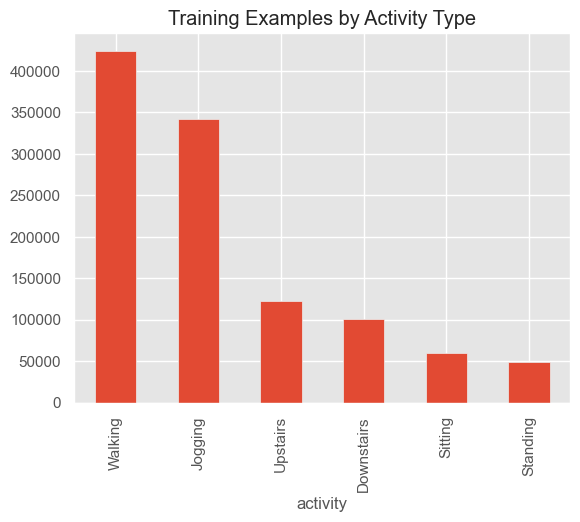

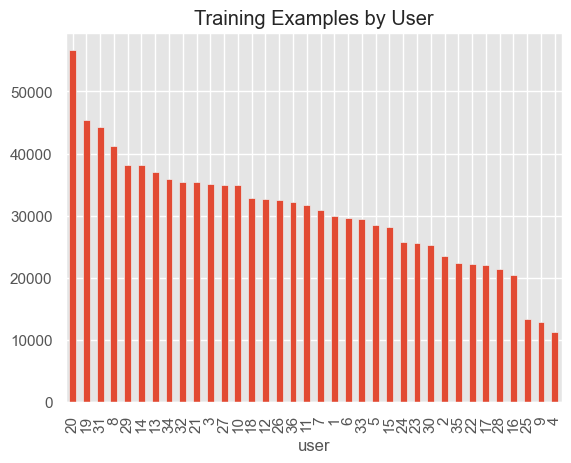

In [7]:
# by activity type
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

# by user
df['user'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

- We have more data for walking and jogging activities more than other activities.
- 36 participants

<br>

**Accelerometer data** for six activities
- sampling rates 20Hz (20 values per second)
    - first 180 records == 9 second interval
        - 1/200 * 180 = 9 seconds

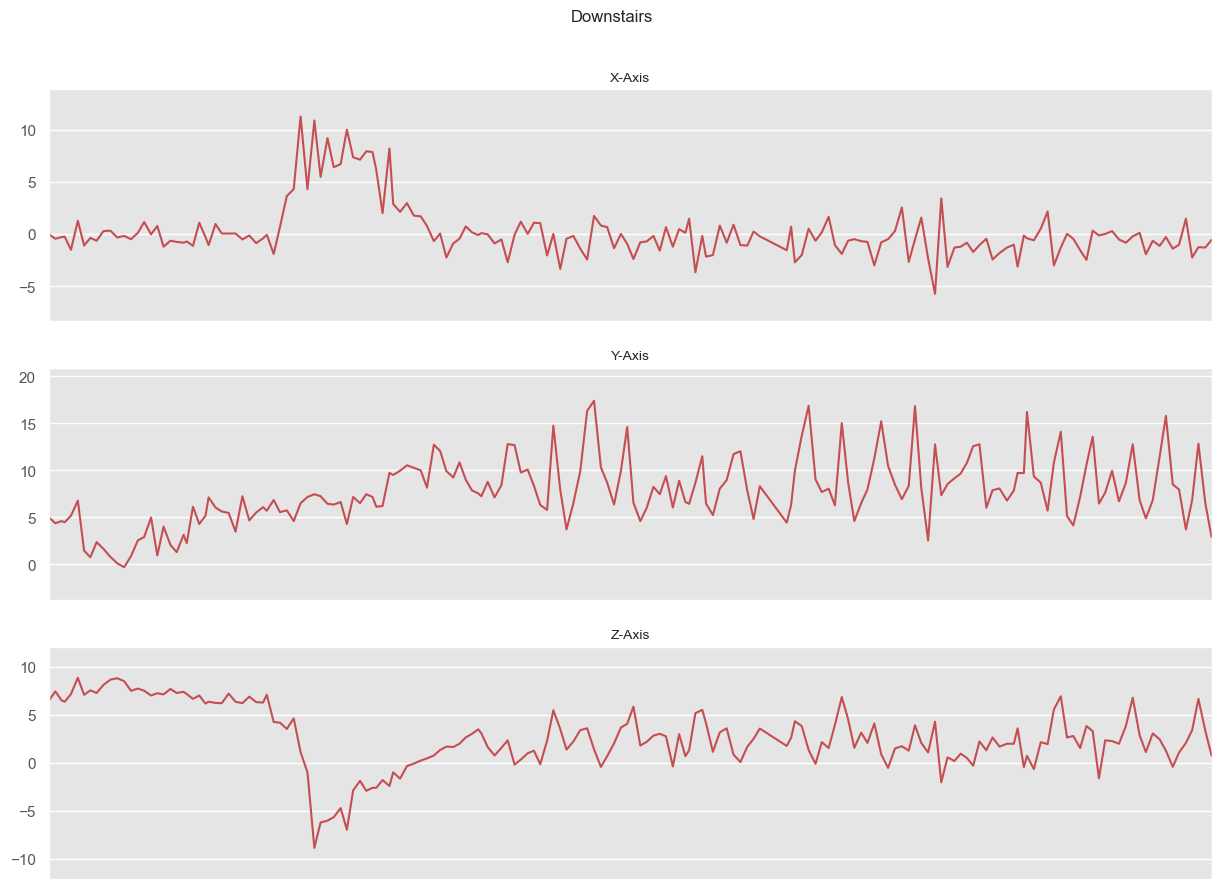

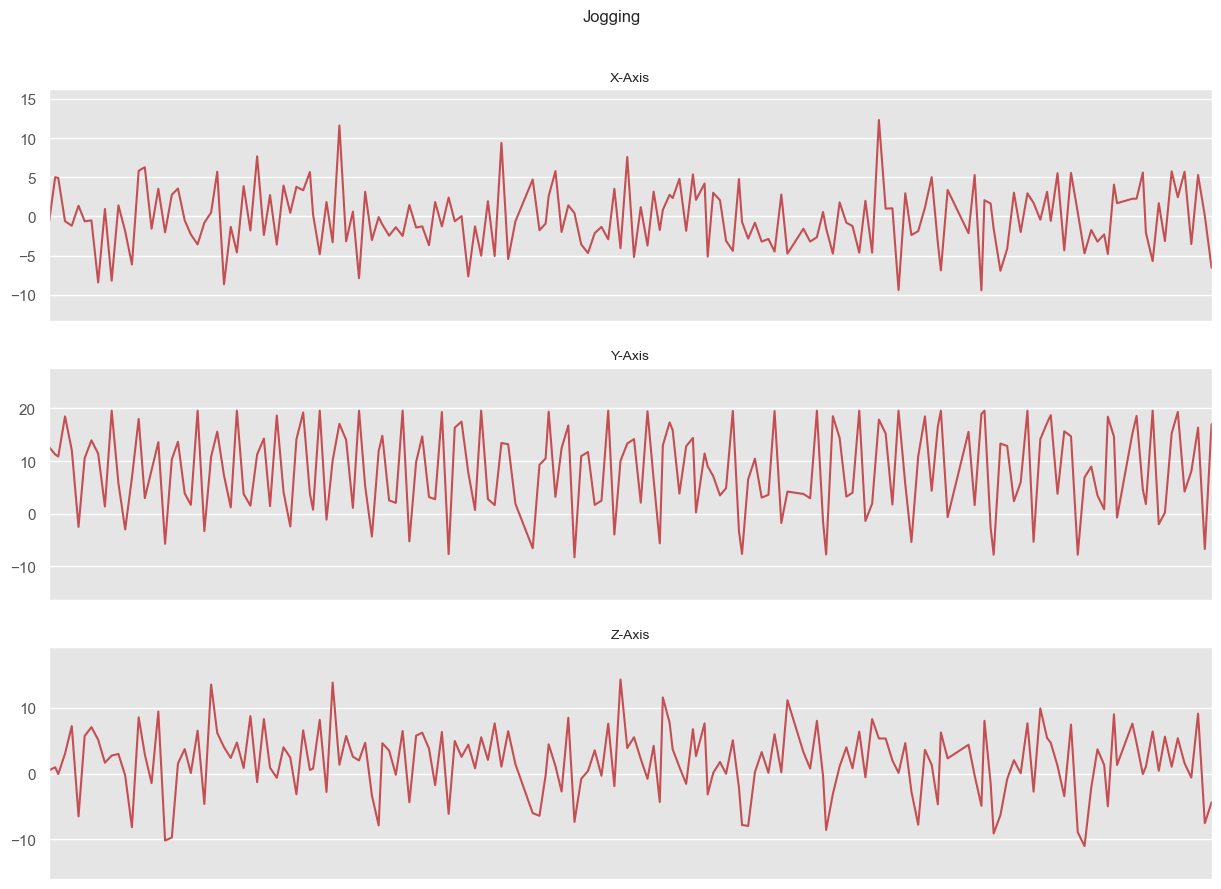

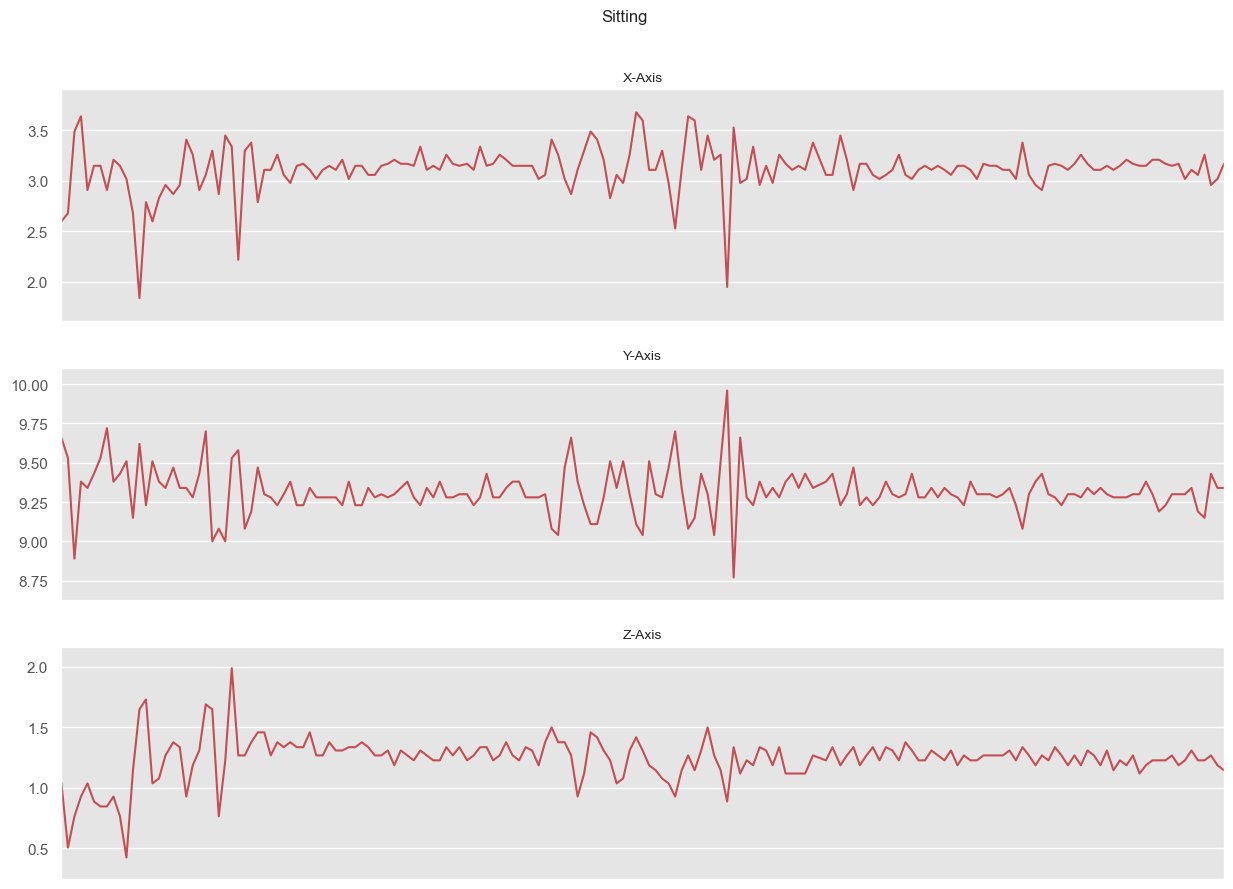

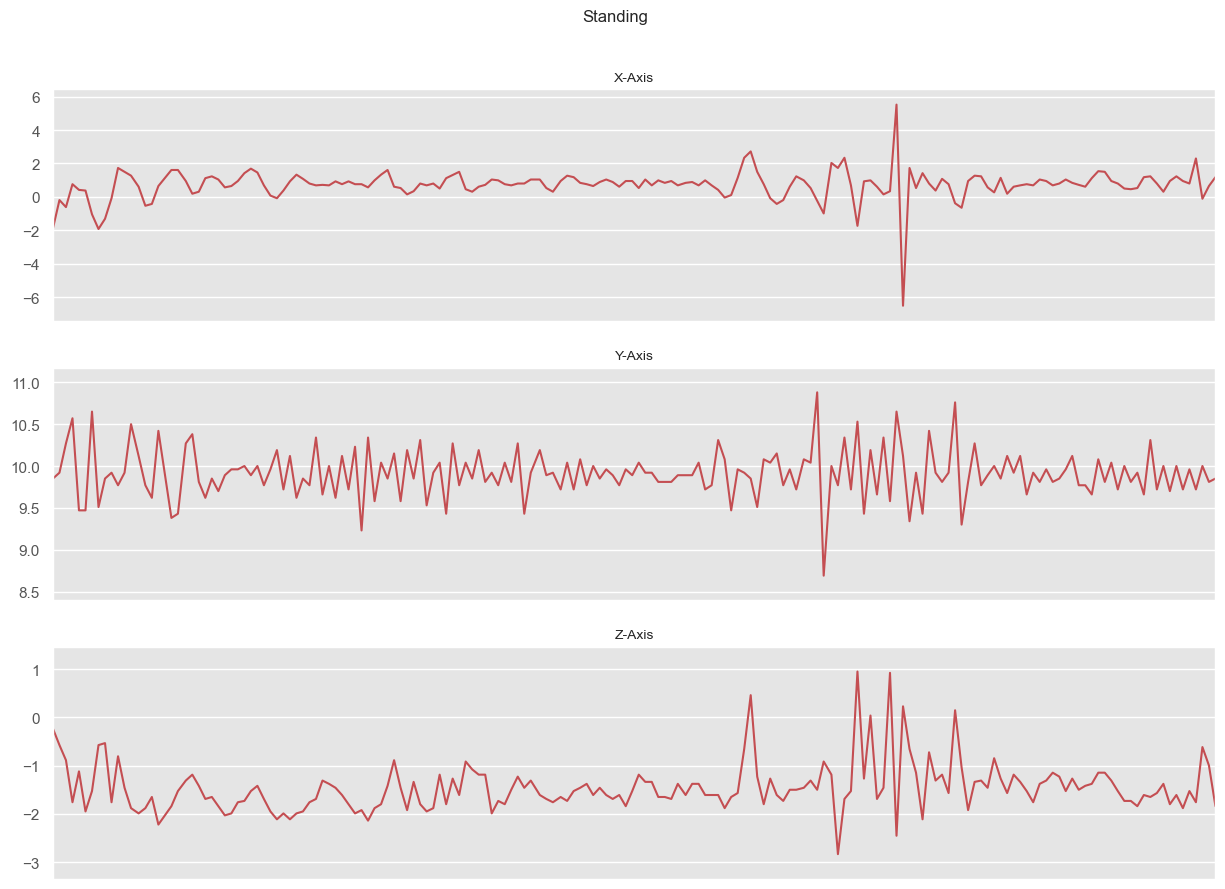

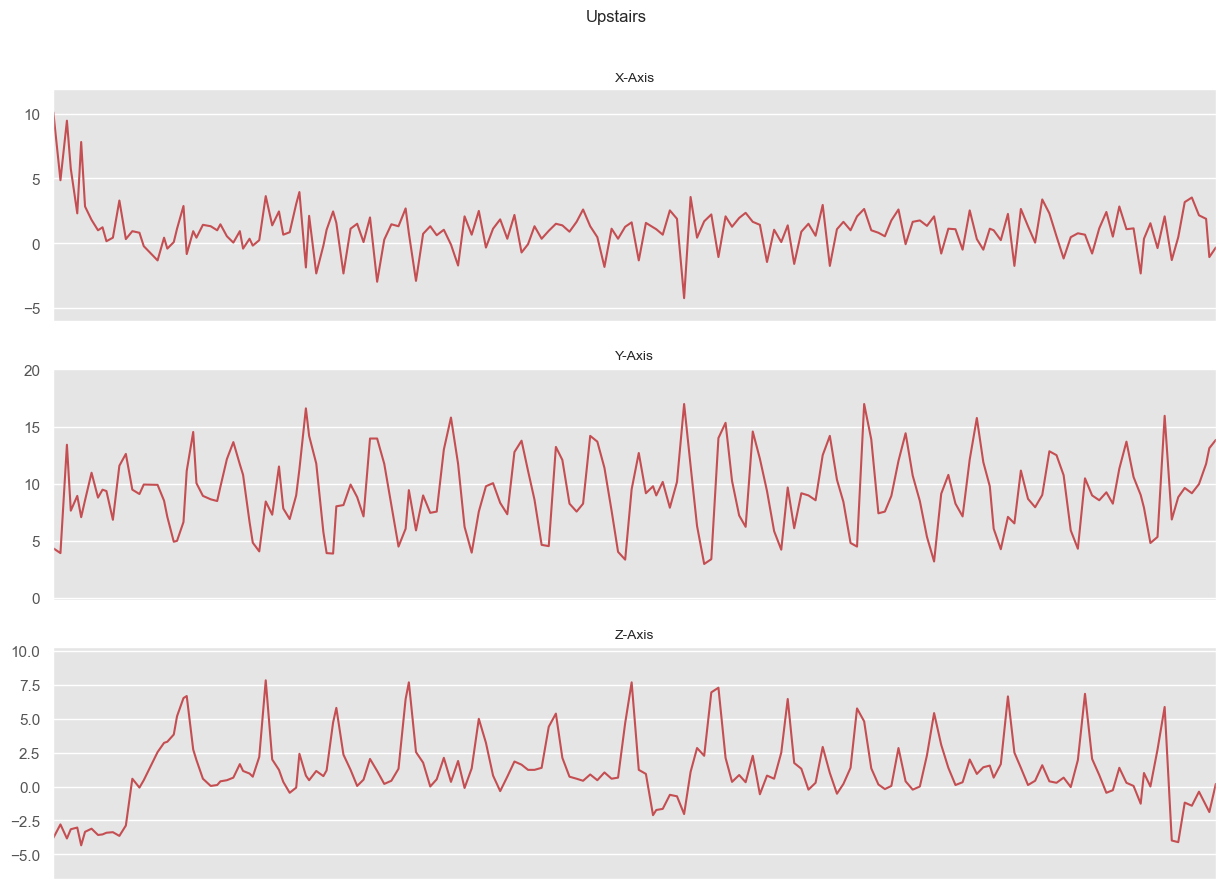

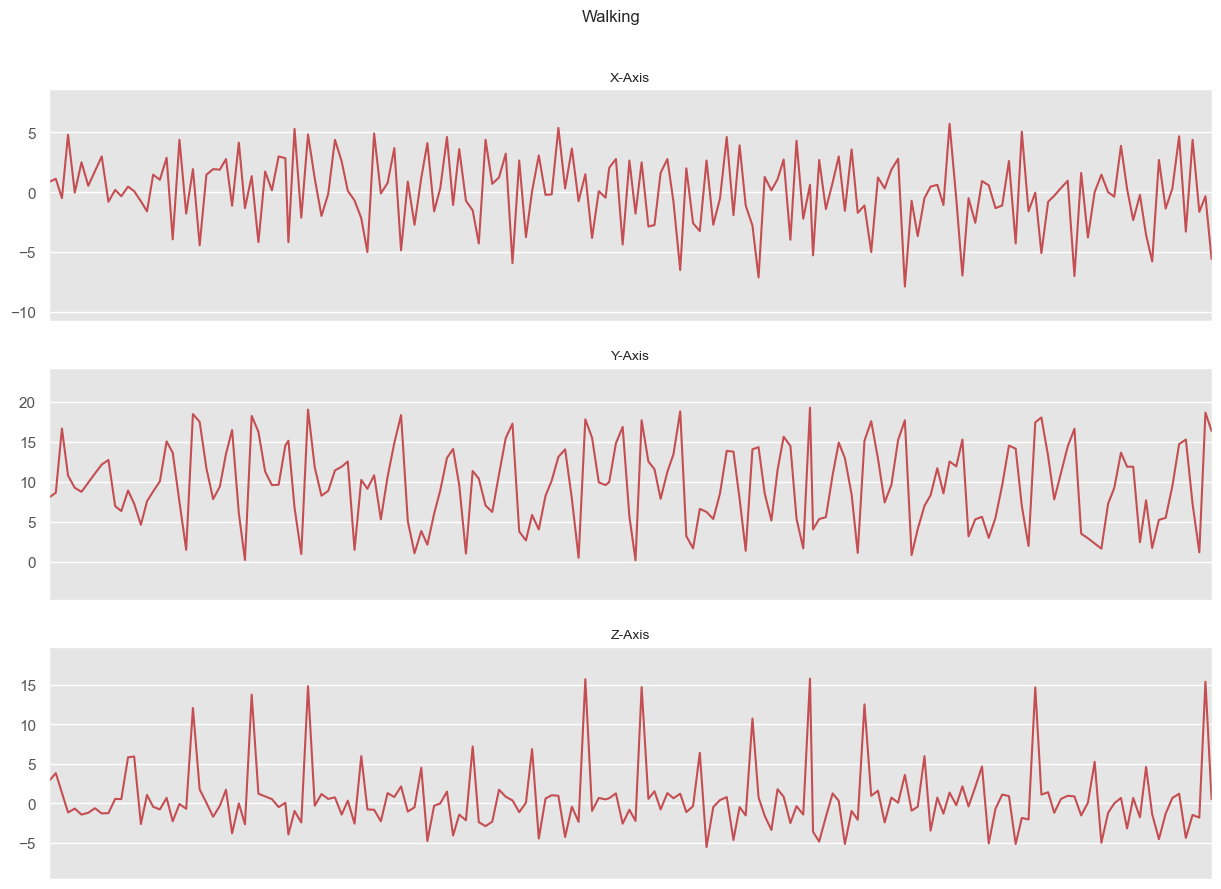

In [8]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')  # x
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')  # y
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')  # z
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title, fontsize=10)
    ax.xaxis.set_visible(False)

    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]  # check only for first 180 records (9 seconds)
    plot_activity(activity, subset)

Activies like Walking and Jogging has higher acceleration compared to Sitting.

Add **new column** called **'ActivityEncoded'** to the dataframe
- encoded value for each activity
- Why?
    - DNN only work with numerical labels
        - **need to change string label to number!**
            0. Downstairs
            1. Jogging
            2. Sitting
            3. Standing
            4. Upstairs
            5. Walking

In [9]:
LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1


In [10]:
df.user.max()

36

In [11]:
# Split data into train and test set
# train: user 1 ~ 28
# test: user 28 ~

df_train = df[df['user'] <= 28] 
df_valid = df[(df['user'] > 21) & (df['user'] <= 28)] ## ADD VALIDATION
df_test = df[df['user'] > 28]

In [12]:
# normalize train data (value range: 0 ~ 1)
# normalization should be applied to test data in the same way
pd.options.mode.chained_assignment = None  # defual='warm'

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_valid['x-axis'] = df_valid['x-axis'] / df_valid['x-axis'].max()
df_valid['y-axis'] = df_valid['y-axis'] / df_valid['y-axis'].max()
df_valid['z-axis'] = df_valid['z-axis'] / df_valid['z-axis'].max()

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()


# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_valid = df_valid.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_train.head()

,user,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,0.0,0.5,-0.0,5
8490,17,Walking,57870012316000,-0.0,0.5,-0.0,5
8491,17,Walking,57870122301000,-0.0,0.5,-0.0,5
8492,17,Walking,57870222246000,0.0,0.5,-0.0,5
8493,17,Walking,57870332292000,0.0,0.5,-0.0,5


Still the dataframe is not ready yet to be fed into a neural network.

So, we need to reshpae it.

In [13]:
# 80 steps => 4 sec (0.05 * 80 = 4)

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y


x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)  # LABEL = 'ActivityEncoded'

x_val, y_val = create_segments_and_labels(df_valid,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)  # LABEL = 'ActivityEncoded'


x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

In [14]:
print(TIME_PERIODS, STEP_DISTANCE)

80 40


In [15]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


In [16]:
print('x_test shape: ', x_test.shape)
print(x_val.shape[0], 'training samples')
print('y_test shape: ', y_test.shape)

x_test shape:  (6584, 80, 3)
4401 training samples
y_test shape:  (6584,)


`x_train` has 20868 records of 2D-matrix of shape 80x3.

**Dimensions we need to remeber**

- #_time periods: the number of time periods within 1 record
    - 4 second interval => 80
- #_sensors: 3 (x, y, z axis acceleration)
- #_classes: the number of the nodes for output layer -> 6

In [17]:
# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size
print(list(le.classes_))
print(n_time_periods, n_sensors)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
80 3


The input data is 2D (80x3).


In [18]:
input_shape = (n_time_periods * n_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input shape:', input_shape)

x_train shape: (20868, 240)
input shape: 240


In [19]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [20]:

def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  torch.Size([20868, 6])


In PyTorch, we need to wrap these NumPy arrays into a dataset and then create a DataLoader for batch processing.

Do Same for Validation set

In [21]:
# input, output dimensions
n_time_periods_val, n_sensors_val = x_val.shape[1], x_val.shape[2]
n_classes = le.classes_.size
print(list(le.classes_))
print(n_time_periods_val, n_sensors_val)

input_shape_val = (n_time_periods_val * n_sensors_val)
x_val = x_val.reshape(x_val.shape[0], input_shape_val)
print('x_train shape:', x_val.shape)
print('input shape:', input_shape_val)

x_val = x_val.astype('float32')
y_val = y_val.astype('float32')


n_classes_val = len(np.unique(y_val))  # Assuming y_train is available and contains your class labels
y_val_hot = to_categorical(y_val, n_classes_val)

print('New y_train shape: ', y_val_hot.shape)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
80 3
x_train shape: (4401, 240)
input shape: 240
New y_train shape:  torch.Size([4401, 6])


In [22]:
# normalize test data

n_time_periods_test, n_sensors_test = x_test.shape[1], x_test.shape[2]
n_classes = le.classes_.size
print(list(le.classes_))
print(n_time_periods_test, n_sensors_test)

input_shape_test = (n_time_periods_test * n_sensors_test)
x_test = x_test.reshape(x_test.shape[0], input_shape_test)
print('x_train shape:', x_test.shape)
print('input shape:', input_shape_test)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')


n_classes_test = len(np.unique(y_test))  # Assuming y_train is available and contains your class labels
y_test_hot = to_categorical(y_test, n_classes_test)

print('New y_train shape: ', y_test_hot.shape)


['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
80 3
x_train shape: (6584, 240)
input shape: 240
New y_train shape:  torch.Size([6584, 6])


In [327]:
x_train.shape

(20868, 240)

# Create Data Loaders

In [23]:

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)  # long for CrossEntropyLoss

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader_64 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_64 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

batch_size = 128  # You can change this value as per your need
train_loader_128 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_128 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

batch_size = 256  # You can change this value as per your need
train_loader_256 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_256 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Multi-layer Perceptron - Original

In [210]:
class MLP(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MLP, self).__init__()
        self.time_periods = time_periods
        self.n_classes = n_classes

        # MLP Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, n_classes)

    def forward(self, x):
        # Using log_softmax for numerical stability
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # x = F.log_softmax(self.fc4(x), dim=1)  # Using log_softmax
        x = self.fc4(x)
        return x

# Assuming TIME_PERIODS and n_classes are defined
model_mlp = MLP(TIME_PERIODS, n_classes)
model_mlp.to(device)

# Print model summary
print(model_mlp)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=6, bias=True)
)


In [109]:


class mlp_wide_with_droupout(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(mlp_wide_with_droupout, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, n_classes)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc3(x)
        return x

class mlp_leaky_relu(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(mlp_leaky_relu, self).__init__()
        self.time_periods = time_periods
        self.n_classes = n_classes

        # MLP Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, n_classes)

    def forward(self, x):
        # Using log_softmax for numerical stability
        x = self.flatten(x)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        # x = F.log_softmax(self.fc4(x), dim=1)  # Using log_softmax
        x = self.fc4(x)
        return x

class mlp_5(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(mlp_5, self).__init__()
        self.time_periods = time_periods
        self.n_classes = n_classes

        # MLP Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, n_classes)

    def forward(self, x):
        # Using log_softmax for numerical stability
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        # x = F.log_softmax(self.fc4(x), dim=1)  # Using log_softmax
        x = self.fc5(x)
        return x


In [33]:
# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss() 

# Choose your Optimizer
my_optimizer = torch.optim.Adam(model_mlp.parameters()) 


In [111]:
# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss() 

# Choose your Optimizer
my_optimizer = torch.optim.Adam(model_mlp.parameters()) 


BATCH_SIZE = 400
EPOCHS = 500


def validate(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    val_losses = []
    val_accs = []
    val_loss = 0.0
    corrects = 0
    
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

            val_losses.append(loss.item() / inputs.size(0)) # Store loss for each batch
            val_accs.append(torch.sum(preds == labels.data) / inputs.size(0))  # Store accuracy for each batch

    val_loss /= len(test_loader.dataset)
    val_acc = corrects / len(test_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)


    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')
    return val_losses, val_accs, val_loss, val_acc  # Return loss and accuracy for tracking

def train_and_validate_mlp(model, device, train_loader, test_loader, optimizer, num_epochs, patience=80):
    # Initialize lists to store losses and accuracies for both training and validation
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    # Initialize variables for early stopping
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss /= len(test_loader.dataset)
        val_acc = val_corrects / len(test_loader.dataset)
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break
    
    # Load the best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, train_accs, val_losses, val_accs


In [110]:
train_losses, train_accs, val_losses, val_accs = train_and_validate(model_mlp, device,train_loader_64, test_loader_64, my_optimizer, EPOCHS)


Epoch 1/500 - Train Loss: 0.7991, Train Acc: 0.7164, Val Loss: 0.7253, Val Acc: 0.7339
Epoch 2/500 - Train Loss: 0.4463, Train Acc: 0.8329, Val Loss: 0.7999, Val Acc: 0.7336
Epoch 3/500 - Train Loss: 0.3391, Train Acc: 0.8689, Val Loss: 0.8701, Val Acc: 0.7043
Epoch 4/500 - Train Loss: 0.2983, Train Acc: 0.8831, Val Loss: 0.8906, Val Acc: 0.7262
Epoch 5/500 - Train Loss: 0.2561, Train Acc: 0.8972, Val Loss: 1.1728, Val Acc: 0.6751
Epoch 6/500 - Train Loss: 0.2312, Train Acc: 0.9074, Val Loss: 0.9102, Val Acc: 0.7512
Epoch 7/500 - Train Loss: 0.2042, Train Acc: 0.9186, Val Loss: 1.0289, Val Acc: 0.7230
Epoch 8/500 - Train Loss: 0.1774, Train Acc: 0.9305, Val Loss: 1.0854, Val Acc: 0.7204
Epoch 9/500 - Train Loss: 0.1659, Train Acc: 0.9342, Val Loss: 1.0818, Val Acc: 0.7337
Epoch 10/500 - Train Loss: 0.1524, Train Acc: 0.9386, Val Loss: 1.0076, Val Acc: 0.7555
Epoch 11/500 - Train Loss: 0.1426, Train Acc: 0.9435, Val Loss: 1.1672, Val Acc: 0.7380
Epoch 12/500 - Train Loss: 0.1225, Train 

In [111]:
val_losses, val_accs, val_loss, val_acc = validate(model_mlp, device)

Validation Loss: 2.4625, Validation Acc: 0.7919


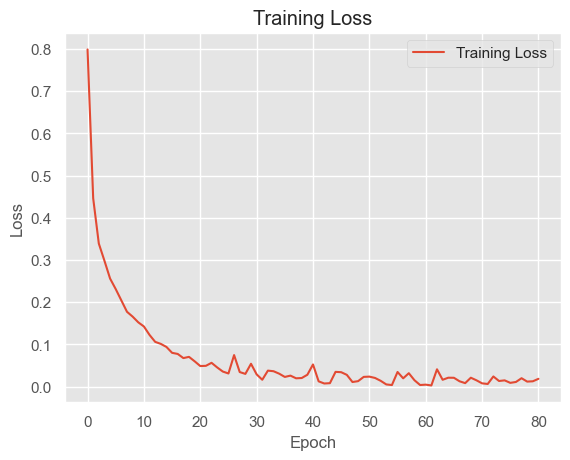

In [115]:
# Losses and accuracy plots
def plot_loss(train_losses, val_losses):
    plt.figure()  # Create a new figure
    
    plt.plot(train_losses, label='Training Loss')
    # plt.plot(val_losses, label='Validation Loss')
   
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

def plot_acc(train_accs, val_accs):
    plt.figure()  # Create a new figure
    
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
   
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

plot_loss(train_losses, val_losses)
# plot_acc(train_accs, val_accs)

Result from the article

![Expectation](attachment:16797bb4-c2ae-4f1b-8a7a-e195e39da9c3.png)

## Test

In [121]:
# normalize test data

# df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
# df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
# df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

# x_test, y_test = create_segments_and_labels(df_test,
#                                             TIME_PERIODS,
#                                             STEP_DISTANCE,
#                                             LABEL)

# x_test = x_test.reshape(x_test.shape[0], input_shape)

# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')

# y_test = to_categorical(y_test, n_classes)

print('Accuracy on test data: ', val_accs[-1])
print('Loss on test data: ', val_losses[-1])

Accuracy on test data:  tensor(0.7919, device='mps:0')
Loss on test data:  2.4624805837739996


The test accuray is **about 75%**.

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

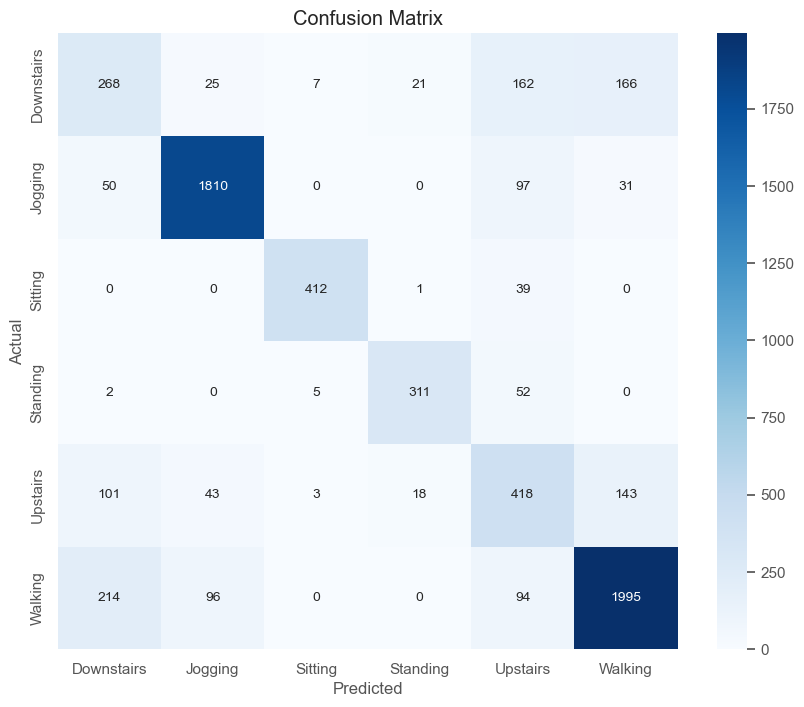

              precision    recall  f1-score   support

  Downstairs       0.42      0.41      0.42       649
     Jogging       0.92      0.91      0.91      1988
     Sitting       0.96      0.91      0.94       452
    Standing       0.89      0.84      0.86       370
    Upstairs       0.48      0.58      0.53       726
     Walking       0.85      0.83      0.84      2399

    accuracy                           0.79      6584
   macro avg       0.75      0.75      0.75      6584
weighted avg       0.80      0.79      0.80      6584



In [126]:
def evaluate_model(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to track gradients
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

device_eval = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp, device, test_loader)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## Same MLP - Batch Size 256

In [217]:
model_mlp_256 = MLP(TIME_PERIODS, n_classes)
model_mlp_256.to(device)
my_optimizer_256 = torch.optim.Adam(model_mlp_256.parameters()) 


train_losses_2, train_accs_2, val_losses_2, val_accs_2 = train_and_validate_mlp(model_mlp_256, device,train_loader_256, test_loader_256, my_optimizer_256, EPOCHS, patience=50)

Epoch 1/500 - Train Loss: 1.1557, Train Acc: 0.5889, Val Loss: 1.1161, Val Acc: 0.6627
Epoch 2/500 - Train Loss: 0.6943, Train Acc: 0.7554, Val Loss: 0.9232, Val Acc: 0.6988
Epoch 3/500 - Train Loss: 0.5382, Train Acc: 0.8041, Val Loss: 0.8128, Val Acc: 0.7301
Epoch 4/500 - Train Loss: 0.3964, Train Acc: 0.8446, Val Loss: 0.8671, Val Acc: 0.7368
Epoch 5/500 - Train Loss: 0.3256, Train Acc: 0.8717, Val Loss: 0.8973, Val Acc: 0.7473
Epoch 6/500 - Train Loss: 0.2890, Train Acc: 0.8847, Val Loss: 0.9379, Val Acc: 0.7371
Epoch 7/500 - Train Loss: 0.2604, Train Acc: 0.8961, Val Loss: 0.9447, Val Acc: 0.7404
Epoch 8/500 - Train Loss: 0.2346, Train Acc: 0.9064, Val Loss: 1.0113, Val Acc: 0.7544
Epoch 9/500 - Train Loss: 0.2157, Train Acc: 0.9125, Val Loss: 1.1265, Val Acc: 0.7369
Epoch 10/500 - Train Loss: 0.2029, Train Acc: 0.9194, Val Loss: 1.0284, Val Acc: 0.7682
Epoch 11/500 - Train Loss: 0.1805, Train Acc: 0.9290, Val Loss: 1.0728, Val Acc: 0.7198
Epoch 12/500 - Train Loss: 0.1684, Train 

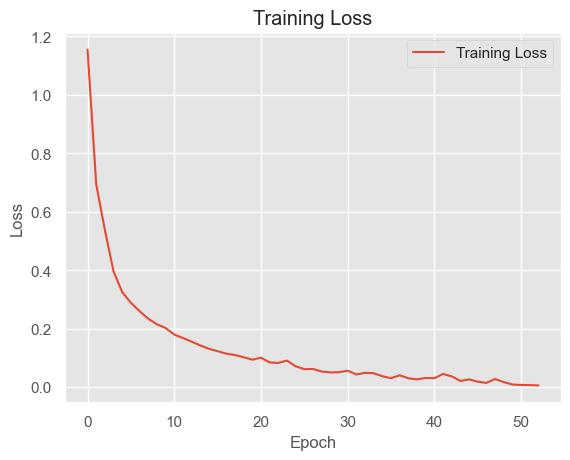

In [218]:
plot_loss(train_losses_2, val_losses_2)

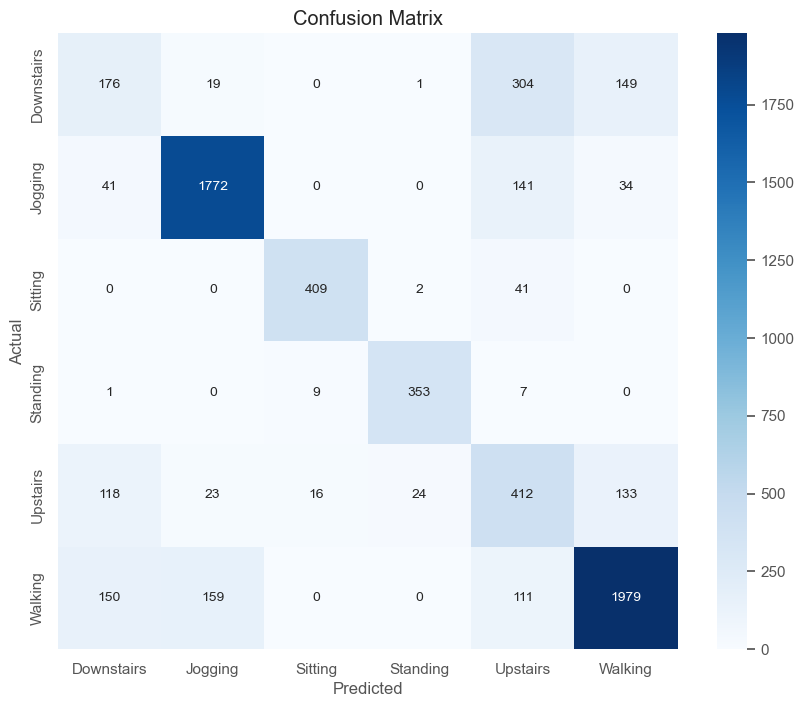

              precision    recall  f1-score   support

  Downstairs       0.36      0.27      0.31       649
     Jogging       0.90      0.89      0.89      1988
     Sitting       0.94      0.90      0.92       452
    Standing       0.93      0.95      0.94       370
    Upstairs       0.41      0.57      0.47       726
     Walking       0.86      0.82      0.84      2399

    accuracy                           0.77      6584
   macro avg       0.73      0.74      0.73      6584
weighted avg       0.78      0.77      0.78      6584



In [220]:
def evaluate_model(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to track gradients
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

device_eval = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp_256.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp_256, device_eval, test_loader_128)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## Same MLP - Leaky Relu

In [42]:
# Assuming TIME_PERIODS and n_classes are defined
model_mlp_leaky_relu = mlp_leaky_relu(TIME_PERIODS, n_classes)
model_mlp_leaky_relu.to(device)

# Choose your Optimizer
optimizer_leaky_relu = torch.optim.Adam(model_mlp_leaky_relu.parameters()) 

In [43]:
train_losses_leaky_relu, train_accs_leaky_relu, val_losses_leaky_relu, val_accs_leaky_relu = train_and_validate(model_mlp_leaky_relu, device,train_loader_64, test_loader_64, optimizer_leaky_relu, EPOCHS)

Epoch 1/500 - Train Loss: 0.8146, Train Acc: 0.7130, Val Loss: 0.7808, Val Acc: 0.7110
Epoch 2/500 - Train Loss: 0.4203, Train Acc: 0.8402, Val Loss: 0.8334, Val Acc: 0.6974
Epoch 3/500 - Train Loss: 0.3356, Train Acc: 0.8706, Val Loss: 0.8663, Val Acc: 0.7152
Epoch 4/500 - Train Loss: 0.2915, Train Acc: 0.8878, Val Loss: 0.8221, Val Acc: 0.7300
Epoch 5/500 - Train Loss: 0.2558, Train Acc: 0.8999, Val Loss: 0.8642, Val Acc: 0.7479
Epoch 6/500 - Train Loss: 0.2267, Train Acc: 0.9113, Val Loss: 0.9891, Val Acc: 0.7161
Epoch 7/500 - Train Loss: 0.2078, Train Acc: 0.9188, Val Loss: 0.9645, Val Acc: 0.7157
Epoch 8/500 - Train Loss: 0.1828, Train Acc: 0.9272, Val Loss: 0.8812, Val Acc: 0.7723
Epoch 9/500 - Train Loss: 0.1647, Train Acc: 0.9353, Val Loss: 0.9643, Val Acc: 0.7523
Epoch 10/500 - Train Loss: 0.1462, Train Acc: 0.9436, Val Loss: 1.1560, Val Acc: 0.7661
Epoch 11/500 - Train Loss: 0.1312, Train Acc: 0.9506, Val Loss: 1.3360, Val Acc: 0.7280
Epoch 12/500 - Train Loss: 0.1284, Train 

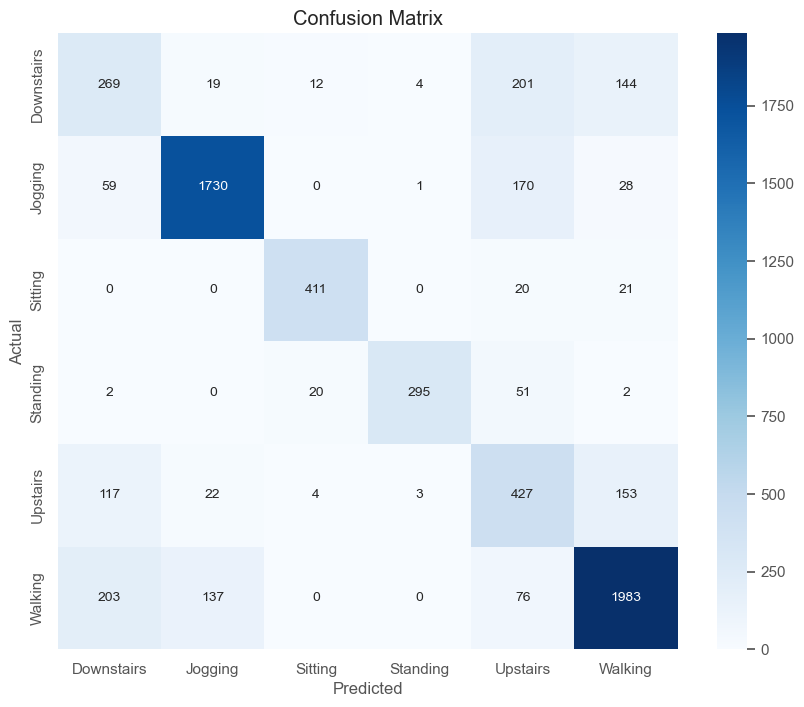

              precision    recall  f1-score   support

  Downstairs       0.41      0.41      0.41       649
     Jogging       0.91      0.87      0.89      1988
     Sitting       0.92      0.91      0.91       452
    Standing       0.97      0.80      0.88       370
    Upstairs       0.45      0.59      0.51       726
     Walking       0.85      0.83      0.84      2399

    accuracy                           0.78      6584
   macro avg       0.75      0.73      0.74      6584
weighted avg       0.79      0.78      0.78      6584



In [45]:
# device_eval = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp_leaky_relu.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp_leaky_relu, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## Same MLP - Leaky Relu - lower LR

In [46]:
# Assuming TIME_PERIODS and n_classes are defined
model_mlp_leaky_relu_low_lr = MyModel(TIME_PERIODS, n_classes)
model_mlp_leaky_relu_low_lr.to(device)

# Choose your Optimizer
optimizer_leaky_relu_low_lr = torch.optim.Adam(model_mlp_leaky_relu_low_lr.parameters(), lr=0.0001) 

In [47]:
train_losses_leaky_relu, train_accs_leaky_relu, val_losses_leaky_relu, val_accs_leaky_relu = train_and_validate(model_mlp_leaky_relu_low_lr, device,train_loader_64, test_loader_64, optimizer_leaky_relu_low_lr, EPOCHS)

Epoch 1/500 - Train Loss: 1.4104, Train Acc: 0.5144, Val Loss: 1.2915, Val Acc: 0.5213
Epoch 2/500 - Train Loss: 0.8845, Train Acc: 0.7129, Val Loss: 1.0807, Val Acc: 0.6604
Epoch 3/500 - Train Loss: 0.7437, Train Acc: 0.7455, Val Loss: 1.0062, Val Acc: 0.6652
Epoch 4/500 - Train Loss: 0.6901, Train Acc: 0.7572, Val Loss: 0.9647, Val Acc: 0.6643
Epoch 5/500 - Train Loss: 0.6462, Train Acc: 0.7732, Val Loss: 0.8829, Val Acc: 0.6845
Epoch 6/500 - Train Loss: 0.6050, Train Acc: 0.7938, Val Loss: 0.8474, Val Acc: 0.6965
Epoch 7/500 - Train Loss: 0.5705, Train Acc: 0.8036, Val Loss: 0.8234, Val Acc: 0.7038
Epoch 8/500 - Train Loss: 0.5425, Train Acc: 0.8095, Val Loss: 0.7747, Val Acc: 0.7088
Epoch 9/500 - Train Loss: 0.5206, Train Acc: 0.8128, Val Loss: 0.7846, Val Acc: 0.7049
Epoch 10/500 - Train Loss: 0.4988, Train Acc: 0.8168, Val Loss: 0.7676, Val Acc: 0.7126
Epoch 11/500 - Train Loss: 0.4787, Train Acc: 0.8218, Val Loss: 0.7819, Val Acc: 0.7082
Epoch 12/500 - Train Loss: 0.4588, Train 

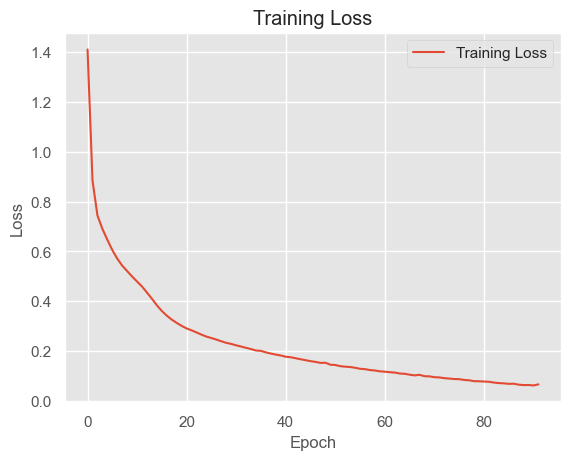

In [48]:
plot_loss(train_losses_leaky_relu, val_losses_leaky_relu)

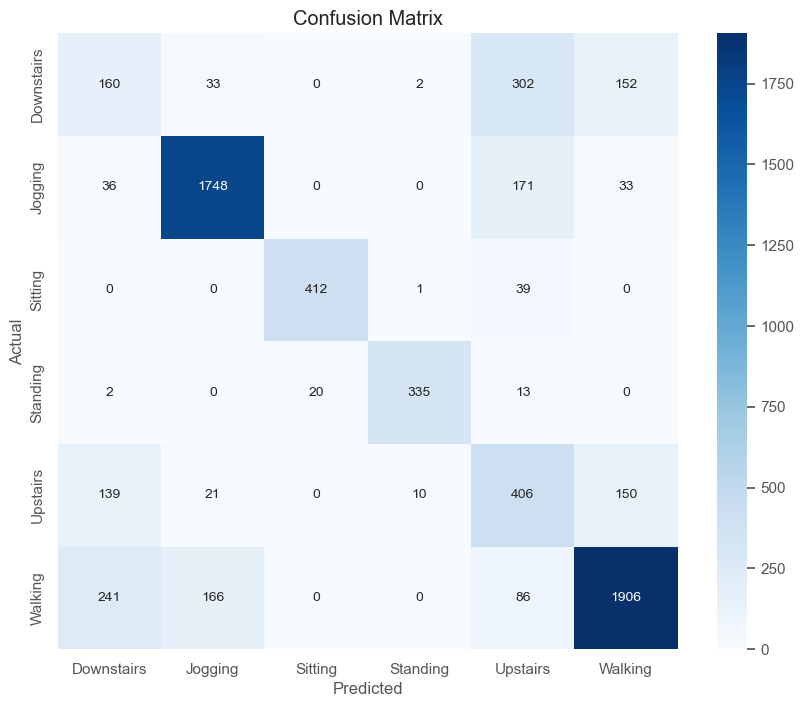

              precision    recall  f1-score   support

  Downstairs       0.28      0.25      0.26       649
     Jogging       0.89      0.88      0.88      1988
     Sitting       0.95      0.91      0.93       452
    Standing       0.96      0.91      0.93       370
    Upstairs       0.40      0.56      0.47       726
     Walking       0.85      0.79      0.82      2399

    accuracy                           0.75      6584
   macro avg       0.72      0.72      0.72      6584
weighted avg       0.77      0.75      0.76      6584



In [49]:
# device_eval = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp_leaky_relu_low_lr.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp_leaky_relu_low_lr, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## Wider/Shorter - MLP with dropout

In [50]:
# Assuming TIME_PERIODS and n_classes are defined
model_mlp_wide = mlp_wide_with_droupout(TIME_PERIODS, n_classes)
model_mlp_wide.to(device)

# Choose your Optimizer
optimizer_wide = torch.optim.Adam(model_mlp_wide.parameters()) 

In [153]:
model_mlp_wide


mlp_wide_with_droupout(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=6, bias=True)
)

In [157]:
from torchsummary import summary

# Assuming your model is named 'model' and is already defined,
# and you know the input size (e.g., for CIFAR10: 3 channels, 32x32 images)
# model.to('cuda' or 'cpu')  # Depending on your device
summary(model_mlp_wide, input_size=(1, 240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 240]               0
            Linear-2                  [-1, 512]         123,392
            Linear-3                  [-1, 512]         262,656
            Linear-4                    [-1, 6]           3,078
Total params: 389,126
Trainable params: 389,126
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.48
Estimated Total Size (MB): 1.50
----------------------------------------------------------------


In [148]:
x_train_tensor.shape

torch.Size([20868, 240])

In [51]:
train_losses_wide, train_accs_wide, val_losses_wide, val_accs_wide = train_and_validate(model_mlp_wide, device,train_loader_64, test_loader_64, optimizer_wide, EPOCHS)

Epoch 1/500 - Train Loss: 0.7405, Train Acc: 0.7417, Val Loss: 0.6885, Val Acc: 0.7321
Epoch 2/500 - Train Loss: 0.4614, Train Acc: 0.8272, Val Loss: 0.6026, Val Acc: 0.7833
Epoch 3/500 - Train Loss: 0.4013, Train Acc: 0.8453, Val Loss: 0.6716, Val Acc: 0.7667
Epoch 4/500 - Train Loss: 0.3717, Train Acc: 0.8570, Val Loss: 0.6829, Val Acc: 0.7664
Epoch 5/500 - Train Loss: 0.3383, Train Acc: 0.8662, Val Loss: 0.6048, Val Acc: 0.8038
Epoch 6/500 - Train Loss: 0.3063, Train Acc: 0.8790, Val Loss: 0.6308, Val Acc: 0.7866
Epoch 7/500 - Train Loss: 0.2954, Train Acc: 0.8847, Val Loss: 0.6574, Val Acc: 0.8070
Epoch 8/500 - Train Loss: 0.2686, Train Acc: 0.8972, Val Loss: 0.6255, Val Acc: 0.7994
Epoch 9/500 - Train Loss: 0.2516, Train Acc: 0.9036, Val Loss: 0.6856, Val Acc: 0.7945
Epoch 10/500 - Train Loss: 0.2376, Train Acc: 0.9091, Val Loss: 0.6997, Val Acc: 0.8118
Epoch 11/500 - Train Loss: 0.2259, Train Acc: 0.9151, Val Loss: 0.7518, Val Acc: 0.8133
Epoch 12/500 - Train Loss: 0.2079, Train 

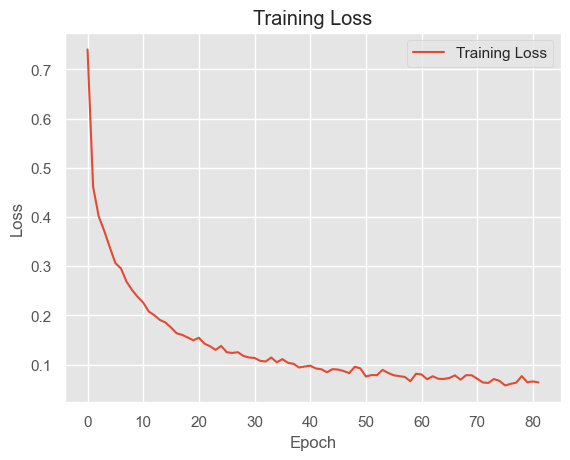

In [53]:
plot_loss(train_losses_wide, val_losses_wide)

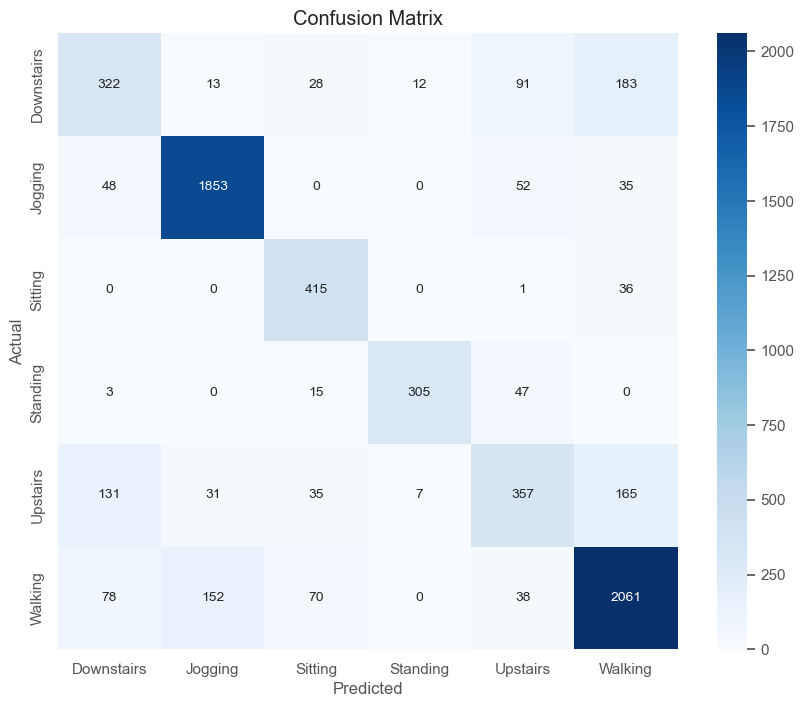

              precision    recall  f1-score   support

  Downstairs       0.55      0.50      0.52       649
     Jogging       0.90      0.93      0.92      1988
     Sitting       0.74      0.92      0.82       452
    Standing       0.94      0.82      0.88       370
    Upstairs       0.61      0.49      0.54       726
     Walking       0.83      0.86      0.84      2399

    accuracy                           0.81      6584
   macro avg       0.76      0.75      0.75      6584
weighted avg       0.80      0.81      0.80      6584



In [52]:
# device_eval = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp_wide.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp_wide, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

In [54]:
# Assuming TIME_PERIODS and n_classes are defined
model_mlp_wide = mlp_wide_with_droupout(TIME_PERIODS, n_classes)
model_mlp_wide.to(device)

# Choose your Optimizer
optimizer_wide = torch.optim.Adam(model_mlp_wide.parameters()) 

In [55]:
train_losses_wide_patience25, train_accs_wide, val_losses_wide, val_accs_wide = train_and_validate(model_mlp_wide, device,train_loader_64, test_loader_64, optimizer_wide, EPOCHS,25)

Epoch 1/500 - Train Loss: 0.7369, Train Acc: 0.7417, Val Loss: 0.7113, Val Acc: 0.7344
Epoch 2/500 - Train Loss: 0.4783, Train Acc: 0.8187, Val Loss: 0.5856, Val Acc: 0.7860
Epoch 3/500 - Train Loss: 0.4063, Train Acc: 0.8443, Val Loss: 0.6302, Val Acc: 0.7836
Epoch 4/500 - Train Loss: 0.3700, Train Acc: 0.8563, Val Loss: 0.6763, Val Acc: 0.7643
Epoch 5/500 - Train Loss: 0.3393, Train Acc: 0.8681, Val Loss: 0.7044, Val Acc: 0.7543
Epoch 6/500 - Train Loss: 0.3057, Train Acc: 0.8804, Val Loss: 0.6816, Val Acc: 0.7702
Epoch 7/500 - Train Loss: 0.2871, Train Acc: 0.8889, Val Loss: 0.6775, Val Acc: 0.7898
Epoch 8/500 - Train Loss: 0.2711, Train Acc: 0.8986, Val Loss: 0.6750, Val Acc: 0.8071
Epoch 9/500 - Train Loss: 0.2485, Train Acc: 0.9055, Val Loss: 0.6779, Val Acc: 0.8006
Epoch 10/500 - Train Loss: 0.2442, Train Acc: 0.9070, Val Loss: 0.6834, Val Acc: 0.8152
Epoch 11/500 - Train Loss: 0.2219, Train Acc: 0.9175, Val Loss: 0.6548, Val Acc: 0.8174
Epoch 12/500 - Train Loss: 0.2123, Train 

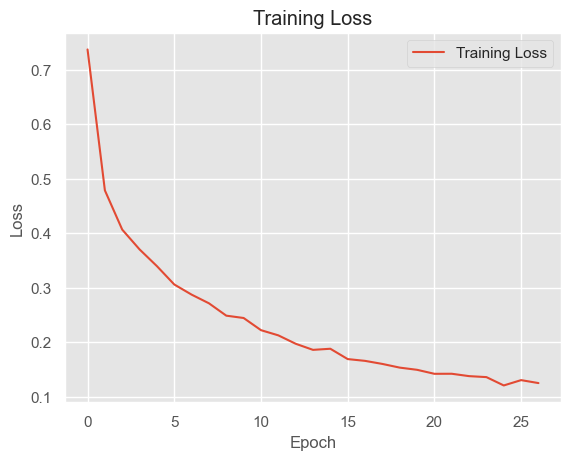

In [57]:
plot_loss(train_losses_wide_patience25, val_losses_wide)

In [221]:
model_mlp_wide

mlp_wide_with_droupout(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=6, bias=True)
)

In [223]:
model_mlp

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=6, bias=True)
)

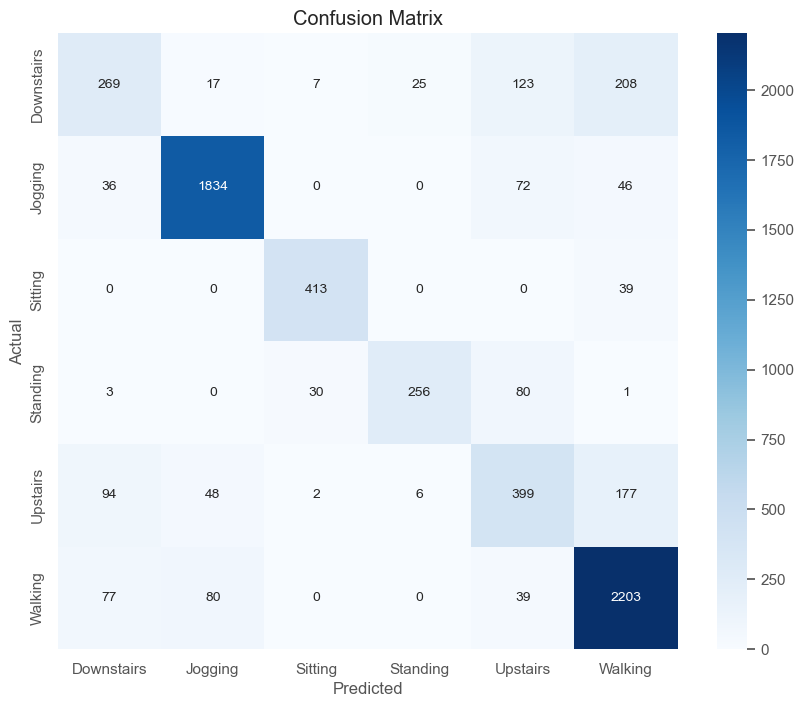

              precision    recall  f1-score   support

  Downstairs       0.56      0.41      0.48       649
     Jogging       0.93      0.92      0.92      1988
     Sitting       0.91      0.91      0.91       452
    Standing       0.89      0.69      0.78       370
    Upstairs       0.56      0.55      0.55       726
     Walking       0.82      0.92      0.87      2399

    accuracy                           0.82      6584
   macro avg       0.78      0.74      0.75      6584
weighted avg       0.81      0.82      0.81      6584



In [56]:
# device_eval = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp_wide.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp_wide, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## Deeper MLP

In [59]:
# Assuming TIME_PERIODS and n_classes are defined
model_mlp_deep = mlp_5(TIME_PERIODS, n_classes)
model_mlp_deep.to(device)

# Choose your Optimizer
optimizer_deep = torch.optim.Adam(model_mlp_deep.parameters()) 

In [60]:
train_losses_deep, train_accs_deep, val_losses_deep, val_accs_deep = train_and_validate(model_mlp_deep, device,train_loader_64, test_loader_64, optimizer_deep, EPOCHS)

Epoch 1/500 - Train Loss: 0.8533, Train Acc: 0.6960, Val Loss: 0.7023, Val Acc: 0.7480
Epoch 2/500 - Train Loss: 0.4645, Train Acc: 0.8311, Val Loss: 0.8298, Val Acc: 0.6964
Epoch 3/500 - Train Loss: 0.3614, Train Acc: 0.8614, Val Loss: 1.1446, Val Acc: 0.6188
Epoch 4/500 - Train Loss: 0.3203, Train Acc: 0.8761, Val Loss: 1.0818, Val Acc: 0.6993
Epoch 5/500 - Train Loss: 0.2795, Train Acc: 0.8888, Val Loss: 0.8980, Val Acc: 0.7312
Epoch 6/500 - Train Loss: 0.2397, Train Acc: 0.9065, Val Loss: 1.1914, Val Acc: 0.6662
Epoch 7/500 - Train Loss: 0.2248, Train Acc: 0.9121, Val Loss: 1.0208, Val Acc: 0.7283
Epoch 8/500 - Train Loss: 0.1998, Train Acc: 0.9218, Val Loss: 1.3230, Val Acc: 0.7148
Epoch 9/500 - Train Loss: 0.1744, Train Acc: 0.9339, Val Loss: 1.1235, Val Acc: 0.7383
Epoch 10/500 - Train Loss: 0.1708, Train Acc: 0.9351, Val Loss: 1.3598, Val Acc: 0.7198
Epoch 11/500 - Train Loss: 0.1552, Train Acc: 0.9409, Val Loss: 1.7499, Val Acc: 0.7395
Epoch 12/500 - Train Loss: 0.1362, Train 

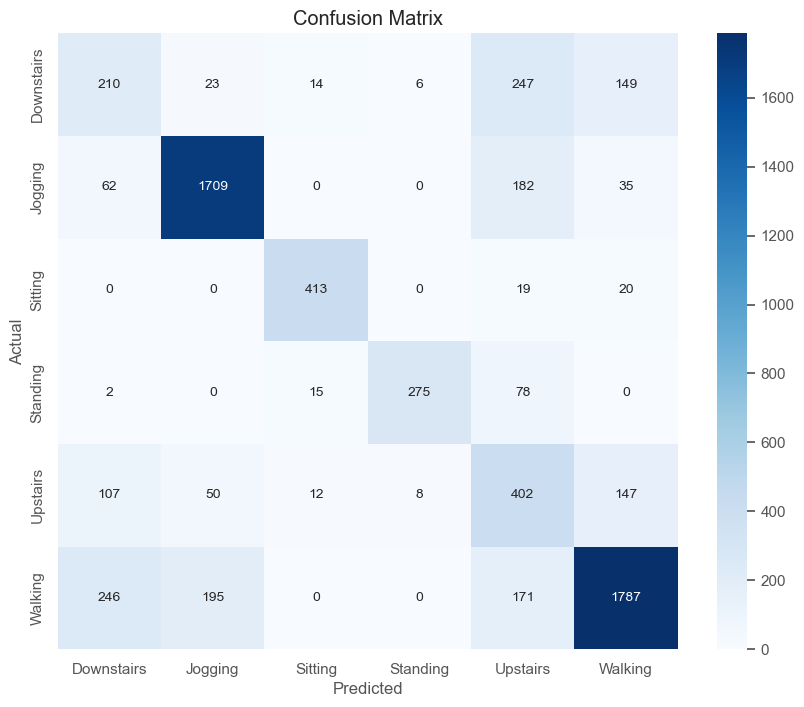

              precision    recall  f1-score   support

  Downstairs       0.33      0.32      0.33       649
     Jogging       0.86      0.86      0.86      1988
     Sitting       0.91      0.91      0.91       452
    Standing       0.95      0.74      0.83       370
    Upstairs       0.37      0.55      0.44       726
     Walking       0.84      0.74      0.79      2399

    accuracy                           0.73      6584
   macro avg       0.71      0.69      0.69      6584
weighted avg       0.75      0.73      0.74      6584



In [61]:
# device_eval = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp_deep.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp_deep, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

In [130]:
# def show_confusion_matrix(validaitons, predictions, title=None):
#     matrix = metrics.confusion_matrix(validaitons, predictions)

#     plt.figure(figsize=(6, 4))
#     sns.heatmap(matrix,
#                 cmap='coolwarm',
#                 linecolor='white',
#                 linewidths=1,
#                 xticklabels=LABELS,
#                 yticklabels=LABELS,
#                 annot=True,
#                 fmt='d')
#     if title: plt.title(title)
#     else: plt.title('Confusion Matrix')
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.show()

# # y_pred_test = model_mlp.predict(x_test)

# model_mlp.eval()
# with torch.no_grad():
#     outputs = model_mlp.forward(x_test.flatten())  # Call the forward method directly  
#     y_pred_test =  outputs.numpy()


# max_y_pred_test = np.argmax(y_pred_test, axis=1)
# max_y_test = np.argmax(y_test, axis=1)

# show_confusion_matrix(max_y_test, max_y_pred_test)

# print(classification_report(max_y_test, max_y_pred_test))

---

# 1D CNN

* Reference article: https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
* Reference code: https://github.com/ni79ls/har-keras-cnn/blob/master/20180903_Keras_HAR_WISDM_CNN_v1.0_for_medium.py

 A 1D CNN is very effective when you expect to derive interesting features from shorter (fixed-length) segments of the overall data set and where the location of the feature within the segment is not of high relevance.


This applies well to the analysis of time sequences of sensor data (such as gyroscope or accelerometer data). It also applies to the analysis of any kind of signal data over a fixed-length period (such as audio signals).


In [62]:
class MyConvModel(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=n_sensors, out_channels=100, kernel_size=10)
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=10)
        self.conv3 = nn.Conv1d(in_channels=100, out_channels=160, kernel_size=10)
        self.conv4 = nn.Conv1d(in_channels=160, out_channels=160, kernel_size=10)

        # Max Pooling
        self.pool = nn.MaxPool1d(kernel_size=3)

        # Adaptive Average Pooling
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        self.fc = nn.Linear(160, n_classes)


    def forward(self, x):
        # # Reshape the input to (batch_size, n_sensors, -1)
        # x = x.view(-1, self.n_sensors, x.size(1))
        actual_time_steps = x.size(-1) // self.n_sensors
        x = x.view(-1, self.n_sensors, actual_time_steps)

        # Convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # Apply max pooling after the second conv layer
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # Global average pooling and dropout
        x = self.adaptive_pool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = torch.flatten(x, 1)

        # Fully connected layer
        x = self.fc(x)

        # Output layer with log_softmax activation
        return F.log_softmax(x, dim=1)

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = MyConvModel(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

MyConvModel(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(10,), stride=(1,))
  (conv4): Conv1d(160, 160, kernel_size=(10,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)


In [ ]:
BATCH_SIZE = 400
EPOCHS = 200

# Optimizer
my_optimizer = None
best_val_loss = float('inf')
patience = 100
trigger_times = 0

# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train_cnn(model, device, num_epochs, my_optimizer):
    # Initialize lists to store losses and accuracies

    return train_losses, val_losses, train_accs, val_accs

def validate_cnn(model, device):
    raise NotImplementedError

    total = len(test_loader.dataset)
    val_acc = 100 * correct / total
    val_losses.append(running_loss / len(test_loader))
    val_accs.append(val_acc)

In [64]:
def train_and_validate_cnn(model, device, train_loader, val_loader, optimizer, criterion, num_epochs, patience=10):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break

    # Load best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, train_accs, val_losses, val_accs

In [158]:
# Example usage
model = MyConvModel(n_sensors=3, n_classes=len(LABELS), time_periods=TIME_PERIODS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, train_accs, val_losses, val_accs = train_and_validate_cnn(model, device, train_loader, test_loader, optimizer, criterion, num_epochs=200, patience=50)

Epoch 1/200 - Train Loss: 0.5242, Train Acc: 0.8034, Val Loss: 0.8959, Val Acc: 0.7906
Epoch 2/200 - Train Loss: 0.2361, Train Acc: 0.9060, Val Loss: 0.8828, Val Acc: 0.8070
Epoch 3/200 - Train Loss: 0.1621, Train Acc: 0.9428, Val Loss: 0.6956, Val Acc: 0.8217
Epoch 4/200 - Train Loss: 0.1134, Train Acc: 0.9660, Val Loss: 0.5646, Val Acc: 0.8431
Epoch 5/200 - Train Loss: 0.0800, Train Acc: 0.9755, Val Loss: 0.6010, Val Acc: 0.8502
Epoch 6/200 - Train Loss: 0.0653, Train Acc: 0.9807, Val Loss: 0.7994, Val Acc: 0.8261
Epoch 7/200 - Train Loss: 0.0559, Train Acc: 0.9837, Val Loss: 0.7606, Val Acc: 0.8516
Epoch 8/200 - Train Loss: 0.0489, Train Acc: 0.9864, Val Loss: 0.6641, Val Acc: 0.8483
Epoch 9/200 - Train Loss: 0.0388, Train Acc: 0.9889, Val Loss: 0.6395, Val Acc: 0.8521
Epoch 10/200 - Train Loss: 0.0380, Train Acc: 0.9885, Val Loss: 1.0657, Val Acc: 0.8191
Epoch 11/200 - Train Loss: 0.0379, Train Acc: 0.9901, Val Loss: 0.8696, Val Acc: 0.8662
Epoch 12/200 - Train Loss: 0.0266, Train 

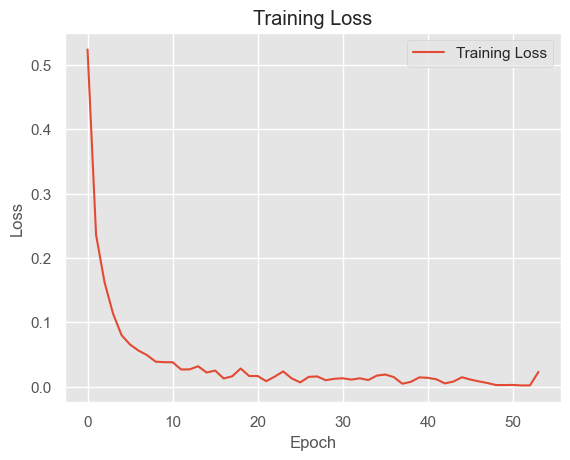

In [159]:
plot_loss(train_losses, val_losses)


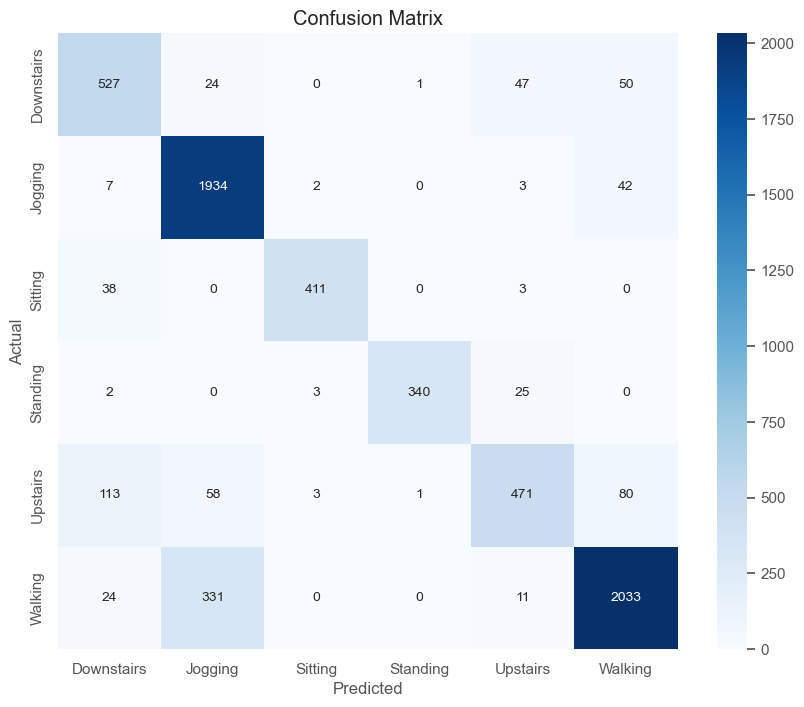

              precision    recall  f1-score   support

  Downstairs       0.74      0.81      0.78       649
     Jogging       0.82      0.97      0.89      1988
     Sitting       0.98      0.91      0.94       452
    Standing       0.99      0.92      0.96       370
    Upstairs       0.84      0.65      0.73       726
     Walking       0.92      0.85      0.88      2399

    accuracy                           0.87      6584
   macro avg       0.88      0.85      0.86      6584
weighted avg       0.87      0.87      0.87      6584



In [161]:
def evaluate_model(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to track gradients
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

device_eval = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model, device_eval, test_loader)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## Conv Model 2 (Optimized)

In [230]:
class AdjustedHARConvModel(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(AdjustedHARConvModel, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=n_sensors, out_channels=64, kernel_size=10)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=10)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=10)

        # Max Pooling
        self.pool = nn.MaxPool1d(kernel_size=3)

        # Adaptive Average Pooling
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        self.fc = nn.Linear(128, n_classes)


    def forward(self, x):
        # # Reshape the input to (batch_size, n_sensors, -1)
        # x = x.view(-1, self.n_sensors, x.size(1))
        actual_time_steps = x.size(-1) // self.n_sensors
        x = x.view(-1, self.n_sensors, actual_time_steps)

        # Convolutional layers with ReLU activations and pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Global average pooling and dropout
        x = self.adaptive_pool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = torch.flatten(x, 1)

        # Fully connected layer
        x = self.fc(x)

        # Output layer with log_softmax activation
        return F.log_softmax(x, dim=1)

In [231]:
cnn_2 = AdjustedHARConvModel(TIME_PERIODS, n_sensors, n_classes).to(device)
cnn_2

AdjustedHARConvModel(
  (conv1): Conv1d(3, 64, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(128, 128, kernel_size=(10,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [232]:
# Example usage
# cnn_2 = AdjustedHARConvModel(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_2 = torch.optim.Adam(cnn_2.parameters(), lr=0.001)

train_losses_cnn_2, train_accs_cnn_2, val_losses_cnn_2, val_accs_cnn_2 = train_and_validate_cnn(cnn_2, device, train_loader_64, test_loader_64, optimizer_cnn_2, criterion, num_epochs=200, patience=30)

Epoch 1/200 - Train Loss: 0.6056, Train Acc: 0.7800, Val Loss: 0.9882, Val Acc: 0.7524
Epoch 2/200 - Train Loss: 0.3159, Train Acc: 0.8786, Val Loss: 0.8670, Val Acc: 0.7840
Epoch 3/200 - Train Loss: 0.2507, Train Acc: 0.9043, Val Loss: 0.7448, Val Acc: 0.8056
Epoch 4/200 - Train Loss: 0.2053, Train Acc: 0.9241, Val Loss: 0.9525, Val Acc: 0.8126
Epoch 5/200 - Train Loss: 0.1681, Train Acc: 0.9435, Val Loss: 0.8852, Val Acc: 0.8139
Epoch 6/200 - Train Loss: 0.1436, Train Acc: 0.9518, Val Loss: 0.8746, Val Acc: 0.8228
Epoch 7/200 - Train Loss: 0.1254, Train Acc: 0.9592, Val Loss: 1.0307, Val Acc: 0.8291
Epoch 8/200 - Train Loss: 0.1081, Train Acc: 0.9653, Val Loss: 1.0989, Val Acc: 0.8332
Epoch 9/200 - Train Loss: 0.1019, Train Acc: 0.9673, Val Loss: 1.0535, Val Acc: 0.8247
Epoch 10/200 - Train Loss: 0.0951, Train Acc: 0.9699, Val Loss: 0.9909, Val Acc: 0.8314
Epoch 11/200 - Train Loss: 0.0812, Train Acc: 0.9750, Val Loss: 1.0968, Val Acc: 0.8384
Epoch 12/200 - Train Loss: 0.0723, Train 

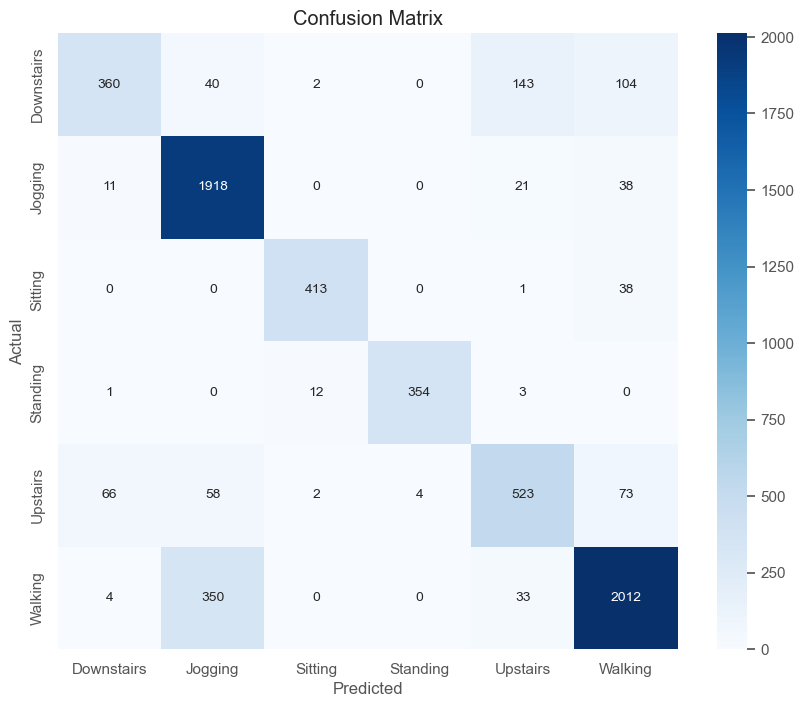

              precision    recall  f1-score   support

  Downstairs       0.81      0.55      0.66       649
     Jogging       0.81      0.96      0.88      1988
     Sitting       0.96      0.91      0.94       452
    Standing       0.99      0.96      0.97       370
    Upstairs       0.72      0.72      0.72       726
     Walking       0.89      0.84      0.86      2399

    accuracy                           0.85      6584
   macro avg       0.86      0.82      0.84      6584
weighted avg       0.85      0.85      0.84      6584



In [81]:
cnn_2.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(cnn_2, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## Kernel Size Smaller, same arch

In [89]:
class MyConvModelSmallerKernel(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModelSmallerKernel, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=n_sensors, out_channels=100, kernel_size=7)
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=7)
        self.conv3 = nn.Conv1d(in_channels=100, out_channels=160, kernel_size=7)
        self.conv4 = nn.Conv1d(in_channels=160, out_channels=160, kernel_size=7)

        # Max Pooling
        self.pool = nn.MaxPool1d(kernel_size=3)

        # Adaptive Average Pooling
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        self.fc = nn.Linear(160, n_classes)


    def forward(self, x):
        # # Reshape the input to (batch_size, n_sensors, -1)
        # x = x.view(-1, self.n_sensors, x.size(1))
        actual_time_steps = x.size(-1) // self.n_sensors
        x = x.view(-1, self.n_sensors, actual_time_steps)

        # Convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # Apply max pooling after the second conv layer
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # Global average pooling and dropout
        x = self.adaptive_pool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = torch.flatten(x, 1)

        # Fully connected layer
        x = self.fc(x)

        # Output layer with log_softmax activation
        return F.log_softmax(x, dim=1)

In [86]:
# Example usage
cnn_3 = MyConvModelSmallerKernel(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_3 = torch.optim.Adam(cnn_3.parameters(), lr=0.001)

train_losses_cnn_3, train_accs_cnn_3, val_losses_cnn_3, val_accs_cnn_3 = train_and_validate_cnn(cnn_3, device, train_loader_64, test_loader_64, optimizer_cnn_3, criterion, num_epochs=200, patience=50)

Epoch 1/200 - Train Loss: 0.5756, Train Acc: 0.7918, Val Loss: 0.7328, Val Acc: 0.7913
Epoch 2/200 - Train Loss: 0.2819, Train Acc: 0.8934, Val Loss: 0.5735, Val Acc: 0.8162
Epoch 3/200 - Train Loss: 0.1822, Train Acc: 0.9373, Val Loss: 0.7594, Val Acc: 0.8218
Epoch 4/200 - Train Loss: 0.1309, Train Acc: 0.9580, Val Loss: 0.7565, Val Acc: 0.8504
Epoch 5/200 - Train Loss: 0.1051, Train Acc: 0.9670, Val Loss: 0.6812, Val Acc: 0.8513
Epoch 6/200 - Train Loss: 0.0837, Train Acc: 0.9745, Val Loss: 0.5586, Val Acc: 0.8507
Epoch 7/200 - Train Loss: 0.0730, Train Acc: 0.9789, Val Loss: 0.6369, Val Acc: 0.8662
Epoch 8/200 - Train Loss: 0.0628, Train Acc: 0.9808, Val Loss: 0.8084, Val Acc: 0.8261
Epoch 9/200 - Train Loss: 0.0656, Train Acc: 0.9813, Val Loss: 0.6507, Val Acc: 0.8478
Epoch 10/200 - Train Loss: 0.0481, Train Acc: 0.9861, Val Loss: 1.1103, Val Acc: 0.7848
Epoch 11/200 - Train Loss: 0.0432, Train Acc: 0.9865, Val Loss: 0.6539, Val Acc: 0.8580
Epoch 12/200 - Train Loss: 0.0382, Train 

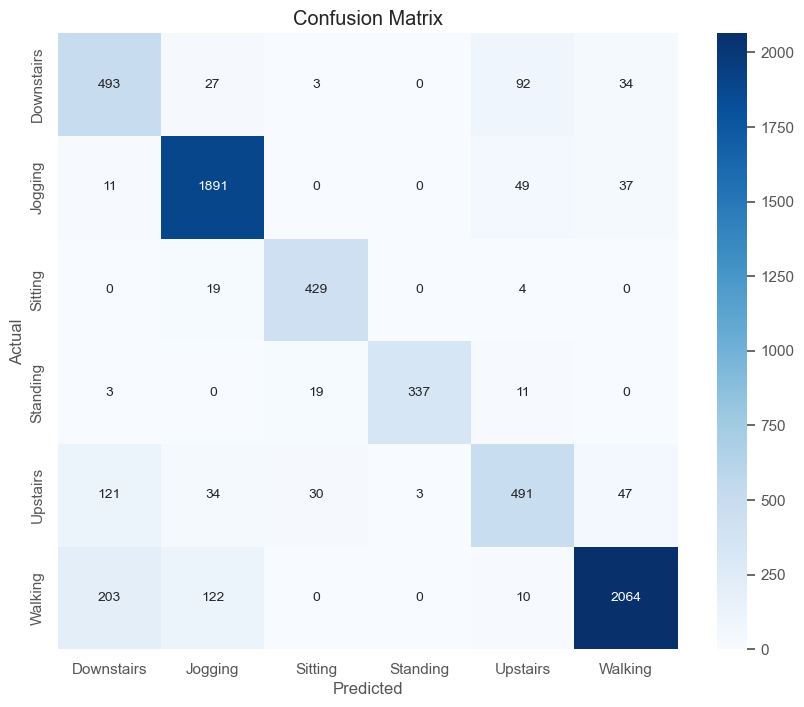

              precision    recall  f1-score   support

  Downstairs       0.59      0.76      0.67       649
     Jogging       0.90      0.95      0.93      1988
     Sitting       0.89      0.95      0.92       452
    Standing       0.99      0.91      0.95       370
    Upstairs       0.75      0.68      0.71       726
     Walking       0.95      0.86      0.90      2399

    accuracy                           0.87      6584
   macro avg       0.85      0.85      0.85      6584
weighted avg       0.88      0.87      0.87      6584



In [88]:
cnn_3.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(cnn_3, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## Smaller Kernels, smaller max pooling

In [116]:
class cnn_5(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(cnn_5, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=n_sensors, out_channels=64, kernel_size=7, stride=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, stride=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7, stride=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=7, stride=1)

        # Max Pooling
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Adaptive Average Pooling
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        self.fc = nn.Linear(256, n_classes)


    def forward(self, x):
        # # Reshape the input to (batch_size, n_sensors, -1)
        # x = x.view(-1, self.n_sensors, x.size(1))
        actual_time_steps = x.size(-1) // self.n_sensors
        x = x.view(-1, self.n_sensors, actual_time_steps)

        # Convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))

        # Global average pooling and dropout
        x = self.adaptive_pool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = torch.flatten(x, 1)

        # Fully connected layer
        x = self.fc(x)

        # Output layer with log_softmax activation
        return F.log_softmax(x, dim=1)

In [234]:
cnn_5_inst = cnn_5(TIME_PERIODS, n_sensors, n_classes).to(device)
cnn_5_inst

cnn_5(
  (conv1): Conv1d(3, 64, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(7,), stride=(1,))
  (conv3): Conv1d(128, 128, kernel_size=(7,), stride=(1,))
  (conv4): Conv1d(128, 256, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)

In [95]:
cnn_5 = cnn_5(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_5 = torch.optim.Adam(cnn_5.parameters(), lr=0.001)

train_losses_cnn_5, train_accs_cnn_5, val_losses_cnn_5, val_accs_cnn_5 = train_and_validate_cnn(cnn_5, device, train_loader_64, test_loader_64, optimizer_cnn_5, criterion, num_epochs=200, patience=50)

Epoch 1/200 - Train Loss: 0.6210, Train Acc: 0.7728, Val Loss: 0.7479, Val Acc: 0.7779
Epoch 2/200 - Train Loss: 0.3112, Train Acc: 0.8854, Val Loss: 0.6678, Val Acc: 0.8118
Epoch 3/200 - Train Loss: 0.2042, Train Acc: 0.9286, Val Loss: 0.7047, Val Acc: 0.7716
Epoch 4/200 - Train Loss: 0.1483, Train Acc: 0.9528, Val Loss: 0.5773, Val Acc: 0.8709
Epoch 5/200 - Train Loss: 0.1180, Train Acc: 0.9645, Val Loss: 0.5914, Val Acc: 0.8396
Epoch 6/200 - Train Loss: 0.1031, Train Acc: 0.9680, Val Loss: 0.7079, Val Acc: 0.8352
Epoch 7/200 - Train Loss: 0.0812, Train Acc: 0.9743, Val Loss: 0.5289, Val Acc: 0.8387
Epoch 8/200 - Train Loss: 0.0705, Train Acc: 0.9772, Val Loss: 0.5686, Val Acc: 0.8565
Epoch 9/200 - Train Loss: 0.0666, Train Acc: 0.9804, Val Loss: 0.5596, Val Acc: 0.8553
Epoch 10/200 - Train Loss: 0.0530, Train Acc: 0.9839, Val Loss: 0.6032, Val Acc: 0.8627
Epoch 11/200 - Train Loss: 0.0473, Train Acc: 0.9850, Val Loss: 0.5252, Val Acc: 0.8527
Epoch 12/200 - Train Loss: 0.0455, Train 

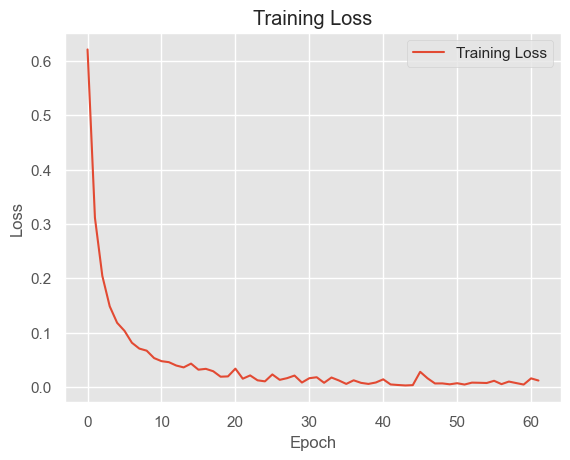

In [236]:
plot_loss(train_losses_cnn_5, val_losses_leaky_relu)

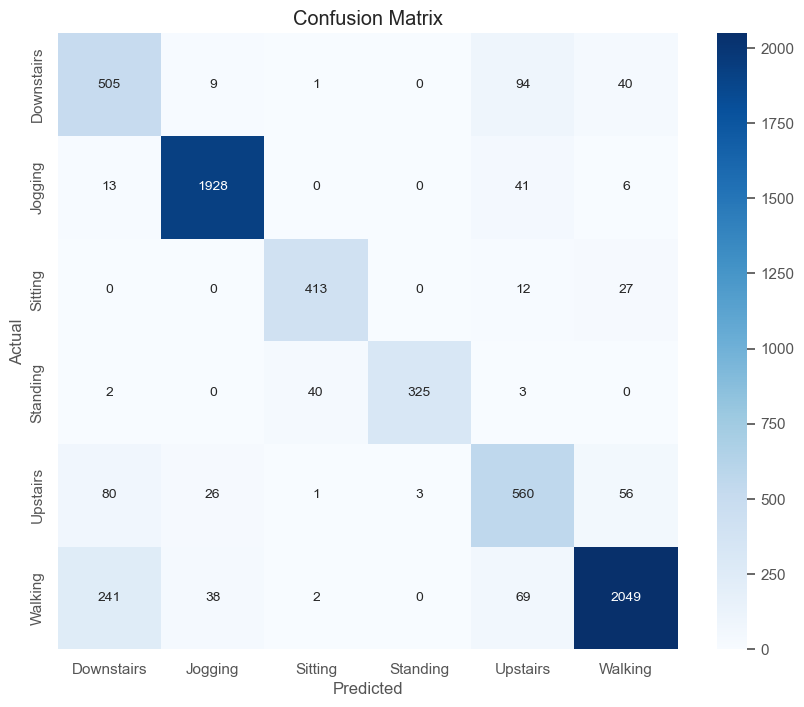

              precision    recall  f1-score   support

  Downstairs       0.60      0.78      0.68       649
     Jogging       0.96      0.97      0.97      1988
     Sitting       0.90      0.91      0.91       452
    Standing       0.99      0.88      0.93       370
    Upstairs       0.72      0.77      0.74       726
     Walking       0.94      0.85      0.90      2399

    accuracy                           0.88      6584
   macro avg       0.85      0.86      0.85      6584
weighted avg       0.89      0.88      0.88      6584



In [96]:
cnn_5.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(cnn_5, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

# Data Augmentaion

## Noise Addition

Adding Gaussian noise to your data simulates real-world sensor noise, making your model more robust to slight variations in input data.


Implementation: You can add Gaussian noise by simply adding randomly generated values from a normal distribution to your dataset. The magnitude of the noise can be controlled by adjusting the standard deviation (std_dev) of the distribution.

In [97]:
def add_gaussian_noise(data, mean=0.0, std_dev=0.05):
    """
    Adds Gaussian noise to the data.

    Parameters:
    - data: Input data (time series of sensor readings).
    - mean: Mean of the Gaussian noise distribution.
    - std_dev: Standard deviation of the Gaussian noise distribution.

    Returns:
    - Noisy data.
    """
    noise = torch.randn(data.size()) * std_dev + mean
    noisy_data = data + noise
    return noisy_data

In [107]:
x_train.std()

0.35254502

In [181]:
len(torch.cat((x_train_tensor, x_train_tensor)))

41736

In [182]:
len(x_train_tensor)

20868

In [184]:
# Create TensorDatasets
train_dataset_w_noise = TensorDataset(torch.cat((x_train_tensor, add_gaussian_noise(x_train_tensor))), torch.cat((y_train_tensor, y_train_tensor)))
# val_dataset_w_noise = TensorDataset(add_gaussian_noise(x_val_tensor), y_val_tensor)
# test_dataset_w_noise = TensorDataset(add_gaussian_noise(x_test_tensor), y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader_w_noise = DataLoader(train_dataset_w_noise, batch_size=batch_size, shuffle=True)
# test_loader_w_noise  = DataLoader(test_dataset_w_noise, batch_size=batch_size, shuffle=False)

## Best MLP with noise

In [112]:
# Assuming TIME_PERIODS and n_classes are defined
model_mlp_wide_w_noise = mlp_wide_with_droupout(TIME_PERIODS, n_classes)
model_mlp_wide_w_noise.to(device)

# Choose your Optimizer
optimizer_wide_w_noise = torch.optim.Adam(model_mlp_wide_w_noise.parameters())


In [113]:
train_losses_wide_w_noise, train_accs_wide_w_noise, val_losses_wide_w_noise, val_accs_wide_w_noise = train_and_validate_mlp(model_mlp_wide_w_noise, device,train_loader_w_noise, test_loader_64, optimizer_wide_w_noise, EPOCHS)

Epoch 1/500 - Train Loss: 0.7429, Train Acc: 0.7377, Val Loss: 0.6509, Val Acc: 0.7602
Epoch 2/500 - Train Loss: 0.4850, Train Acc: 0.8137, Val Loss: 0.6617, Val Acc: 0.7532
Epoch 3/500 - Train Loss: 0.4219, Train Acc: 0.8380, Val Loss: 0.6608, Val Acc: 0.7644
Epoch 4/500 - Train Loss: 0.3795, Train Acc: 0.8532, Val Loss: 0.7129, Val Acc: 0.7567
Epoch 5/500 - Train Loss: 0.3382, Train Acc: 0.8658, Val Loss: 0.7237, Val Acc: 0.7719
Epoch 6/500 - Train Loss: 0.3159, Train Acc: 0.8766, Val Loss: 0.6423, Val Acc: 0.7936
Epoch 7/500 - Train Loss: 0.2908, Train Acc: 0.8854, Val Loss: 0.7224, Val Acc: 0.7825
Epoch 8/500 - Train Loss: 0.2714, Train Acc: 0.8951, Val Loss: 0.6707, Val Acc: 0.7925
Epoch 9/500 - Train Loss: 0.2549, Train Acc: 0.9001, Val Loss: 0.6857, Val Acc: 0.8007
Epoch 10/500 - Train Loss: 0.2361, Train Acc: 0.9093, Val Loss: 0.6712, Val Acc: 0.8155
Epoch 11/500 - Train Loss: 0.2264, Train Acc: 0.9148, Val Loss: 0.7646, Val Acc: 0.7899
Epoch 12/500 - Train Loss: 0.2132, Train 

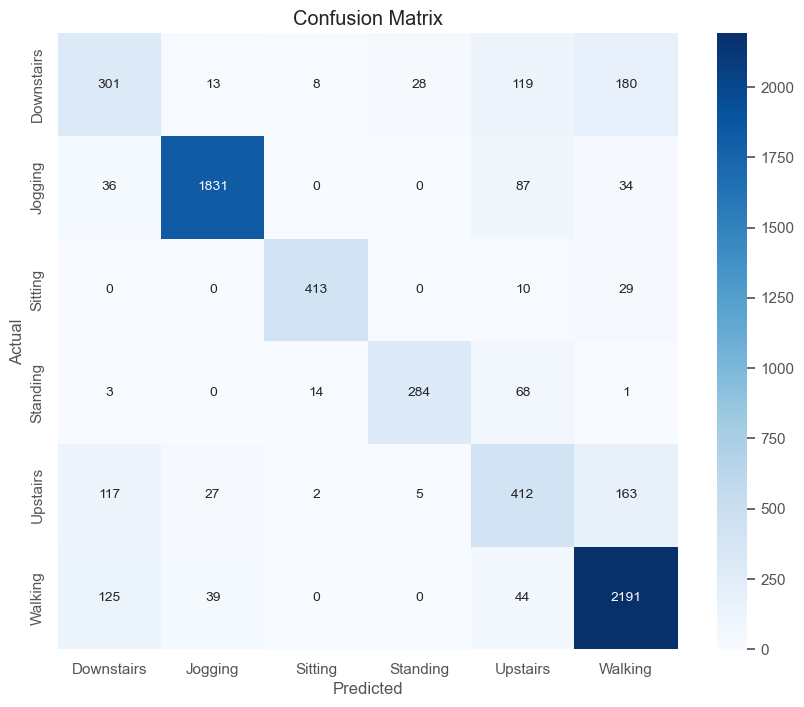

              precision    recall  f1-score   support

  Downstairs       0.52      0.46      0.49       649
     Jogging       0.96      0.92      0.94      1988
     Sitting       0.95      0.91      0.93       452
    Standing       0.90      0.77      0.83       370
    Upstairs       0.56      0.57      0.56       726
     Walking       0.84      0.91      0.88      2399

    accuracy                           0.83      6584
   macro avg       0.79      0.76      0.77      6584
weighted avg       0.82      0.83      0.82      6584



In [114]:
model_mlp_wide_w_noise.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp_wide_w_noise, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## Best CNN with noise

In [185]:
cnn_5_w_noise = cnn_5(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_5_w_noise = torch.optim.Adam(cnn_5_w_noise.parameters(), lr=0.001)

train_losses_cnn_5_w_noise, train_accs_cnn_5_w_noise, val_losses_cnn_5_w_noise, val_accs_cnn_5_w_noise = train_and_validate_cnn(cnn_5_w_noise, device, train_loader_w_noise, test_loader_64, optimizer_cnn_5_w_noise, criterion, num_epochs=200, patience=30)

Epoch 1/200 - Train Loss: 0.4269, Train Acc: 0.8433, Val Loss: 0.5330, Val Acc: 0.8398
Epoch 2/200 - Train Loss: 0.1573, Train Acc: 0.9478, Val Loss: 0.7482, Val Acc: 0.8273
Epoch 3/200 - Train Loss: 0.0993, Train Acc: 0.9689, Val Loss: 0.6638, Val Acc: 0.8425
Epoch 4/200 - Train Loss: 0.0731, Train Acc: 0.9776, Val Loss: 0.6185, Val Acc: 0.8455
Epoch 5/200 - Train Loss: 0.0543, Train Acc: 0.9831, Val Loss: 0.6701, Val Acc: 0.8466
Epoch 6/200 - Train Loss: 0.0421, Train Acc: 0.9871, Val Loss: 0.6401, Val Acc: 0.8536
Epoch 7/200 - Train Loss: 0.0374, Train Acc: 0.9881, Val Loss: 0.6251, Val Acc: 0.8694
Epoch 8/200 - Train Loss: 0.0315, Train Acc: 0.9904, Val Loss: 0.5832, Val Acc: 0.8530
Epoch 9/200 - Train Loss: 0.0263, Train Acc: 0.9921, Val Loss: 0.6162, Val Acc: 0.8776
Epoch 10/200 - Train Loss: 0.0219, Train Acc: 0.9930, Val Loss: 1.0053, Val Acc: 0.8565
Epoch 11/200 - Train Loss: 0.0178, Train Acc: 0.9948, Val Loss: 1.0238, Val Acc: 0.8267
Epoch 12/200 - Train Loss: 0.0208, Train 

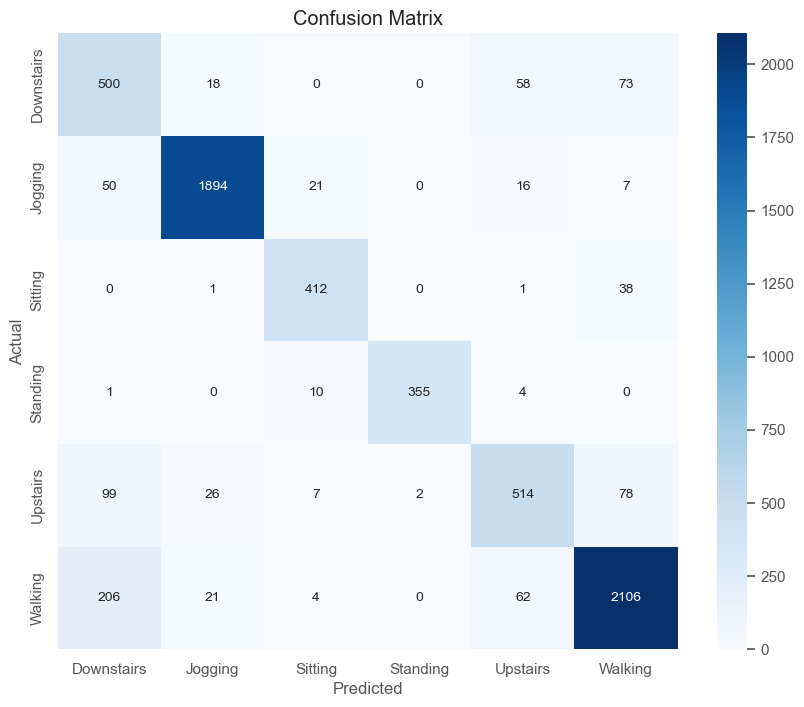

              precision    recall  f1-score   support

  Downstairs       0.58      0.77      0.66       649
     Jogging       0.97      0.95      0.96      1988
     Sitting       0.91      0.91      0.91       452
    Standing       0.99      0.96      0.98       370
    Upstairs       0.78      0.71      0.74       726
     Walking       0.91      0.88      0.90      2399

    accuracy                           0.88      6584
   macro avg       0.86      0.86      0.86      6584
weighted avg       0.89      0.88      0.88      6584



In [187]:
cnn_5_w_noise.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(cnn_5_w_noise, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

# Time Shifting

Time shifting simulates the effect of time lags, which can occur due to sensor delays or data processing lags, by shifting the data points in time.

Implementation: You can implement time shifting by rolling the data array along the time axis. The direction (forward or backward) and magnitude of the shift can be adjusted as needed.

In [122]:
def time_shift(data, shift, fill_value=0):
    """
    Shifts the data in time.

    Parameters:
    - data: Input data (time series of sensor readings).
    - shift: Number of time steps to shift the data. Positive for forward shift, negative for backward shift.
    - fill_value: Value used to fill the empty positions created by the shift.

    Returns:
    - Shifted data.
    """
    shifted_data = torch.roll(data, shifts=shift, dims=-1)
    if shift > 0:
        shifted_data[..., :shift] = fill_value
    else:
        shifted_data[..., shift:] = fill_value
    return shifted_data


## Best MLP with time shift

In [199]:
# Create TensorDatasets
shift = torch.randint(low=-5, high=6, size=(1,)).item()  # Random shift between -5 and 5
train_dataset_w_shift = TensorDataset(torch.cat((x_train_tensor,time_shift(x_train_tensor, shift))), torch.cat((y_train_tensor,y_train_tensor)))
# val_dataset_w_noise = TensorDataset(add_gaussian_noise(x_val_tensor), y_val_tensor)
# test_dataset_w_noise = TensorDataset(add_gaussian_noise(x_test_tensor), y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader_w_time_shift = DataLoader(train_dataset_w_shift, batch_size=batch_size, shuffle=True)
# test_loader_w_noise  = DataLoader(test_dataset_w_noise, batch_size=batch_size, shuffle=False)

In [204]:
# Assuming TIME_PERIODS and n_classes are defined
model_mlp_wide_w_shift = mlp_wide_with_droupout(TIME_PERIODS, n_classes)
model_mlp_wide_w_shift.to(device)

# Choose your Optimizer
optimizer_wide_w_shift = torch.optim.Adam(model_mlp_wide_w_shift.parameters())

In [205]:
train_losses_wide_w_shift, train_accs_wide_w_shift, val_losses_wide_w_shift, val_accs_wide_w_shift = train_and_validate_mlp(model_mlp_wide_w_shift, device,train_loader_w_time_shift, test_loader_64, optimizer_wide_w_shift, EPOCHS, patience=25)

Epoch 1/500 - Train Loss: 0.6050, Train Acc: 0.7795, Val Loss: 0.6289, Val Acc: 0.7635
Epoch 2/500 - Train Loss: 0.4026, Train Acc: 0.8441, Val Loss: 0.6552, Val Acc: 0.7587
Epoch 3/500 - Train Loss: 0.3497, Train Acc: 0.8648, Val Loss: 0.6344, Val Acc: 0.7860
Epoch 4/500 - Train Loss: 0.3092, Train Acc: 0.8826, Val Loss: 0.6022, Val Acc: 0.7965
Epoch 5/500 - Train Loss: 0.2781, Train Acc: 0.8923, Val Loss: 0.6905, Val Acc: 0.8003
Epoch 6/500 - Train Loss: 0.2566, Train Acc: 0.9024, Val Loss: 0.6276, Val Acc: 0.8138
Epoch 7/500 - Train Loss: 0.2364, Train Acc: 0.9118, Val Loss: 0.6544, Val Acc: 0.8159
Epoch 8/500 - Train Loss: 0.2186, Train Acc: 0.9184, Val Loss: 0.6716, Val Acc: 0.8152
Epoch 9/500 - Train Loss: 0.2062, Train Acc: 0.9233, Val Loss: 0.6913, Val Acc: 0.8310
Epoch 10/500 - Train Loss: 0.1954, Train Acc: 0.9279, Val Loss: 0.7723, Val Acc: 0.8127
Epoch 11/500 - Train Loss: 0.1856, Train Acc: 0.9317, Val Loss: 0.7106, Val Acc: 0.8202
Epoch 12/500 - Train Loss: 0.1737, Train 

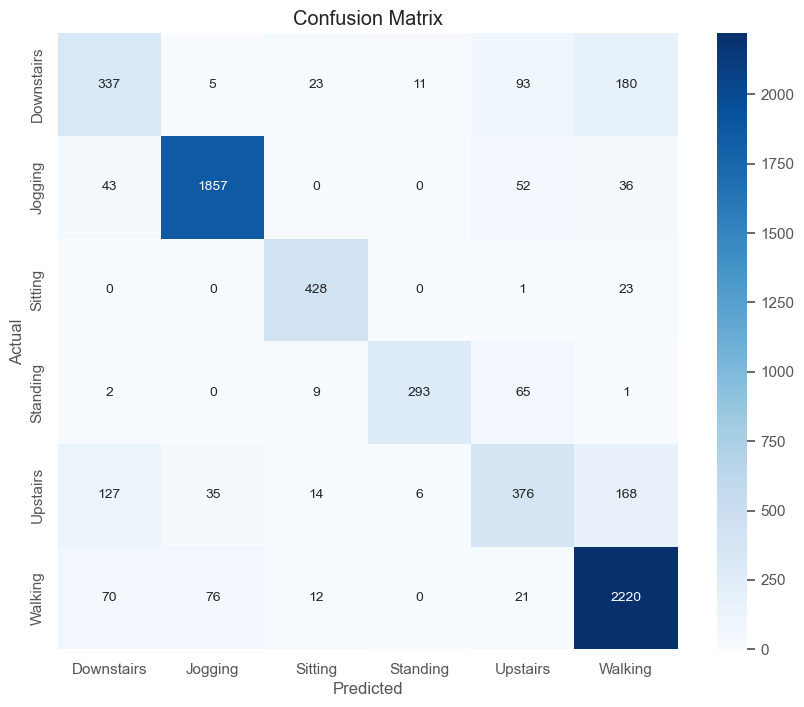

              precision    recall  f1-score   support

  Downstairs       0.58      0.52      0.55       649
     Jogging       0.94      0.93      0.94      1988
     Sitting       0.88      0.95      0.91       452
    Standing       0.95      0.79      0.86       370
    Upstairs       0.62      0.52      0.56       726
     Walking       0.84      0.93      0.88      2399

    accuracy                           0.84      6584
   macro avg       0.80      0.77      0.78      6584
weighted avg       0.83      0.84      0.83      6584



In [237]:
model_mlp_wide_w_shift.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp_wide_w_shift, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## Best CNN with time shift

In [207]:
cnn_5_w_shift = cnn_5(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_5_w_shift = torch.optim.Adam(cnn_5_w_shift.parameters(), lr=0.001)

train_losses_cnn_5_w_shift, train_accs_cnn_5_w_shift, val_losses_cnn_5_w_shift, val_accs_cnn_5_w_shift = train_and_validate_cnn(cnn_5_w_shift, device, train_loader_w_time_shift, test_loader_64, optimizer_cnn_5_w_shift, criterion, num_epochs=200, patience=30)

Epoch 1/200 - Train Loss: 0.4439, Train Acc: 0.8368, Val Loss: 0.8871, Val Acc: 0.7840
Epoch 2/200 - Train Loss: 0.1758, Train Acc: 0.9390, Val Loss: 0.7711, Val Acc: 0.8344
Epoch 3/200 - Train Loss: 0.1127, Train Acc: 0.9644, Val Loss: 0.6766, Val Acc: 0.8416
Epoch 4/200 - Train Loss: 0.0829, Train Acc: 0.9745, Val Loss: 0.4978, Val Acc: 0.8537
Epoch 5/200 - Train Loss: 0.0614, Train Acc: 0.9809, Val Loss: 0.5862, Val Acc: 0.8524
Epoch 6/200 - Train Loss: 0.0520, Train Acc: 0.9842, Val Loss: 0.7899, Val Acc: 0.8231
Epoch 7/200 - Train Loss: 0.0506, Train Acc: 0.9856, Val Loss: 0.5723, Val Acc: 0.8776
Epoch 8/200 - Train Loss: 0.0339, Train Acc: 0.9902, Val Loss: 0.6198, Val Acc: 0.8642
Epoch 9/200 - Train Loss: 0.0308, Train Acc: 0.9903, Val Loss: 0.5951, Val Acc: 0.8601
Epoch 10/200 - Train Loss: 0.0251, Train Acc: 0.9919, Val Loss: 0.8677, Val Acc: 0.8627
Epoch 11/200 - Train Loss: 0.0251, Train Acc: 0.9919, Val Loss: 0.7681, Val Acc: 0.8733
Epoch 12/200 - Train Loss: 0.0210, Train 

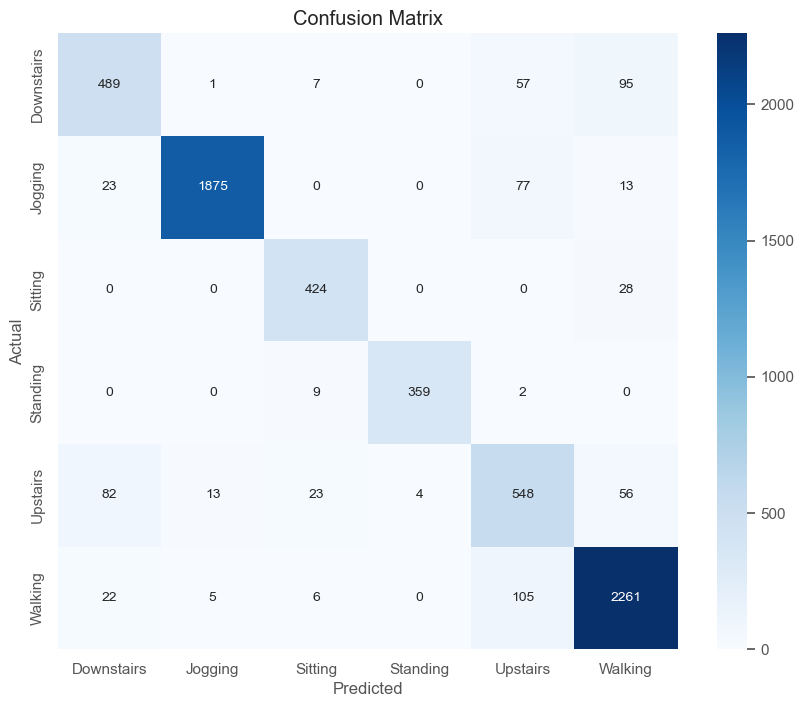

              precision    recall  f1-score   support

  Downstairs       0.79      0.75      0.77       649
     Jogging       0.99      0.94      0.97      1988
     Sitting       0.90      0.94      0.92       452
    Standing       0.99      0.97      0.98       370
    Upstairs       0.69      0.75      0.72       726
     Walking       0.92      0.94      0.93      2399

    accuracy                           0.90      6584
   macro avg       0.88      0.88      0.88      6584
weighted avg       0.91      0.90      0.91      6584



In [208]:
cnn_5_w_shift.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(cnn_5_w_shift, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## Data Scaling

In [240]:
train_dataset_w_scaling = TensorDataset(torch.cat((x_train_tensor, x_train_tensor*1.5)), torch.cat((y_train_tensor,y_train_tensor)))
# val_dataset_w_noise = TensorDataset(add_gaussian_noise(x_val_tensor), y_val_tensor)
# test_dataset_w_noise = TensorDataset(add_gaussian_noise(x_test_tensor), y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader_w_scaling = DataLoader(train_dataset_w_shift, batch_size=batch_size, shuffle=True)

### MLP with scaling

In [241]:
# Assuming TIME_PERIODS and n_classes are defined
model_mlp_wide_w_scale = mlp_wide_with_droupout(TIME_PERIODS, n_classes)
model_mlp_wide_w_scale.to(device)

# Choose your Optimizer
optimizer_wide_w_scale = torch.optim.Adam(model_mlp_wide_w_scale.parameters())

In [242]:

train_losses_wide_w_scale, train_accs_wide_w_scale, val_losses_wide_w_scale, val_accs_wide_w_scale = train_and_validate_mlp(model_mlp_wide_w_scale, device,train_loader_w_scaling, test_loader_64, optimizer_wide_w_scale, EPOCHS, patience=30)

Epoch 1/500 - Train Loss: 0.6038, Train Acc: 0.7824, Val Loss: 0.6952, Val Acc: 0.7441
Epoch 2/500 - Train Loss: 0.4028, Train Acc: 0.8444, Val Loss: 0.5837, Val Acc: 0.8009
Epoch 3/500 - Train Loss: 0.3496, Train Acc: 0.8629, Val Loss: 0.5659, Val Acc: 0.8067
Epoch 4/500 - Train Loss: 0.3132, Train Acc: 0.8770, Val Loss: 0.6347, Val Acc: 0.7919
Epoch 5/500 - Train Loss: 0.2835, Train Acc: 0.8905, Val Loss: 0.6906, Val Acc: 0.7977
Epoch 6/500 - Train Loss: 0.2580, Train Acc: 0.9013, Val Loss: 0.6233, Val Acc: 0.8124
Epoch 7/500 - Train Loss: 0.2439, Train Acc: 0.9091, Val Loss: 0.6742, Val Acc: 0.8164
Epoch 8/500 - Train Loss: 0.2217, Train Acc: 0.9155, Val Loss: 0.7681, Val Acc: 0.8033
Epoch 9/500 - Train Loss: 0.2164, Train Acc: 0.9185, Val Loss: 0.6782, Val Acc: 0.8199
Epoch 10/500 - Train Loss: 0.1966, Train Acc: 0.9273, Val Loss: 0.7777, Val Acc: 0.8118
Epoch 11/500 - Train Loss: 0.1893, Train Acc: 0.9314, Val Loss: 0.7682, Val Acc: 0.8335
Epoch 12/500 - Train Loss: 0.1794, Train 

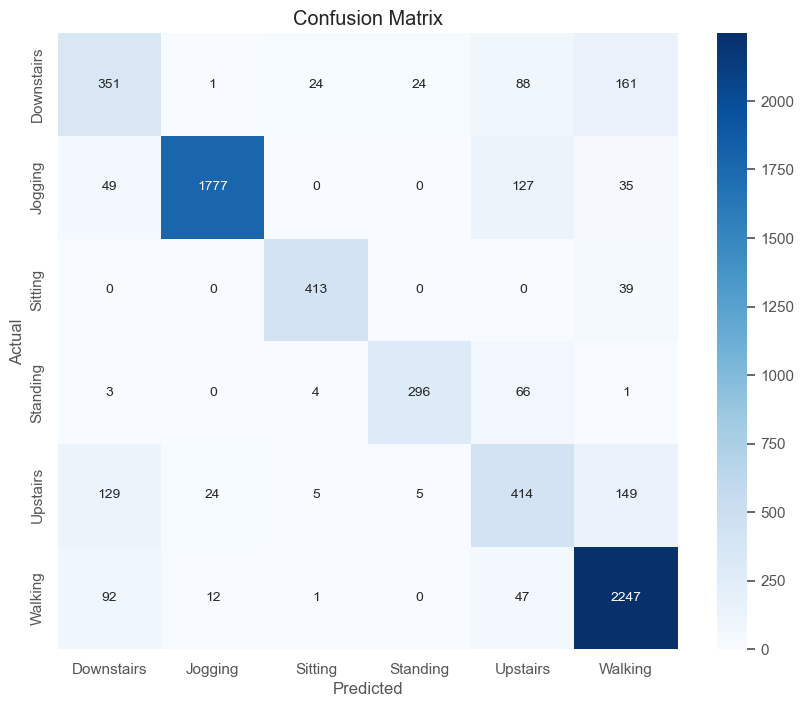

              precision    recall  f1-score   support

  Downstairs       0.56      0.54      0.55       649
     Jogging       0.98      0.89      0.93      1988
     Sitting       0.92      0.91      0.92       452
    Standing       0.91      0.80      0.85       370
    Upstairs       0.56      0.57      0.56       726
     Walking       0.85      0.94      0.89      2399

    accuracy                           0.84      6584
   macro avg       0.80      0.78      0.79      6584
weighted avg       0.84      0.84      0.84      6584



In [243]:
model_mlp_wide_w_scale.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp_wide_w_scale, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

### CNN with Scale

In [244]:
cnn_5_w_scale = cnn_5(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_5_w_scale = torch.optim.Adam(cnn_5_w_scale.parameters(), lr=0.001)

train_losses_cnn_5_w_scale, train_accs_cnn_5_w_scale, val_losses_cnn_5_w_scale, val_accs_cnn_5_w_scale = train_and_validate_cnn(cnn_5_w_scale, device, train_loader_w_scaling, test_loader_64, optimizer_cnn_5_w_scale, criterion, num_epochs=200, patience=25)

Epoch 1/200 - Train Loss: 0.4372, Train Acc: 0.8413, Val Loss: 0.7650, Val Acc: 0.8296
Epoch 2/200 - Train Loss: 0.1568, Train Acc: 0.9476, Val Loss: 0.7411, Val Acc: 0.8448
Epoch 3/200 - Train Loss: 0.0977, Train Acc: 0.9701, Val Loss: 0.7738, Val Acc: 0.8531
Epoch 4/200 - Train Loss: 0.0714, Train Acc: 0.9781, Val Loss: 0.7571, Val Acc: 0.8613
Epoch 5/200 - Train Loss: 0.0586, Train Acc: 0.9827, Val Loss: 0.6441, Val Acc: 0.8651
Epoch 6/200 - Train Loss: 0.0455, Train Acc: 0.9867, Val Loss: 0.5576, Val Acc: 0.8762
Epoch 7/200 - Train Loss: 0.0378, Train Acc: 0.9887, Val Loss: 1.2227, Val Acc: 0.8700
Epoch 8/200 - Train Loss: 0.0357, Train Acc: 0.9891, Val Loss: 0.4710, Val Acc: 0.8954
Epoch 9/200 - Train Loss: 0.0259, Train Acc: 0.9920, Val Loss: 1.0275, Val Acc: 0.8536
Epoch 10/200 - Train Loss: 0.0266, Train Acc: 0.9921, Val Loss: 1.0464, Val Acc: 0.8548
Epoch 11/200 - Train Loss: 0.0220, Train Acc: 0.9932, Val Loss: 0.9657, Val Acc: 0.8748
Epoch 12/200 - Train Loss: 0.0224, Train 

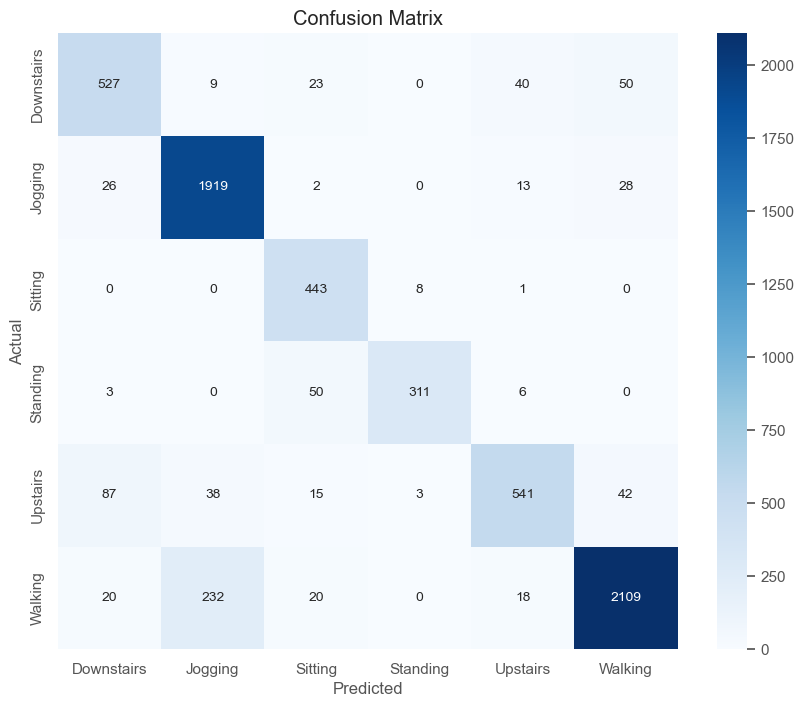

              precision    recall  f1-score   support

  Downstairs       0.79      0.81      0.80       649
     Jogging       0.87      0.97      0.92      1988
     Sitting       0.80      0.98      0.88       452
    Standing       0.97      0.84      0.90       370
    Upstairs       0.87      0.75      0.80       726
     Walking       0.95      0.88      0.91      2399

    accuracy                           0.89      6584
   macro avg       0.88      0.87      0.87      6584
weighted avg       0.89      0.89      0.89      6584



In [245]:
cnn_5_w_scale.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(cnn_5_w_scale, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

In [246]:
cnn_5_w_scale = cnn_5(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_5_w_scale = torch.optim.Adam(cnn_5_w_scale.parameters(), lr=0.001)

train_losses_cnn_5_w_scale, train_accs_cnn_5_w_scale, val_losses_cnn_5_w_scale, val_accs_cnn_5_w_scale = train_and_validate_cnn(cnn_5_w_scale, device, train_loader_w_scaling, test_loader_64, optimizer_cnn_5_w_scale, criterion, num_epochs=200, patience=25)

Epoch 1/200 - Train Loss: 0.4329, Train Acc: 0.8397, Val Loss: 0.5320, Val Acc: 0.8307
Epoch 2/200 - Train Loss: 0.1619, Train Acc: 0.9455, Val Loss: 0.5600, Val Acc: 0.8463
Epoch 3/200 - Train Loss: 0.1033, Train Acc: 0.9682, Val Loss: 0.5868, Val Acc: 0.8565
Epoch 4/200 - Train Loss: 0.0784, Train Acc: 0.9760, Val Loss: 0.6915, Val Acc: 0.8613
Epoch 5/200 - Train Loss: 0.0606, Train Acc: 0.9819, Val Loss: 0.6325, Val Acc: 0.8553
Epoch 6/200 - Train Loss: 0.0491, Train Acc: 0.9853, Val Loss: 0.8099, Val Acc: 0.8489
Epoch 7/200 - Train Loss: 0.0388, Train Acc: 0.9878, Val Loss: 0.7672, Val Acc: 0.8671
Epoch 8/200 - Train Loss: 0.0323, Train Acc: 0.9903, Val Loss: 0.8468, Val Acc: 0.8688
Epoch 9/200 - Train Loss: 0.0325, Train Acc: 0.9899, Val Loss: 0.7838, Val Acc: 0.8575
Epoch 10/200 - Train Loss: 0.0264, Train Acc: 0.9920, Val Loss: 0.9437, Val Acc: 0.8577
Epoch 11/200 - Train Loss: 0.0209, Train Acc: 0.9938, Val Loss: 0.8767, Val Acc: 0.8676
Epoch 12/200 - Train Loss: 0.0210, Train 

# 500 EPOCHS

## MLP

In [255]:
# Assuming TIME_PERIODS and n_classes are defined
model_mlp_wide_500 = mlp_wide_with_droupout(TIME_PERIODS, n_classes)
model_mlp_wide_500.to(device)

# Choose your Optimizer
optimizer_wide_500  = torch.optim.Adam(model_mlp_wide_500.parameters()) 

In [256]:
train_losses_wide_500, train_accs_wide_500, val_losses_wide_500, val_accs_wide_500 = train_and_validate_mlp(model_mlp_wide_500, device,train_loader_64, test_loader_64, optimizer_wide_500, 500, 500)

Epoch 1/500 - Train Loss: 0.7358, Train Acc: 0.7430, Val Loss: 0.6360, Val Acc: 0.7681
Epoch 2/500 - Train Loss: 0.4655, Train Acc: 0.8244, Val Loss: 0.6184, Val Acc: 0.7725
Epoch 3/500 - Train Loss: 0.4043, Train Acc: 0.8433, Val Loss: 0.6645, Val Acc: 0.7617
Epoch 4/500 - Train Loss: 0.3648, Train Acc: 0.8583, Val Loss: 0.7035, Val Acc: 0.7681
Epoch 5/500 - Train Loss: 0.3330, Train Acc: 0.8671, Val Loss: 0.5966, Val Acc: 0.7994
Epoch 6/500 - Train Loss: 0.3074, Train Acc: 0.8771, Val Loss: 0.7261, Val Acc: 0.7629
Epoch 7/500 - Train Loss: 0.2963, Train Acc: 0.8840, Val Loss: 0.6743, Val Acc: 0.7880
Epoch 8/500 - Train Loss: 0.2728, Train Acc: 0.8953, Val Loss: 0.6465, Val Acc: 0.8047
Epoch 9/500 - Train Loss: 0.2500, Train Acc: 0.9013, Val Loss: 0.6475, Val Acc: 0.8142
Epoch 10/500 - Train Loss: 0.2355, Train Acc: 0.9103, Val Loss: 0.7167, Val Acc: 0.7966
Epoch 11/500 - Train Loss: 0.2221, Train Acc: 0.9144, Val Loss: 0.8241, Val Acc: 0.7872
Epoch 12/500 - Train Loss: 0.2051, Train 

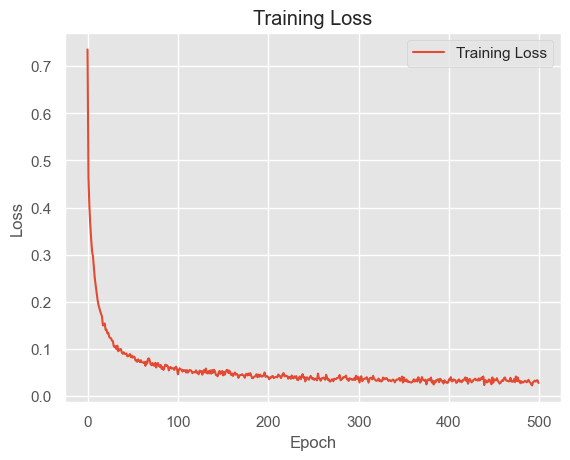

In [257]:
plot_loss(train_losses_wide_500, val_losses_wide)

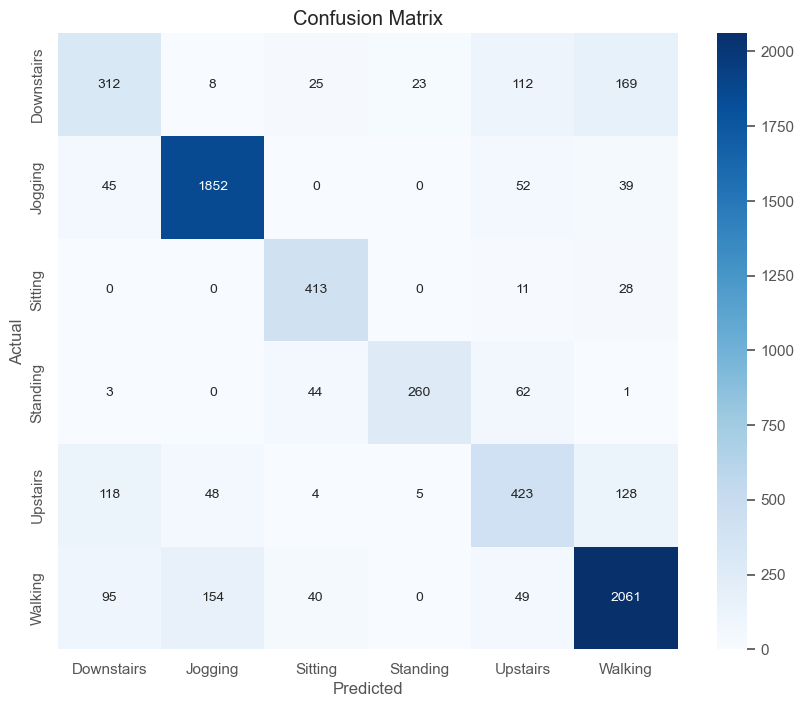

              precision    recall  f1-score   support

  Downstairs       0.54      0.48      0.51       649
     Jogging       0.90      0.93      0.91      1988
     Sitting       0.79      0.91      0.84       452
    Standing       0.90      0.70      0.79       370
    Upstairs       0.60      0.58      0.59       726
     Walking       0.85      0.86      0.85      2399

    accuracy                           0.81      6584
   macro avg       0.76      0.75      0.75      6584
weighted avg       0.80      0.81      0.81      6584



In [258]:
model_mlp_wide_500.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp_wide_500, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## CNN

In [259]:
cnn_500 = cnn_5(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_500 = torch.optim.Adam(cnn_500.parameters(), lr=0.001)

train_losses_cnn_500, train_accs_cnn_500, val_losses_cnn_500, val_accs_cnn_500 = train_and_validate_cnn(cnn_500, device, train_loader_64, test_loader_64, optimizer_cnn_500, criterion, num_epochs=500, patience=500)

Epoch 1/500 - Train Loss: 0.5806, Train Acc: 0.7922, Val Loss: 0.7248, Val Acc: 0.7773
Epoch 2/500 - Train Loss: 0.2808, Train Acc: 0.8992, Val Loss: 0.6820, Val Acc: 0.8307
Epoch 3/500 - Train Loss: 0.1874, Train Acc: 0.9356, Val Loss: 0.5197, Val Acc: 0.8483
Epoch 4/500 - Train Loss: 0.1292, Train Acc: 0.9582, Val Loss: 0.5346, Val Acc: 0.8638
Epoch 5/500 - Train Loss: 0.1085, Train Acc: 0.9652, Val Loss: 0.6249, Val Acc: 0.8352
Epoch 6/500 - Train Loss: 0.0893, Train Acc: 0.9736, Val Loss: 0.4787, Val Acc: 0.8509
Epoch 7/500 - Train Loss: 0.0799, Train Acc: 0.9745, Val Loss: 0.5448, Val Acc: 0.8543
Epoch 8/500 - Train Loss: 0.0681, Train Acc: 0.9799, Val Loss: 0.5667, Val Acc: 0.8648
Epoch 9/500 - Train Loss: 0.0592, Train Acc: 0.9815, Val Loss: 0.6738, Val Acc: 0.8484
Epoch 10/500 - Train Loss: 0.0595, Train Acc: 0.9826, Val Loss: 0.6672, Val Acc: 0.8679
Epoch 11/500 - Train Loss: 0.0502, Train Acc: 0.9839, Val Loss: 0.4760, Val Acc: 0.8641
Epoch 12/500 - Train Loss: 0.0390, Train 

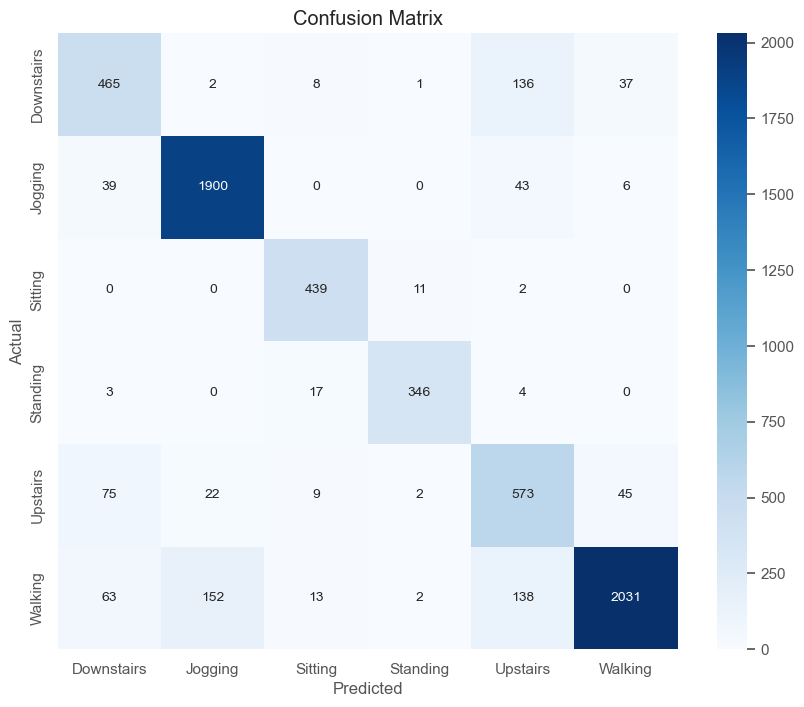

              precision    recall  f1-score   support

  Downstairs       0.72      0.72      0.72       649
     Jogging       0.92      0.96      0.94      1988
     Sitting       0.90      0.97      0.94       452
    Standing       0.96      0.94      0.95       370
    Upstairs       0.64      0.79      0.71       726
     Walking       0.96      0.85      0.90      2399

    accuracy                           0.87      6584
   macro avg       0.85      0.87      0.86      6584
weighted avg       0.88      0.87      0.88      6584



In [260]:
cnn_500.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(cnn_500, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

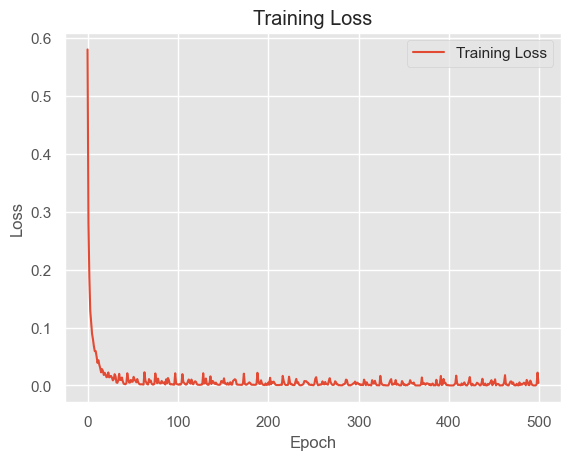

In [261]:
plot_loss(train_losses_cnn_500, val_losses_wide)

# Batch Normaliaztion

In [265]:
class cnn_w_batch_norm(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(cnn_w_batch_norm, self).__init__()  # Corrected the class name to match the defined class
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=n_sensors, out_channels=64, kernel_size=7, stride=1)
        self.bn1 = nn.BatchNorm1d(64)  # Batch normalization layer for conv1
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, stride=1)
        self.bn2 = nn.BatchNorm1d(128)  # Batch normalization layer for conv2
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7, stride=1)
        self.bn3 = nn.BatchNorm1d(128)  # Batch normalization layer for conv3
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=7, stride=1)
        self.bn4 = nn.BatchNorm1d(256)  # Batch normalization layer for conv4

        # Max Pooling
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Adaptive Average Pooling
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        self.fc = nn.Linear(256, n_classes)

    def forward(self, x):
        actual_time_steps = x.size(-1) // self.n_sensors
        x = x.view(-1, self.n_sensors, actual_time_steps)
        # Convolutional layers with BatchNorm and ReLU activations
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        x = self.pool(x)
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = self.bn3(self.conv3(x))
        x = F.relu(x)
        x = self.pool(x)
        x = self.bn4(self.conv4(x))
        x = F.relu(x)

        # Global average pooling and dropout
        x = self.adaptive_pool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = torch.flatten(x, 1)

        # Fully connected layer and output
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [266]:
cnn_batch_norm = cnn_w_batch_norm(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_batch_norm = torch.optim.Adam(cnn_batch_norm.parameters(), lr=0.001)

train_losses_cnn_batch_norm, train_accs_cnn_batch_norm, val_losses_cnn_batch_norm, val_accs_cnn_batch_norm = train_and_validate_cnn(cnn_batch_norm, device, train_loader_64, test_loader_64, optimizer_cnn_batch_norm, criterion, EPOCHS, patience=30)
        

Epoch 1/500 - Train Loss: 0.2909, Train Acc: 0.9014, Val Loss: 0.5625, Val Acc: 0.8206
Epoch 2/500 - Train Loss: 0.1357, Train Acc: 0.9568, Val Loss: 0.5967, Val Acc: 0.8671
Epoch 3/500 - Train Loss: 0.1122, Train Acc: 0.9630, Val Loss: 0.2816, Val Acc: 0.9303
Epoch 4/500 - Train Loss: 0.0801, Train Acc: 0.9742, Val Loss: 0.3356, Val Acc: 0.9039
Epoch 5/500 - Train Loss: 0.0731, Train Acc: 0.9768, Val Loss: 0.6082, Val Acc: 0.8300
Epoch 6/500 - Train Loss: 0.0614, Train Acc: 0.9814, Val Loss: 0.4264, Val Acc: 0.8718
Epoch 7/500 - Train Loss: 0.0505, Train Acc: 0.9844, Val Loss: 0.5290, Val Acc: 0.8571
Epoch 8/500 - Train Loss: 0.0728, Train Acc: 0.9764, Val Loss: 0.4719, Val Acc: 0.8598
Epoch 9/500 - Train Loss: 0.0435, Train Acc: 0.9867, Val Loss: 0.4290, Val Acc: 0.8981
Epoch 10/500 - Train Loss: 0.0345, Train Acc: 0.9895, Val Loss: 0.4550, Val Acc: 0.8764
Epoch 11/500 - Train Loss: 0.0552, Train Acc: 0.9834, Val Loss: 0.5694, Val Acc: 0.8908
Epoch 12/500 - Train Loss: 0.0583, Train 

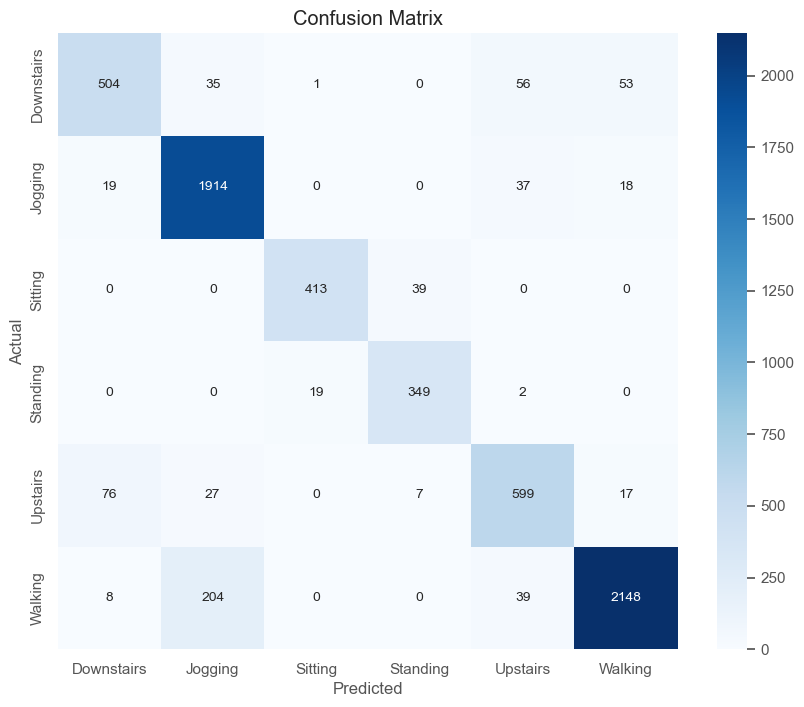

              precision    recall  f1-score   support

  Downstairs       0.83      0.78      0.80       649
     Jogging       0.88      0.96      0.92      1988
     Sitting       0.95      0.91      0.93       452
    Standing       0.88      0.94      0.91       370
    Upstairs       0.82      0.83      0.82       726
     Walking       0.96      0.90      0.93      2399

    accuracy                           0.90      6584
   macro avg       0.89      0.89      0.89      6584
weighted avg       0.90      0.90      0.90      6584



In [267]:
cnn_batch_norm.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(cnn_batch_norm, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

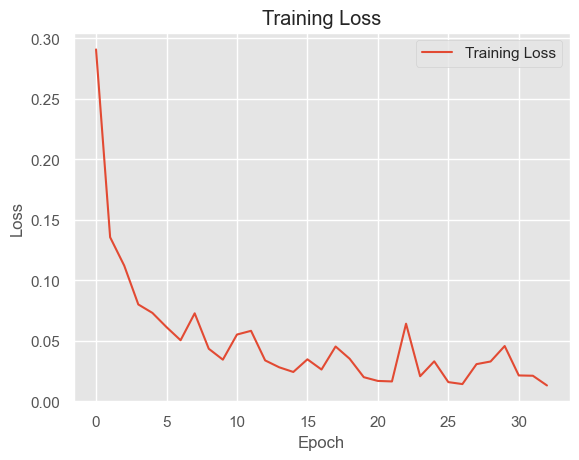

In [268]:
plot_loss(train_losses_cnn_batch_norm, val_losses_wide)

# Layer Normalization

In [282]:
class cnn_layer_norm(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(cnn_layer_norm, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=n_sensors, out_channels=64, kernel_size=7, stride=1)
        self.ln1 = nn.LayerNorm([64, self.calculate_new_length(time_periods, 7, 1)])
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, stride=1)
        self.ln2 = nn.LayerNorm([128, self.calculate_new_length(time_periods, 7, 2, previous_layers=1)])
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7, stride=1)
        self.ln3 = nn.LayerNorm([128, self.calculate_new_length(time_periods, 7, 2, previous_layers=2)])
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=7, stride=1)
        self.ln4 = nn.LayerNorm([256, self.calculate_new_length(time_periods, 7, 2, previous_layers=3)])

        # Max Pooling
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Adaptive Average Pooling
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        self.fc = nn.Linear(256, n_classes)

    def forward(self, x):
        actual_time_steps = x.size(-1) // self.n_sensors
        x = x.view(-1, self.n_sensors, actual_time_steps)
        x = self.conv1(x)
        x = self.ln1(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.ln2(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = F.relu(x)
        
        x = self.conv3(x)
        x = self.ln3(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = self.ln4(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = F.relu(x)

        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def calculate_new_length(self, length, kernel_size, pool_size, previous_layers=0):
        """
        Calculate the new length of the sequence after applying
        convolutional and pooling layers.
        """
        for _ in range(previous_layers):
            length = length - (kernel_size - 1)  # Convolutional layer
            length = length // pool_size  # Pooling layer
        return length

In [284]:
# cnn_layer_norm = cnn_layer_norm(TIME_PERIODS, n_sensors, n_classes).to(device)
# optimizer_cnn_layer_norm = torch.optim.Adam(cnn_layer_norm.parameters(), lr=0.001)

# train_losses_cnn_layer_norm, train_accs_cnn_layer_norm, val_losses_cnn_layer_norm, val_accs_cnn_layer_norm = train_and_validate_cnn(cnn_layer_norm, device, train_loader_64, test_loader_64, optimizer_cnn_layer_norm, criterion, EPOCHS, patience=30)
        

# Adam VS AdamW

## MLP

### AdamW 

#### LR 0.001

In [285]:
# Assuming TIME_PERIODS and n_classes are defined
model_mlp_wideadam_w = mlp_wide_with_droupout(TIME_PERIODS, n_classes)
model_mlp_wideadam_w.to(device)

# Choose your Optimizer
optimizer_wideadam_w  = torch.optim.AdamW(model_mlp_wideadam_w.parameters()) 
train_losses_wideadam_w, train_accs_wideadam_w, val_losses_wideadam_w, val_accs_wideadam_w = train_and_validate_mlp(model_mlp_wideadam_w, device,train_loader_64, test_loader_64, optimizer_wideadam_w, EPOCHS, 30)

Epoch 1/500 - Train Loss: 0.7328, Train Acc: 0.7414, Val Loss: 0.6954, Val Acc: 0.7400
Epoch 2/500 - Train Loss: 0.4635, Train Acc: 0.8214, Val Loss: 0.6525, Val Acc: 0.7495
Epoch 3/500 - Train Loss: 0.4029, Train Acc: 0.8453, Val Loss: 0.6276, Val Acc: 0.7743
Epoch 4/500 - Train Loss: 0.3641, Train Acc: 0.8580, Val Loss: 0.7014, Val Acc: 0.7483
Epoch 5/500 - Train Loss: 0.3302, Train Acc: 0.8698, Val Loss: 0.7361, Val Acc: 0.7494
Epoch 6/500 - Train Loss: 0.3069, Train Acc: 0.8827, Val Loss: 0.6510, Val Acc: 0.7849
Epoch 7/500 - Train Loss: 0.2904, Train Acc: 0.8877, Val Loss: 0.6671, Val Acc: 0.7787
Epoch 8/500 - Train Loss: 0.2655, Train Acc: 0.8966, Val Loss: 0.6907, Val Acc: 0.7884
Epoch 9/500 - Train Loss: 0.2541, Train Acc: 0.9034, Val Loss: 0.6731, Val Acc: 0.8060
Epoch 10/500 - Train Loss: 0.2315, Train Acc: 0.9131, Val Loss: 0.6591, Val Acc: 0.8135
Epoch 11/500 - Train Loss: 0.2161, Train Acc: 0.9200, Val Loss: 0.6641, Val Acc: 0.8215
Epoch 12/500 - Train Loss: 0.2086, Train 

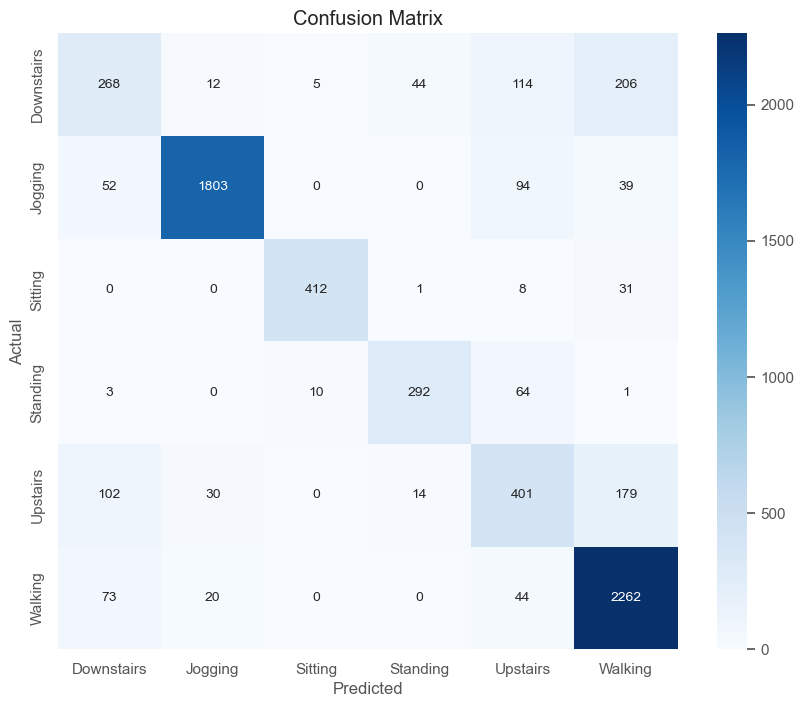

              precision    recall  f1-score   support

  Downstairs       0.54      0.41      0.47       649
     Jogging       0.97      0.91      0.94      1988
     Sitting       0.96      0.91      0.94       452
    Standing       0.83      0.79      0.81       370
    Upstairs       0.55      0.55      0.55       726
     Walking       0.83      0.94      0.88      2399

    accuracy                           0.83      6584
   macro avg       0.78      0.75      0.76      6584
weighted avg       0.82      0.83      0.82      6584



In [286]:
model_mlp_wideadam_w.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp_wideadam_w, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

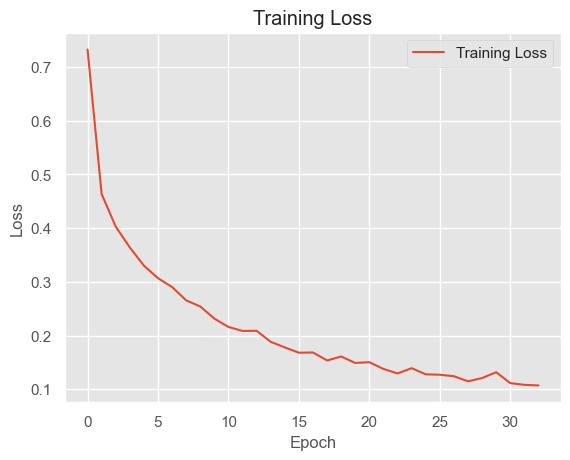

In [287]:
plot_loss(train_losses_wideadam_w,train_losses_wideadam_w)

#### LR 0.01

In [288]:
# Assuming TIME_PERIODS and n_classes are defined
model_mlp_wideadam_w = mlp_wide_with_droupout(TIME_PERIODS, n_classes)
model_mlp_wideadam_w.to(device)

# Choose your Optimizer
optimizer_wideadam_w  = torch.optim.AdamW(model_mlp_wideadam_w.parameters(), lr=0.01) 
train_losses_wideadam_w, train_accs_wideadam_w, val_losses_wideadam_w, val_accs_wideadam_w = train_and_validate_mlp(model_mlp_wideadam_w, device,train_loader_64, test_loader_64, optimizer_wideadam_w, EPOCHS, 30)

Epoch 1/500 - Train Loss: 0.9497, Train Acc: 0.6973, Val Loss: 1.3075, Val Acc: 0.6783
Epoch 2/500 - Train Loss: 0.8873, Train Acc: 0.7121, Val Loss: 0.8859, Val Acc: 0.6587
Epoch 3/500 - Train Loss: 0.8586, Train Acc: 0.7149, Val Loss: 1.0376, Val Acc: 0.6754
Epoch 4/500 - Train Loss: 0.8190, Train Acc: 0.7163, Val Loss: 0.8686, Val Acc: 0.6861
Epoch 5/500 - Train Loss: 0.7868, Train Acc: 0.7252, Val Loss: 1.2124, Val Acc: 0.6731
Epoch 6/500 - Train Loss: 0.7800, Train Acc: 0.7329, Val Loss: 0.8571, Val Acc: 0.6838
Epoch 7/500 - Train Loss: 0.7968, Train Acc: 0.7278, Val Loss: 0.8931, Val Acc: 0.6943
Epoch 8/500 - Train Loss: 0.7706, Train Acc: 0.7320, Val Loss: 0.8847, Val Acc: 0.6997
Epoch 9/500 - Train Loss: 0.7476, Train Acc: 0.7339, Val Loss: 0.8113, Val Acc: 0.6882
Epoch 10/500 - Train Loss: 0.7733, Train Acc: 0.7344, Val Loss: 0.7972, Val Acc: 0.6745
Epoch 11/500 - Train Loss: 0.7624, Train Acc: 0.7326, Val Loss: 0.8276, Val Acc: 0.7134
Epoch 12/500 - Train Loss: 0.7545, Train 

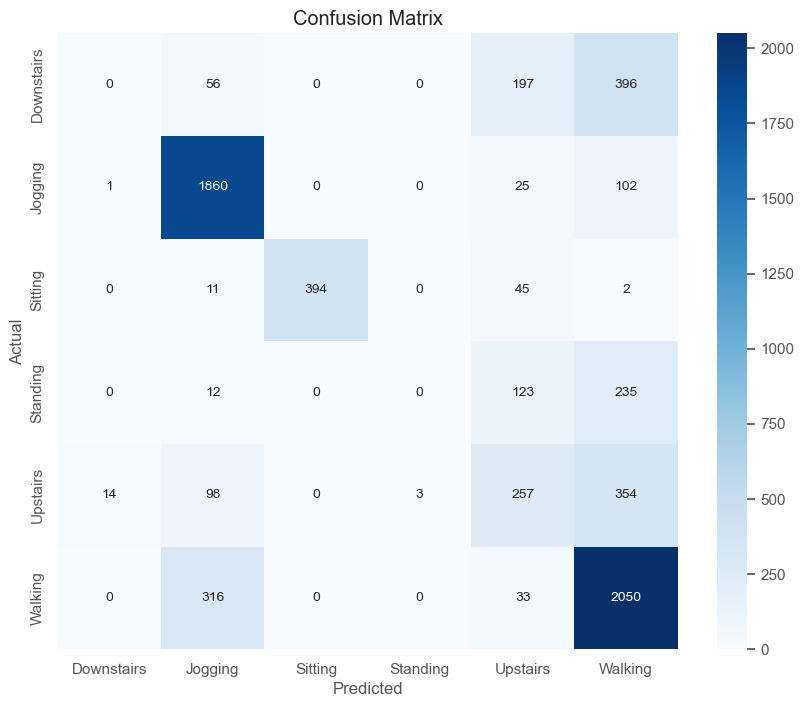

              precision    recall  f1-score   support

  Downstairs       0.00      0.00      0.00       649
     Jogging       0.79      0.94      0.86      1988
     Sitting       1.00      0.87      0.93       452
    Standing       0.00      0.00      0.00       370
    Upstairs       0.38      0.35      0.37       726
     Walking       0.65      0.85      0.74      2399

    accuracy                           0.69      6584
   macro avg       0.47      0.50      0.48      6584
weighted avg       0.59      0.69      0.63      6584



In [289]:
model_mlp_wideadam_w.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp_wideadam_w, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

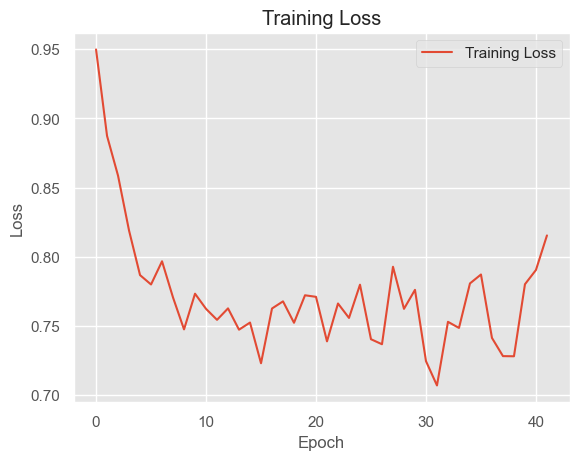

In [290]:
plot_loss(train_losses_wideadam_w,train_losses_wideadam_w)

#### LR 0.1

In [292]:
# Assuming TIME_PERIODS and n_classes are defined
model_mlp_wideadam_w = mlp_wide_with_droupout(TIME_PERIODS, n_classes)
model_mlp_wideadam_w.to(device)

# Choose your Optimizer
optimizer_wideadam_w  = torch.optim.AdamW(model_mlp_wideadam_w.parameters(), lr=0.1) 
train_losses_wideadam_w, train_accs_wideadam_w, val_losses_wideadam_w, val_accs_wideadam_w = train_and_validate_mlp(model_mlp_wideadam_w, device,train_loader_64, test_loader_64, optimizer_wideadam_w, EPOCHS, 30)

Epoch 1/500 - Train Loss: 8.8978, Train Acc: 0.4239, Val Loss: 1.4925, Val Acc: 0.3858
Epoch 2/500 - Train Loss: 1.7605, Train Acc: 0.3904, Val Loss: 1.5529, Val Acc: 0.3644
Epoch 3/500 - Train Loss: 1.5258, Train Acc: 0.3868, Val Loss: 1.5801, Val Acc: 0.3644
Epoch 4/500 - Train Loss: 1.4874, Train Acc: 0.3883, Val Loss: 1.5564, Val Acc: 0.3644
Epoch 5/500 - Train Loss: 1.5207, Train Acc: 0.3857, Val Loss: 1.5526, Val Acc: 0.3644
Epoch 6/500 - Train Loss: 1.4813, Train Acc: 0.3874, Val Loss: 1.5751, Val Acc: 0.3644
Epoch 7/500 - Train Loss: 1.4870, Train Acc: 0.3902, Val Loss: 1.5522, Val Acc: 0.3644
Epoch 8/500 - Train Loss: 1.4779, Train Acc: 0.3871, Val Loss: 1.5691, Val Acc: 0.3019
Epoch 9/500 - Train Loss: 1.5599, Train Acc: 0.3919, Val Loss: 1.5556, Val Acc: 0.3644
Epoch 10/500 - Train Loss: 2.9401, Train Acc: 0.3839, Val Loss: 1.5625, Val Acc: 0.3644
Epoch 11/500 - Train Loss: 1.6131, Train Acc: 0.3882, Val Loss: 1.5650, Val Acc: 0.3644
Epoch 12/500 - Train Loss: 1.5195, Train 

### Adam

#### 0.01

In [293]:
 # Assuming TIME_PERIODS and n_classes are defined
model_mlp_wideadam_w = mlp_wide_with_droupout(TIME_PERIODS, n_classes)
model_mlp_wideadam_w.to(device)

# Choose your Optimizer
optimizer_wideadam_w  = torch.optim.Adam(model_mlp_wideadam_w.parameters(), lr=0.01) 
train_losses_wideadam_w, train_accs_wideadam_w, val_losses_wideadam_w, val_accs_wideadam_w = train_and_validate_mlp(model_mlp_wideadam_w, device,train_loader_64, test_loader_64, optimizer_wideadam_w, EPOCHS, 30)

Epoch 1/500 - Train Loss: 0.9819, Train Acc: 0.6899, Val Loss: 1.0569, Val Acc: 0.6555
Epoch 2/500 - Train Loss: 0.8673, Train Acc: 0.7175, Val Loss: 1.3131, Val Acc: 0.6817
Epoch 3/500 - Train Loss: 0.8770, Train Acc: 0.7139, Val Loss: 1.0044, Val Acc: 0.6817
Epoch 4/500 - Train Loss: 0.7937, Train Acc: 0.7288, Val Loss: 0.7746, Val Acc: 0.7187
Epoch 5/500 - Train Loss: 0.7980, Train Acc: 0.7222, Val Loss: 0.9402, Val Acc: 0.6753
Epoch 6/500 - Train Loss: 0.7978, Train Acc: 0.7330, Val Loss: 1.3170, Val Acc: 0.6832
Epoch 7/500 - Train Loss: 0.7706, Train Acc: 0.7338, Val Loss: 0.9364, Val Acc: 0.6990
Epoch 8/500 - Train Loss: 0.7646, Train Acc: 0.7395, Val Loss: 1.2561, Val Acc: 0.6842
Epoch 9/500 - Train Loss: 0.7709, Train Acc: 0.7363, Val Loss: 0.8938, Val Acc: 0.7093
Epoch 10/500 - Train Loss: 0.7607, Train Acc: 0.7443, Val Loss: 0.8357, Val Acc: 0.6971
Epoch 11/500 - Train Loss: 0.7674, Train Acc: 0.7408, Val Loss: 0.8213, Val Acc: 0.7198
Epoch 12/500 - Train Loss: 0.7784, Train 

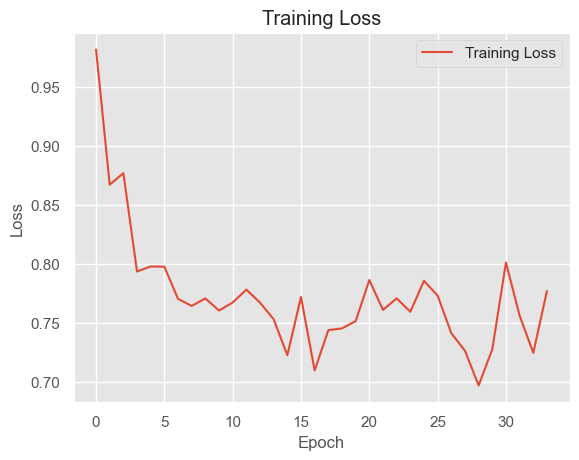

In [295]:
plot_loss(train_losses_wideadam_w,train_losses_wideadam_w)

#### 0.1

In [296]:
 # Assuming TIME_PERIODS and n_classes are defined
model_mlp_wideadam_w = mlp_wide_with_droupout(TIME_PERIODS, n_classes)
model_mlp_wideadam_w.to(device)

# Choose your Optimizer
optimizer_wideadam_w  = torch.optim.Adam(model_mlp_wideadam_w.parameters(), lr=0.1) 
train_losses_wideadam_w, train_accs_wideadam_w, val_losses_wideadam_w, val_accs_wideadam_w = train_and_validate_mlp(model_mlp_wideadam_w, device,train_loader_64, test_loader_64, optimizer_wideadam_w, EPOCHS, 30)

Epoch 1/500 - Train Loss: 4.9724, Train Acc: 0.3999, Val Loss: 1.5308, Val Acc: 0.3747
Epoch 2/500 - Train Loss: 1.6720, Train Acc: 0.3921, Val Loss: 1.5575, Val Acc: 0.3644
Epoch 3/500 - Train Loss: 1.5052, Train Acc: 0.3893, Val Loss: 1.5647, Val Acc: 0.3644
Epoch 4/500 - Train Loss: 1.4981, Train Acc: 0.3894, Val Loss: 1.5632, Val Acc: 0.3644
Epoch 5/500 - Train Loss: 1.5020, Train Acc: 0.3887, Val Loss: 1.5605, Val Acc: 0.3644
Epoch 6/500 - Train Loss: 1.5361, Train Acc: 0.3923, Val Loss: 1.5588, Val Acc: 0.3644
Epoch 7/500 - Train Loss: 1.5267, Train Acc: 0.3902, Val Loss: 1.5536, Val Acc: 0.3644
Epoch 8/500 - Train Loss: 1.4769, Train Acc: 0.3919, Val Loss: 1.5643, Val Acc: 0.3644
Epoch 9/500 - Train Loss: 1.5031, Train Acc: 0.3898, Val Loss: 1.5588, Val Acc: 0.3644
Epoch 10/500 - Train Loss: 1.4770, Train Acc: 0.3898, Val Loss: 1.5556, Val Acc: 0.3644
Epoch 11/500 - Train Loss: 1.4944, Train Acc: 0.3898, Val Loss: 1.5560, Val Acc: 0.3644
Epoch 12/500 - Train Loss: 1.4768, Train 

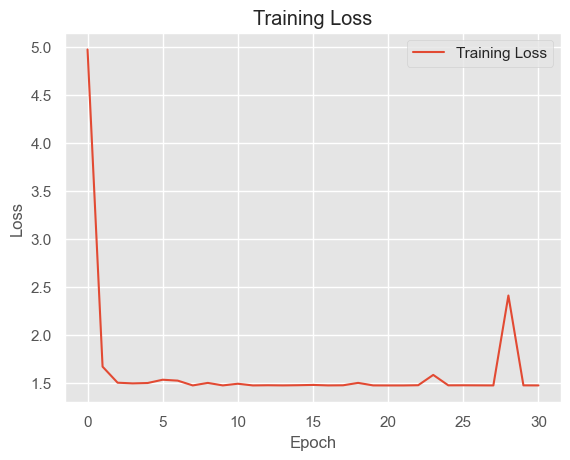

In [297]:
plot_loss(train_losses_wideadam_w,train_losses_wideadam_w)

## CNN

### AdamW

#### 0.001

In [298]:
cnn_adam_w = cnn_5(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_adam_w = torch.optim.Adam(cnn_adam_w.parameters(), lr=0.001)

train_losses_cnn_adam_w, train_accs_cnn_adam_w, val_losses_cnn_adam_w, val_accs_cnn_adam_w = train_and_validate_cnn(cnn_adam_w, device, train_loader_64, test_loader_64, optimizer_cnn_adam_w, criterion, EPOCHS, patience=30)
        

Epoch 1/500 - Train Loss: 0.6103, Train Acc: 0.7776, Val Loss: 0.8818, Val Acc: 0.7912
Epoch 2/500 - Train Loss: 0.3232, Train Acc: 0.8809, Val Loss: 0.8905, Val Acc: 0.7880
Epoch 3/500 - Train Loss: 0.2225, Train Acc: 0.9167, Val Loss: 0.6441, Val Acc: 0.8267
Epoch 4/500 - Train Loss: 0.1491, Train Acc: 0.9491, Val Loss: 0.7488, Val Acc: 0.8422
Epoch 5/500 - Train Loss: 0.1229, Train Acc: 0.9616, Val Loss: 0.8072, Val Acc: 0.8426
Epoch 6/500 - Train Loss: 0.1060, Train Acc: 0.9665, Val Loss: 0.6775, Val Acc: 0.8313
Epoch 7/500 - Train Loss: 0.0846, Train Acc: 0.9730, Val Loss: 0.8111, Val Acc: 0.8516
Epoch 8/500 - Train Loss: 0.0744, Train Acc: 0.9770, Val Loss: 0.4505, Val Acc: 0.8726
Epoch 9/500 - Train Loss: 0.0715, Train Acc: 0.9777, Val Loss: 0.6665, Val Acc: 0.8569
Epoch 10/500 - Train Loss: 0.0592, Train Acc: 0.9818, Val Loss: 0.6327, Val Acc: 0.8714
Epoch 11/500 - Train Loss: 0.0546, Train Acc: 0.9846, Val Loss: 0.8406, Val Acc: 0.8645
Epoch 12/500 - Train Loss: 0.0520, Train 

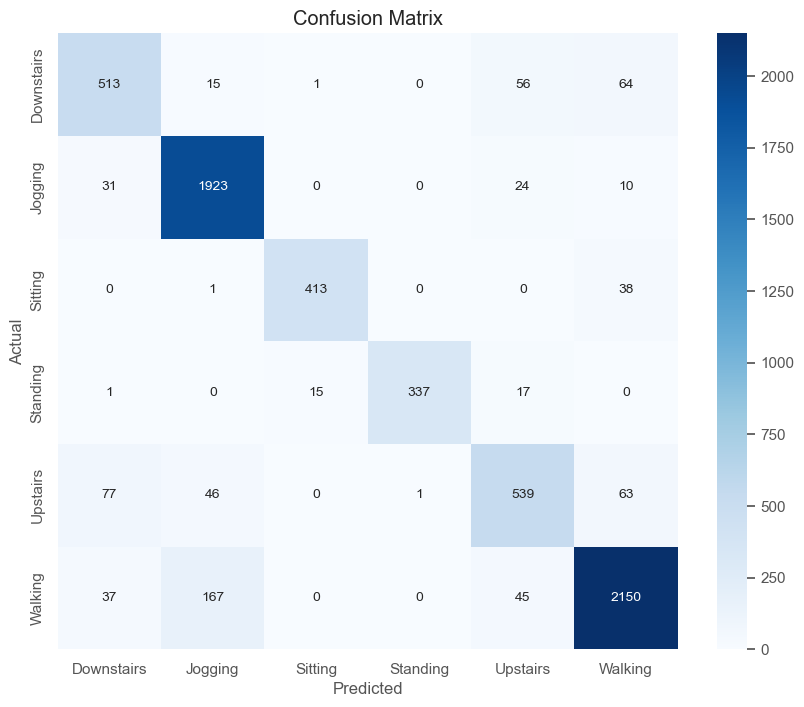

              precision    recall  f1-score   support

  Downstairs       0.78      0.79      0.78       649
     Jogging       0.89      0.97      0.93      1988
     Sitting       0.96      0.91      0.94       452
    Standing       1.00      0.91      0.95       370
    Upstairs       0.79      0.74      0.77       726
     Walking       0.92      0.90      0.91      2399

    accuracy                           0.89      6584
   macro avg       0.89      0.87      0.88      6584
weighted avg       0.89      0.89      0.89      6584



In [299]:
cnn_adam_w.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(cnn_adam_w, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

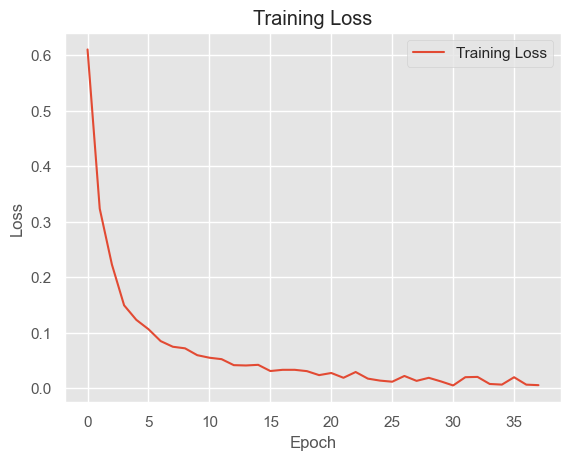

In [300]:
plot_loss(train_losses_cnn_adam_w,train_losses_wideadam_w)

#### 0.01

In [303]:
cnn_adam_w = cnn_5(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_adam_w = torch.optim.Adam(cnn_adam_w.parameters(), lr=0.01)

train_losses_cnn_adam_w, train_accs_cnn_adam_w, val_losses_cnn_adam_w, val_accs_cnn_adam_w = train_and_validate_cnn(cnn_adam_w, device, train_loader_64, test_loader_64, optimizer_cnn_adam_w, criterion, EPOCHS, patience=30)
        

Epoch 1/500 - Train Loss: 0.6836, Train Acc: 0.7530, Val Loss: 1.1842, Val Acc: 0.7154
Epoch 2/500 - Train Loss: 0.3759, Train Acc: 0.8388, Val Loss: 0.8040, Val Acc: 0.7617
Epoch 3/500 - Train Loss: 0.3095, Train Acc: 0.8677, Val Loss: 1.1046, Val Acc: 0.7842
Epoch 4/500 - Train Loss: 0.2709, Train Acc: 0.8998, Val Loss: 1.4755, Val Acc: 0.7693
Epoch 5/500 - Train Loss: 0.2572, Train Acc: 0.9105, Val Loss: 1.1725, Val Acc: 0.8246
Epoch 6/500 - Train Loss: 0.2016, Train Acc: 0.9311, Val Loss: 1.1348, Val Acc: 0.8038
Epoch 7/500 - Train Loss: 0.1948, Train Acc: 0.9339, Val Loss: 0.9083, Val Acc: 0.7928
Epoch 8/500 - Train Loss: 0.1750, Train Acc: 0.9395, Val Loss: 0.8867, Val Acc: 0.8334
Epoch 9/500 - Train Loss: 0.1877, Train Acc: 0.9380, Val Loss: 0.8253, Val Acc: 0.8519
Epoch 10/500 - Train Loss: 0.1684, Train Acc: 0.9433, Val Loss: 1.0018, Val Acc: 0.8472
Epoch 11/500 - Train Loss: 0.1748, Train Acc: 0.9431, Val Loss: 1.0674, Val Acc: 0.8302
Epoch 12/500 - Train Loss: 0.1636, Train 

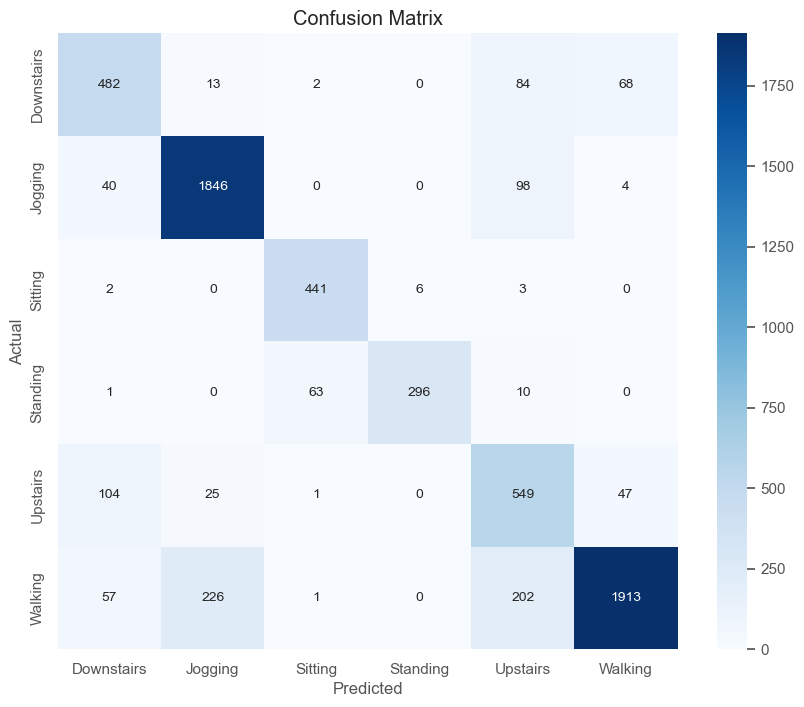

              precision    recall  f1-score   support

  Downstairs       0.70      0.74      0.72       649
     Jogging       0.87      0.93      0.90      1988
     Sitting       0.87      0.98      0.92       452
    Standing       0.98      0.80      0.88       370
    Upstairs       0.58      0.76      0.66       726
     Walking       0.94      0.80      0.86      2399

    accuracy                           0.84      6584
   macro avg       0.82      0.83      0.82      6584
weighted avg       0.86      0.84      0.84      6584



In [304]:
cnn_adam_w.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(cnn_adam_w, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

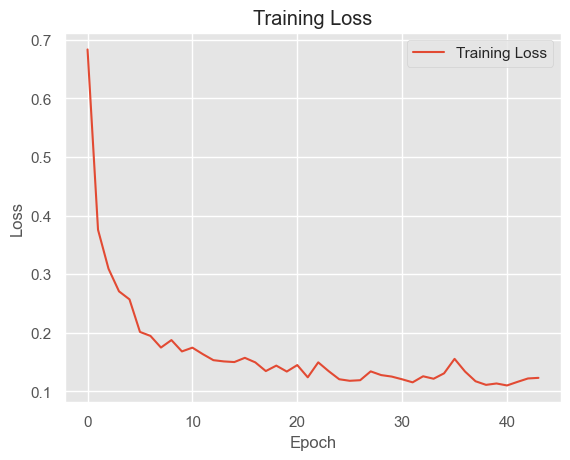

In [305]:
plot_loss(train_losses_cnn_adam_w,train_losses_wideadam_w)

#### 0.1

In [310]:
cnn_adam_w = cnn_5(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_adam_w = torch.optim.Adam(cnn_adam_w.parameters(), lr=0.1)

train_losses_cnn_adam_w, train_accs_cnn_adam_w, val_losses_cnn_adam_w, val_accs_cnn_adam_w = train_and_validate_cnn(cnn_adam_w, device, train_loader_64, test_loader_64, optimizer_cnn_adam_w, criterion, EPOCHS, patience=30)
        

Epoch 1/500 - Train Loss: 120.9969, Train Acc: 0.3841, Val Loss: 1.5590, Val Acc: 0.3644
Epoch 2/500 - Train Loss: 1.4769, Train Acc: 0.3871, Val Loss: 1.5566, Val Acc: 0.3644
Epoch 3/500 - Train Loss: 1.4755, Train Acc: 0.3916, Val Loss: 1.5686, Val Acc: 0.3644
Epoch 4/500 - Train Loss: 1.4775, Train Acc: 0.3866, Val Loss: 1.5638, Val Acc: 0.3644
Epoch 5/500 - Train Loss: 1.4778, Train Acc: 0.3848, Val Loss: 1.5584, Val Acc: 0.3644
Epoch 6/500 - Train Loss: 1.4758, Train Acc: 0.3901, Val Loss: 1.5662, Val Acc: 0.3644
Epoch 7/500 - Train Loss: 1.4764, Train Acc: 0.3854, Val Loss: 1.5575, Val Acc: 0.3644
Epoch 8/500 - Train Loss: 1.4772, Train Acc: 0.3861, Val Loss: 1.5555, Val Acc: 0.3644
Epoch 9/500 - Train Loss: 1.4777, Train Acc: 0.3899, Val Loss: 1.5645, Val Acc: 0.3644
Epoch 10/500 - Train Loss: 1.4771, Train Acc: 0.3868, Val Loss: 1.5512, Val Acc: 0.3644
Epoch 11/500 - Train Loss: 1.4776, Train Acc: 0.3848, Val Loss: 1.5653, Val Acc: 0.3644
Epoch 12/500 - Train Loss: 1.4776, Trai

# Model Scaling

In [319]:
class cnn_scaled(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(cnn_scaled, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=n_sensors, out_channels=50, kernel_size=10)
        self.conv2 = nn.Conv1d(in_channels=50, out_channels=50, kernel_size=10)
        self.conv3 = nn.Conv1d(in_channels=50, out_channels=80, kernel_size=10)
        self.conv4 = nn.Conv1d(in_channels=80, out_channels=80, kernel_size=10)

        # Max Pooling
        self.pool = nn.MaxPool1d(kernel_size=3)

        # Adaptive Average Pooling
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Dropout
        self.dropout = nn.Dropout(0.3)

        # Fully connected layer
        self.fc = nn.Linear(80, n_classes)


    def forward(self, x):
        # # Reshape the input to (batch_size, n_sensors, -1)
        # x = x.view(-1, self.n_sensors, x.size(1))
        actual_time_steps = x.size(-1) // self.n_sensors
        x = x.view(-1, self.n_sensors, actual_time_steps)

        # Convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # Apply max pooling after the second conv layer
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # Global average pooling and dropout
        x = self.adaptive_pool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = torch.flatten(x, 1)

        # Fully connected layer
        x = self.fc(x)

        # Output layer with log_softmax activation
        return F.log_softmax(x, dim=1)

# # Assuming TIME_PERIODS, n_sensors, and n_classes are defined
# mdl_scaled = cnn_scaled(TIME_PERIODS, n_sensors, n_classes).to(device)


# # Print model summary
# print(mdl_scaled)


In this adjusted model, the first two convolutional layers now have 50 filters each, and the third and fourth layers have 80 filters each. This reduction in the number of filters will decrease the model's capacity, which could potentially lead to faster training times and might help to mitigate overfitting, especially when you do not have a very large dataset. However, it's important to note that reducing the model's capacity might also limit its ability to learn complex features, so the impact on performance should be carefully evaluated.


In [314]:
mdl_scaled = cnn_scaled(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_scaled = torch.optim.Adam(mdl_scaled.parameters(), lr=0.001)

train_losses_cnn_scaled, train_accs_cnn_scaled, val_losses_cnn_scaled, val_accs_cnn_scaled = train_and_validate_cnn(mdl_scaled, device, train_loader_64, test_loader_64, optimizer_cnn_scaled, criterion, EPOCHS, patience=30)

Epoch 1/500 - Train Loss: 0.6436, Train Acc: 0.7609, Val Loss: 0.8439, Val Acc: 0.7787
Epoch 2/500 - Train Loss: 0.3421, Train Acc: 0.8698, Val Loss: 0.6672, Val Acc: 0.7849
Epoch 3/500 - Train Loss: 0.2661, Train Acc: 0.8985, Val Loss: 0.7185, Val Acc: 0.7693
Epoch 4/500 - Train Loss: 0.2232, Train Acc: 0.9140, Val Loss: 0.6265, Val Acc: 0.7875
Epoch 5/500 - Train Loss: 0.1969, Train Acc: 0.9265, Val Loss: 0.5777, Val Acc: 0.8158
Epoch 6/500 - Train Loss: 0.1655, Train Acc: 0.9424, Val Loss: 0.7936, Val Acc: 0.8341
Epoch 7/500 - Train Loss: 0.1316, Train Acc: 0.9574, Val Loss: 0.7657, Val Acc: 0.8413
Epoch 8/500 - Train Loss: 0.1126, Train Acc: 0.9658, Val Loss: 0.7564, Val Acc: 0.8539
Epoch 9/500 - Train Loss: 0.0976, Train Acc: 0.9714, Val Loss: 1.0849, Val Acc: 0.7723
Epoch 10/500 - Train Loss: 0.0882, Train Acc: 0.9747, Val Loss: 0.6208, Val Acc: 0.8490
Epoch 11/500 - Train Loss: 0.0691, Train Acc: 0.9800, Val Loss: 0.7034, Val Acc: 0.8516
Epoch 12/500 - Train Loss: 0.0690, Train 

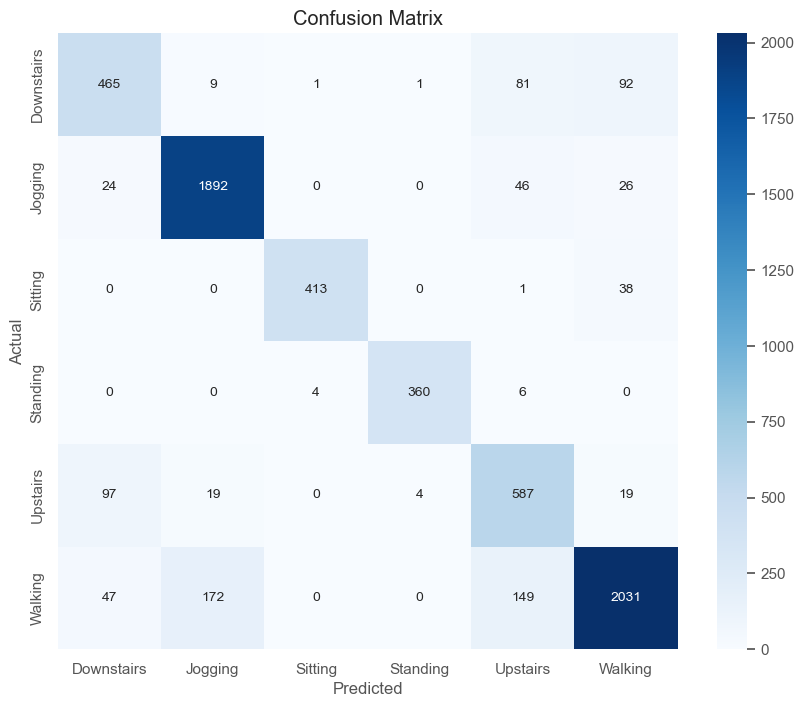

              precision    recall  f1-score   support

  Downstairs       0.73      0.72      0.73       649
     Jogging       0.90      0.95      0.93      1988
     Sitting       0.99      0.91      0.95       452
    Standing       0.99      0.97      0.98       370
    Upstairs       0.67      0.81      0.74       726
     Walking       0.92      0.85      0.88      2399

    accuracy                           0.87      6584
   macro avg       0.87      0.87      0.87      6584
weighted avg       0.88      0.87      0.87      6584



In [315]:
mdl_scaled.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(mdl_scaled, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## No Dropput

In [317]:
mdl_scaled = cnn_scaled(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_scaled = torch.optim.Adam(mdl_scaled.parameters(), lr=0.001)

train_losses_cnn_scaled, train_accs_cnn_scaled, val_losses_cnn_scaled, val_accs_cnn_scaled = train_and_validate_cnn(mdl_scaled, device, train_loader_64, test_loader_64, optimizer_cnn_scaled, criterion, EPOCHS, patience=30)

Epoch 1/500 - Train Loss: 0.5642, Train Acc: 0.7885, Val Loss: 0.6684, Val Acc: 0.8000
Epoch 2/500 - Train Loss: 0.2924, Train Acc: 0.8847, Val Loss: 1.1445, Val Acc: 0.6516
Epoch 3/500 - Train Loss: 0.2101, Train Acc: 0.9207, Val Loss: 0.6738, Val Acc: 0.8152
Epoch 4/500 - Train Loss: 0.1416, Train Acc: 0.9507, Val Loss: 0.9407, Val Acc: 0.8056
Epoch 5/500 - Train Loss: 0.1107, Train Acc: 0.9635, Val Loss: 1.1738, Val Acc: 0.7997
Epoch 6/500 - Train Loss: 0.0886, Train Acc: 0.9699, Val Loss: 0.9779, Val Acc: 0.8393
Epoch 7/500 - Train Loss: 0.0708, Train Acc: 0.9779, Val Loss: 0.6654, Val Acc: 0.8354
Epoch 8/500 - Train Loss: 0.0603, Train Acc: 0.9811, Val Loss: 0.7379, Val Acc: 0.8360
Epoch 9/500 - Train Loss: 0.0533, Train Acc: 0.9837, Val Loss: 0.6571, Val Acc: 0.8454
Epoch 10/500 - Train Loss: 0.0465, Train Acc: 0.9855, Val Loss: 0.5814, Val Acc: 0.8756
Epoch 11/500 - Train Loss: 0.0366, Train Acc: 0.9887, Val Loss: 0.5748, Val Acc: 0.8562
Epoch 12/500 - Train Loss: 0.0332, Train 

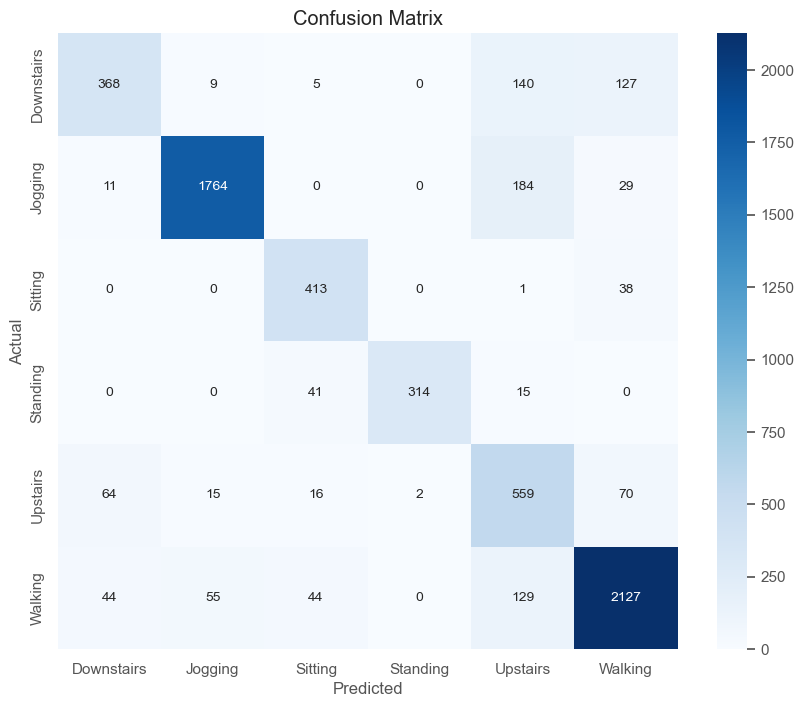

              precision    recall  f1-score   support

  Downstairs       0.76      0.57      0.65       649
     Jogging       0.96      0.89      0.92      1988
     Sitting       0.80      0.91      0.85       452
    Standing       0.99      0.85      0.92       370
    Upstairs       0.54      0.77      0.64       726
     Walking       0.89      0.89      0.89      2399

    accuracy                           0.84      6584
   macro avg       0.82      0.81      0.81      6584
weighted avg       0.86      0.84      0.85      6584



In [318]:
mdl_scaled.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(mdl_scaled, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## 0.3 Drop

In [320]:
mdl_scaled = cnn_scaled(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_scaled = torch.optim.Adam(mdl_scaled.parameters(), lr=0.001)

train_losses_cnn_scaled, train_accs_cnn_scaled, val_losses_cnn_scaled, val_accs_cnn_scaled = train_and_validate_cnn(mdl_scaled, device, train_loader_64, test_loader_64, optimizer_cnn_scaled, criterion, EPOCHS, patience=30)

Epoch 1/500 - Train Loss: 0.6062, Train Acc: 0.7765, Val Loss: 0.6939, Val Acc: 0.7994
Epoch 2/500 - Train Loss: 0.2943, Train Acc: 0.8886, Val Loss: 1.0557, Val Acc: 0.7559
Epoch 3/500 - Train Loss: 0.2451, Train Acc: 0.9083, Val Loss: 0.6226, Val Acc: 0.8240
Epoch 4/500 - Train Loss: 0.1832, Train Acc: 0.9338, Val Loss: 0.6223, Val Acc: 0.8495
Epoch 5/500 - Train Loss: 0.1383, Train Acc: 0.9535, Val Loss: 0.5485, Val Acc: 0.8483
Epoch 6/500 - Train Loss: 0.1184, Train Acc: 0.9624, Val Loss: 0.7255, Val Acc: 0.8439
Epoch 7/500 - Train Loss: 0.0966, Train Acc: 0.9702, Val Loss: 0.5700, Val Acc: 0.8475
Epoch 8/500 - Train Loss: 0.0777, Train Acc: 0.9764, Val Loss: 0.5930, Val Acc: 0.8574
Epoch 9/500 - Train Loss: 0.0687, Train Acc: 0.9807, Val Loss: 0.5699, Val Acc: 0.8581
Epoch 10/500 - Train Loss: 0.0629, Train Acc: 0.9815, Val Loss: 0.5490, Val Acc: 0.8584
Epoch 11/500 - Train Loss: 0.0516, Train Acc: 0.9853, Val Loss: 0.7765, Val Acc: 0.8369
Epoch 12/500 - Train Loss: 0.0494, Train 

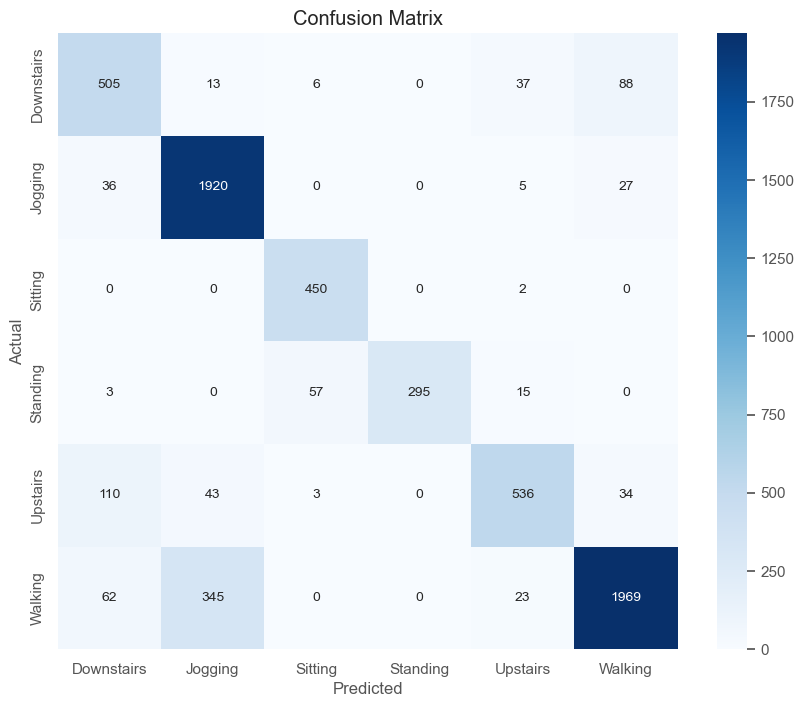

              precision    recall  f1-score   support

  Downstairs       0.71      0.78      0.74       649
     Jogging       0.83      0.97      0.89      1988
     Sitting       0.87      1.00      0.93       452
    Standing       1.00      0.80      0.89       370
    Upstairs       0.87      0.74      0.80       726
     Walking       0.93      0.82      0.87      2399

    accuracy                           0.86      6584
   macro avg       0.87      0.85      0.85      6584
weighted avg       0.87      0.86      0.86      6584



In [321]:
mdl_scaled.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(mdl_scaled, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

# Data Scaling

In [328]:
def downsample_data(data, factor):
    """
    Downsamples the input data by selecting every nth sample, where n is the downsample factor.
    
    Parameters:
    - data: Input data, a numpy array of shape (num_samples, sequence_length).
    - factor: The downsampling factor (n), indicating every nth sample to be selected.
    
    Returns:
    - Downsampled data, a numpy array with the reduced sequence length.
    """
    return data[:, ::factor]

# Downsample to 10Hz by selecting every 2nd sample
x_train_10Hz = downsample_data(x_train, 2)


# Downsample to 4Hz by selecting every 5th sample
x_train_4Hz = downsample_data(x_train, 5)

# Print shapes to see the effect on dataset size
print("Original Shape:", x_train.shape)
print("Downsampled to 10Hz Shape:", x_train_10Hz.shape)
print("Downsampled to 4Hz Shape:", x_train_4Hz.shape)

Original Shape: (20868, 240)
Downsampled to 10Hz Shape: (20868, 120)
Downsampled to 4Hz Shape: (20868, 48)


In [ ]:

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader_64 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_64 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## 10 Hz

In [329]:
x_train_10hz_tensor = torch.tensor(x_train_10Hz, dtype=torch.float32)
train_dataset_10hz = TensorDataset(x_train_10hz_tensor, y_train_tensor)
train_loader_64_10Hz= DataLoader(train_dataset_10hz, batch_size=64, shuffle=True)


In [344]:
class cnn_downsample(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(cnn_downsample, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=n_sensors, out_channels=64, kernel_size=1, stride=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1, stride=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1, stride=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=1, stride=1)

        # Max Pooling
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Adaptive Average Pooling
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        self.fc = nn.Linear(256, n_classes)


    def forward(self, x):
        # # Reshape the input to (batch_size, n_sensors, -1)
        # x = x.view(-1, self.n_sensors, x.size(1))
        actual_time_steps = x.size(-1) // self.n_sensors
        x = x.view(-1, self.n_sensors, actual_time_steps)

        # Convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))

        # Global average pooling and dropout
        x = self.adaptive_pool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = torch.flatten(x, 1)

        # Fully connected layer
        x = self.fc(x)

        # Output layer with log_softmax activation
        return F.log_softmax(x, dim=1)

In [340]:
cnn_best_10_hz = cnn_downsample(40, n_sensors, n_classes).to(device)
optimizer_cnn_best_10_hz  = torch.optim.Adam(cnn_best_10_hz.parameters(), lr=0.001)

train_losses_cnn_best_10_hz , train_accs_cnn_best_10_hz , val_losses_cnn_best_10_hz , val_accs_cnn_best_10_hz  = train_and_validate_cnn(cnn_best_10_hz, device, train_loader_64_10Hz, test_loader_64, optimizer_cnn_best_10_hz, criterion, num_epochs=200, patience=30)

Epoch 1/200 - Train Loss: 0.6833, Train Acc: 0.7509, Val Loss: 1.4881, Val Acc: 0.5255
Epoch 2/200 - Train Loss: 0.4039, Train Acc: 0.8502, Val Loss: 1.1334, Val Acc: 0.5430
Epoch 3/200 - Train Loss: 0.3220, Train Acc: 0.8808, Val Loss: 1.9446, Val Acc: 0.3633
Epoch 4/200 - Train Loss: 0.2355, Train Acc: 0.9173, Val Loss: 2.1834, Val Acc: 0.3717
Epoch 5/200 - Train Loss: 0.1910, Train Acc: 0.9329, Val Loss: 1.4480, Val Acc: 0.4923
Epoch 6/200 - Train Loss: 0.1564, Train Acc: 0.9476, Val Loss: 2.2775, Val Acc: 0.4004
Epoch 7/200 - Train Loss: 0.1341, Train Acc: 0.9554, Val Loss: 2.0778, Val Acc: 0.4294
Epoch 8/200 - Train Loss: 0.1258, Train Acc: 0.9574, Val Loss: 2.3893, Val Acc: 0.4105
Epoch 9/200 - Train Loss: 0.1061, Train Acc: 0.9654, Val Loss: 2.2730, Val Acc: 0.4320
Epoch 10/200 - Train Loss: 0.0972, Train Acc: 0.9677, Val Loss: 2.0174, Val Acc: 0.4754
Epoch 11/200 - Train Loss: 0.0885, Train Acc: 0.9706, Val Loss: 2.0354, Val Acc: 0.4686
Epoch 12/200 - Train Loss: 0.0775, Train 

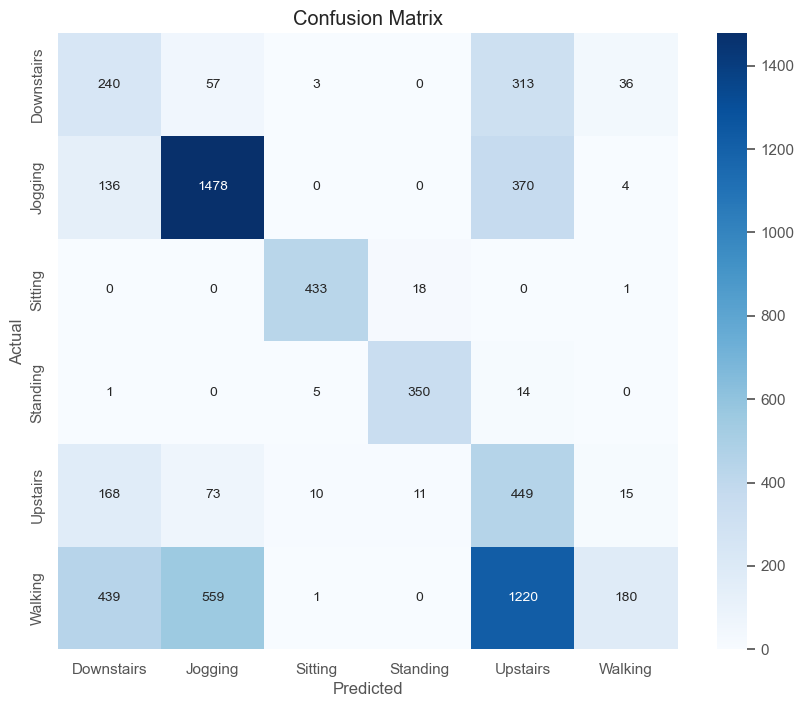

              precision    recall  f1-score   support

  Downstairs       0.24      0.37      0.29       649
     Jogging       0.68      0.74      0.71      1988
     Sitting       0.96      0.96      0.96       452
    Standing       0.92      0.95      0.93       370
    Upstairs       0.19      0.62      0.29       726
     Walking       0.76      0.08      0.14      2399

    accuracy                           0.48      6584
   macro avg       0.63      0.62      0.55      6584
weighted avg       0.65      0.48      0.44      6584



In [341]:
cnn_best_10_hz.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(cnn_best_10_hz, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## 4 Hz

In [342]:
x_train_4hz_tensor = torch.tensor(x_train_4Hz, dtype=torch.float32)
train_dataset_4hz = TensorDataset(x_train_4hz_tensor, y_train_tensor)
train_loader_64_4Hz= DataLoader(train_dataset_4hz, batch_size=64, shuffle=True)


In [345]:
cnn_best_10_hz = cnn_downsample(40, n_sensors, n_classes).to(device)
optimizer_cnn_best_10_hz  = torch.optim.Adam(cnn_best_10_hz.parameters(), lr=0.001)

train_losses_cnn_best_10_hz , train_accs_cnn_best_10_hz , val_losses_cnn_best_10_hz , val_accs_cnn_best_10_hz  = train_and_validate_cnn(cnn_best_10_hz, device, train_loader_64_4Hz, test_loader_64, optimizer_cnn_best_10_hz, criterion, num_epochs=200, patience=30)

Epoch 1/200 - Train Loss: 0.9045, Train Acc: 0.6809, Val Loss: 0.9781, Val Acc: 0.7173
Epoch 2/200 - Train Loss: 0.5857, Train Acc: 0.7889, Val Loss: 1.0290, Val Acc: 0.6690
Epoch 3/200 - Train Loss: 0.5435, Train Acc: 0.8027, Val Loss: 1.1660, Val Acc: 0.6490
Epoch 4/200 - Train Loss: 0.5033, Train Acc: 0.8164, Val Loss: 1.2666, Val Acc: 0.6071
Epoch 5/200 - Train Loss: 0.4898, Train Acc: 0.8224, Val Loss: 1.2219, Val Acc: 0.5899
Epoch 6/200 - Train Loss: 0.4757, Train Acc: 0.8276, Val Loss: 1.6747, Val Acc: 0.5320
Epoch 7/200 - Train Loss: 0.4618, Train Acc: 0.8309, Val Loss: 1.2407, Val Acc: 0.6089
Epoch 8/200 - Train Loss: 0.4428, Train Acc: 0.8367, Val Loss: 1.4441, Val Acc: 0.6160
Epoch 9/200 - Train Loss: 0.4303, Train Acc: 0.8416, Val Loss: 1.4133, Val Acc: 0.6077
Epoch 10/200 - Train Loss: 0.4235, Train Acc: 0.8437, Val Loss: 1.2678, Val Acc: 0.6261
Epoch 11/200 - Train Loss: 0.4137, Train Acc: 0.8443, Val Loss: 1.4922, Val Acc: 0.5305
Epoch 12/200 - Train Loss: 0.4028, Train 

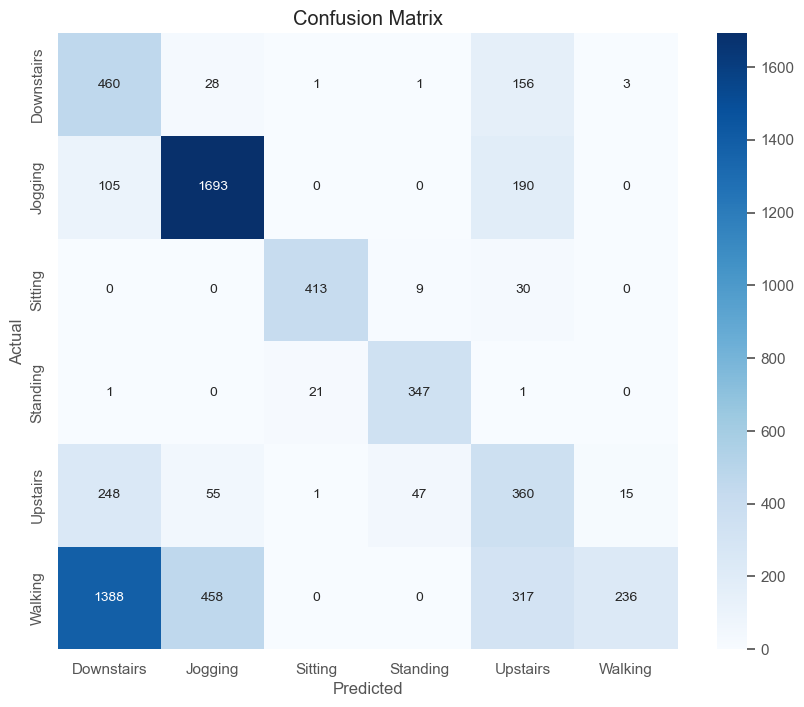

              precision    recall  f1-score   support

  Downstairs       0.21      0.71      0.32       649
     Jogging       0.76      0.85      0.80      1988
     Sitting       0.95      0.91      0.93       452
    Standing       0.86      0.94      0.90       370
    Upstairs       0.34      0.50      0.40       726
     Walking       0.93      0.10      0.18      2399

    accuracy                           0.53      6584
   macro avg       0.67      0.67      0.59      6584
weighted avg       0.74      0.53      0.50      6584



In [346]:
cnn_best_10_hz.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(cnn_best_10_hz, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

# Sampling Strategies

# Oversampling Minor Class

In [347]:
from torch.utils.data import WeightedRandomSampler

# Calculate class weights
class_counts = np.bincount(y_train_tensor.numpy())
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)

# Assign a weight to every data point based on its class
sample_weights = class_weights[y_train_tensor]

# Create a sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Use the sampler in the DataLoader
train_loader_oversampler = DataLoader(train_dataset, batch_size=64, sampler=sampler)

## MLP

In [349]:
# Assuming TIME_PERIODS and n_classes are defined
model_mlp_wide_oversample = mlp_wide_with_droupout(TIME_PERIODS, n_classes)
model_mlp_wide_oversample.to(device)

# Choose your Optimizer
optimizer_wide_oversample = torch.optim.Adam(model_mlp_wide_oversample.parameters())
train_losses_wide_oversample, train_accs_wide_oversample, val_losses_wide_oversample, val_accs_wide_oversample = train_and_validate_mlp(model_mlp_wide_oversample, device,train_loader_oversampler, test_loader_64, optimizer_wide_oversample, EPOCHS, patience=30)

Epoch 1/500 - Train Loss: 0.8516, Train Acc: 0.6506, Val Loss: 0.8826, Val Acc: 0.6157
Epoch 2/500 - Train Loss: 0.5467, Train Acc: 0.7685, Val Loss: 0.8083, Val Acc: 0.6818
Epoch 3/500 - Train Loss: 0.4716, Train Acc: 0.8039, Val Loss: 0.6493, Val Acc: 0.7694
Epoch 4/500 - Train Loss: 0.4200, Train Acc: 0.8284, Val Loss: 0.7286, Val Acc: 0.7552
Epoch 5/500 - Train Loss: 0.3840, Train Acc: 0.8461, Val Loss: 0.6431, Val Acc: 0.7849
Epoch 6/500 - Train Loss: 0.3430, Train Acc: 0.8677, Val Loss: 0.6377, Val Acc: 0.7918
Epoch 7/500 - Train Loss: 0.3207, Train Acc: 0.8732, Val Loss: 0.7297, Val Acc: 0.7669
Epoch 8/500 - Train Loss: 0.2871, Train Acc: 0.8904, Val Loss: 0.6913, Val Acc: 0.8007
Epoch 9/500 - Train Loss: 0.2576, Train Acc: 0.9035, Val Loss: 0.8010, Val Acc: 0.7766
Epoch 10/500 - Train Loss: 0.2520, Train Acc: 0.9090, Val Loss: 0.9312, Val Acc: 0.7634
Epoch 11/500 - Train Loss: 0.2279, Train Acc: 0.9181, Val Loss: 0.7971, Val Acc: 0.7896
Epoch 12/500 - Train Loss: 0.2222, Train 

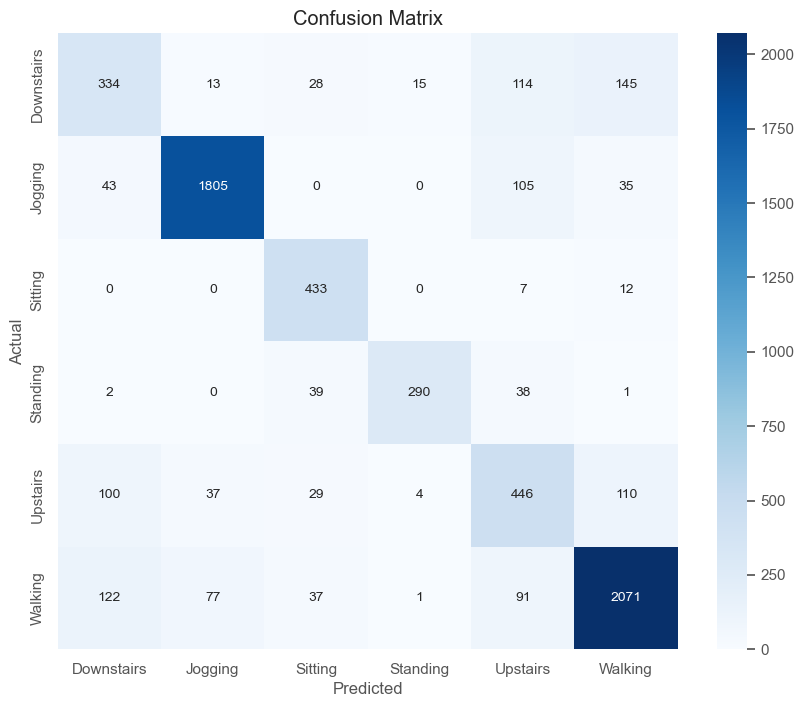

              precision    recall  f1-score   support

  Downstairs       0.56      0.51      0.53       649
     Jogging       0.93      0.91      0.92      1988
     Sitting       0.77      0.96      0.85       452
    Standing       0.94      0.78      0.85       370
    Upstairs       0.56      0.61      0.58       726
     Walking       0.87      0.86      0.87      2399

    accuracy                           0.82      6584
   macro avg       0.77      0.77      0.77      6584
weighted avg       0.82      0.82      0.82      6584



In [350]:
model_mlp_wide_oversample.to(device_eval)

# Evaluate the model
y_pred, y_true = evaluate_model(model_mlp_wide_oversample, device_eval, test_loader_64)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=LABELS))

## CNN

In [352]:
cnn_5_oversample = cnn_5(TIME_PERIODS, n_sensors, n_classes).to(device)
optimizer_cnn_5_oversample = torch.optim.Adam(cnn_5_oversample.parameters(), lr=0.001)

train_losses_cnn_5_oversample, train_accs_cnn_5_oversample, val_losses_cnn_5_oversample, val_accs_cnn_5_oversample = train_and_validate_cnn(cnn_5_oversample, device, train_loader_oversampler, test_loader_64, optimizer_cnn_5_oversample, criterion, num_epochs=200, patience=30)

Epoch 1/200 - Train Loss: 0.6637, Train Acc: 0.7180, Val Loss: 0.9253, Val Acc: 0.7663
Epoch 2/200 - Train Loss: 0.4260, Train Acc: 0.8288, Val Loss: 1.3602, Val Acc: 0.7971
Epoch 3/200 - Train Loss: 0.2918, Train Acc: 0.8927, Val Loss: 1.3507, Val Acc: 0.8285
Epoch 4/200 - Train Loss: 0.1953, Train Acc: 0.9340, Val Loss: 1.2148, Val Acc: 0.8351
Epoch 5/200 - Train Loss: 0.1469, Train Acc: 0.9522, Val Loss: 1.0423, Val Acc: 0.8382
Epoch 6/200 - Train Loss: 0.1127, Train Acc: 0.9649, Val Loss: 0.6363, Val Acc: 0.8522
Epoch 7/200 - Train Loss: 0.0963, Train Acc: 0.9708, Val Loss: 0.6656, Val Acc: 0.8373
Epoch 8/200 - Train Loss: 0.0883, Train Acc: 0.9724, Val Loss: 1.0143, Val Acc: 0.8398
Epoch 9/200 - Train Loss: 0.0681, Train Acc: 0.9795, Val Loss: 0.6794, Val Acc: 0.8721
Epoch 10/200 - Train Loss: 0.0660, Train Acc: 0.9809, Val Loss: 0.7033, Val Acc: 0.8621
Epoch 11/200 - Train Loss: 0.0535, Train Acc: 0.9846, Val Loss: 0.7393, Val Acc: 0.8566
Epoch 12/200 - Train Loss: 0.0463, Train 

In [172]:
# [filter size, stride, padding]

convnet =[[5,3,0],[2,2,0],[4,2,0],[2,1,0],[3,1,0], [1,1,0]]
layer_name = ['conv1','pool1','conv2','pool2','conv3', 'conv4']
imsize = 1

def outFromIn(isz, layernum = 9, net = convnet):
    if layernum>len(net): layernum=len(net)

    totstride = 1
    insize = isz
    #for layerparams in net:
    for layer in range(layernum):
        fsize, stride, pad = net[layer]
        outsize = (insize - fsize + 2*pad) / stride + 1
        insize = outsize
        totstride = totstride * stride
    return outsize, totstride

def inFromOut( layernum = 9, net = convnet):
    if layernum>len(net): layernum=len(net)
    outsize = 1
    #for layerparams in net:
    for layer in reversed(range(layernum)):
        fsize, stride, pad = net[layer]
        outsize = ((outsize -1)* stride) + fsize
    RFsize = outsize
    return RFsize

for i in range(len(convnet)):
        p = inFromOut(i)
        print(f"Layer Name = {layer_name[i]}, Receptive Field = {p}")


Layer Name = conv1, Receptive Field = 1
Layer Name = pool1, Receptive Field = 5
Layer Name = conv2, Receptive Field = 8
Layer Name = pool2, Receptive Field = 26
Layer Name = conv3, Receptive Field = 38
Layer Name = conv4, Receptive Field = 62


In [166]:
p

(66.0, 3)

In [ ]:
for i in range(len(convnet)):
        p = outFromIn(1, i)
        print(f"Layer Name = {layer_name[i]}, Receptive Field = {p}")

In [176]:
outFromIn(1, 4)

(-2.083333333333333, 12)